In [12]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import mpl_toolkits as mplot3d
import scipy as sp
pd.set_option("display.max_columns", None)
from tqdm import tqdm
tqdm.pandas()

In [13]:
#changes to be made -->
# search for temp and make those changes
# errorbar, change x and y to match in later graphs

In [14]:
def lighten_color(color, amount=0.5):
    """
    Lightens the given color by multiplying (1-luminosity) by the given amount.
    Input can be matplotlib color string, hex string, or RGB tuple.

    Examples:
    >> lighten_color('g', 0.3)
    >> lighten_color('#F034A3', 0.6)
    >> lighten_color((.3,.55,.1), 0.5)
    """
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], 1 - amount * (1 - c[1]), c[2])

# DATA CLEANING AND WRANGLING

### Data Cleaning

In [15]:
# DF1 = Total and facet scores, and score per question
df00 = pd.read_csv('Indian Risk Literacy DYNATA_normal launch_2.csv')[26:]
print(len(df00["ResponseId"]))

# drop na in responses
df0 = df00.dropna(subset = df00.columns[19:77])
print(len(df0["ResponseId"]))

# removing students
df0 = df0.loc[ ~(df0["Q4a"] == "Student")].copy()
print(len(df0["ResponseId"]))

# removing straight liners
matrix = ["Q8_1", "Q8_2", "Q8_3", "Q8_4", "Q8_5", "Q8_6", "Q8_7", "Q8_8"]
dict = {"1 (strongly disagree)":1 , "2":2, "3":3, "4":4, "5":5, "6 (strongly agree)":6}
for ques in matrix:
    df0[ques] = df0[ques].astype(str).replace(dict)
df0["Q8_std"] = df0[matrix].std(axis = 1)
df0 = df0.loc[ df0["Q8_std"] != 0].copy()
print(len(df0["ResponseId"]))

# attention check
df0 = df0.loc[ df0["Attention Check"] == "Vase"].copy()
print(len(df0["ResponseId"]))

# <0.5 median time of completion filtered
df0["Duration (in seconds)"] = df0["Duration (in seconds)"].astype("Int64")
median = df0["Duration (in seconds)"].astype("Int64").median()
df0 = df0.loc[ df0["Duration (in seconds)"] >= median*0.5].copy()
print(len(df0["ResponseId"]))


4443
963
961
846
846
699


In [16]:
df1 = df0.iloc[:, 19:77].copy().reset_index(drop = True)
df1.insert(0, "ResponseId", range(0, len(df1)))
df1

ResponseId      Q1  Q2                     Q3  \
0             0    Male  30  Post-Graduate Program   
1             1    Male  53  Post-Graduate Program   
2             2    Male  43  Undergraduate Program   
3             3    Male  32  Undergraduate Program   
4             4  Female  31  Post-Graduate Program   
..          ...     ...  ..                    ...   
694         694  Female  44       Ph.D. and higher   
695         695    Male  37  Post-Graduate Program   
696         696    Male  41  Post-Graduate Program   
697         697    Male  33  Post-Graduate Program   
698         698    Male  34  Post-Graduate Program   

                             Q4a             Q4.5_4             Q4.5_5  \
0                       Salaried         Financial             Health    
1                       Salaried       unemployment     global warming   
2    Entrepreneur/Business Owner          financial             health   
3                       Salaried  Make my business   Personal finance    
4                       Salaried            economy       job security   
..                           ...                ...                ...   
694                     Salaried     Financial risk        Health risk   
695  Entrepreneur/Business Owner              Money             House    
696                     Salaried          inflation           security   
697                     Salaried          Planning             Target    
698                     Salaried         Inflation               Noise   

                                     Q4.5_6                      Q5_1  \
0                                 Politics                          5   
1                                 terrorism                         5   
2    rising prices of essential commodities                         6   
3                            Health issues   7 (willing to take risk)   
4                           gender equality                         6   
..                                      ...                       ...   
694                             Career risk                         3   
695                                  Health                         6   
696               high prices of education   7 (willing to take risk)   
697                                Working   7 (willing to take risk)   
698                              Pollution                          5   

                        Q6 - changed  Q8_1  Q8_2  Q8_3  Q8_4  Q8_5  Q8_6  \
0             Rather much experience     5     5     5     6     6     6   
1                    Some experience     4     2     2     5     5     5   
2                    Some experience     5     4     5     4     5     5   
3    Definitely very much experience     6     5     5     6     6     5   
4    Definitely very much experience     4     5     4     5     6     6   
..                               ...   ...   ...   ...   ...   ...   ...   
694                  Some experience     5     5     3     2     3     5   
695  Definitely very much experience     5     4     5     5     5     6   
696  Definitely very much experience     6     6     6     6     6     5   
697  Definitely very much experience     5     6     6     6     6     5   
698                  Some experience     5     5     4     3     4     5   

     Q8_7  Q8_8 Q9b_1 Q9b_4 Q9b_10 Q9b_5 Q9b_11 Q9b_12 Q9b_6 Q9b_7 Q9b_8  \
0       5     6    25    15     10     0      0      0     0    15    15   
1       4     6    10    10      0     0      0      0     0    10     0   
2       5     4    80    20      0     0      0      0     0     0     0   
3       6     6    10     5      5     5      0      0     0    40     5   
4       5     5    20    25      5     5      5      5     1     5     5   
..    ...   ...   ...   ...    ...   ...    ...    ...   ...   ...   ...   
694     5     5    10    10      5     0      0      0     0    50     5   
695     6     4    30    10      1     1      1      1     1    35   

In [17]:
df00.to_csv("Indian Risk Literacy Survey_Dynata_unfiltered v060525.csv")

In [18]:
df1.to_csv("Indian Risk Literacy Survey_Dynata_filtered v060525.csv")

## Demographics

In [36]:
df1["age"] = df1["Q2"].astype(float).copy()

# Age groups/rec = [2,3,4]
# Age group 2 = 18 to 35 y/o
# Age group 3 = 36 to 55 y/o
# Age group 4 = 56 to 75 y/o (75 y/o, i.e, within the scope of the data we have, it can mean 60 and above also)

df1["age_rec"] = np.where( (df1["age"] >= 18) & (df1["age"] <= 35), 2,
                          np.where( (df1["age"] >= 36) & (df1["age"] <= 55), 3,
                                   np.where( (df1["age"] >= 56), 4, 0
                                           )
                                  )
                         )


# Secondary upto 10 – ISCED 3
# Senior Secondary upto 12 - ISCED 3 
# Diploma and voca – ISCED 2
# UG – ISCED 2
# PG – ISCED 1
# PhD and higher – ISCED 1

df1["isced"] = np.where(df1["Q3"] == "Post-Graduate Program", 1,
                        np.where(df1["Q3"] == "Undergraduate Program", 2,
                                 np.where(df1["Q3"] == "Ph.D. and higher", 1,
                                          np.where(df1["Q3"] == "Diploma and Vocational Training", 2,
                                                   np.where(df1["Q3"] == "Secondary School (11th to 12th Std.)", 3,
                                                            np.where( df1["Q3"] == "Primary School (up to 10th Std.)", 3,
                                                                     np.where( df1["Q3"] == "M.Phil.", 1, 0
                                                                             )
                                                                    )
                                                           )
                                                  )
                                         )
                                )
                       )

df1["income"] = np.where(df1["Q15a"] == "< INR 500,000", 1,
                         np.where(df1["Q15a"] == "INR 500,001 – INR 15,00,000", 2,
                                  np.where(df1["Q15a"] == "INR 1500,001 – INR 30,00,000", 3,
                                           np.where(df1["Q15a"] == "INR 30,00,001 – INR 50,00,000", 4,
                                                    np.where(df1["Q15a"] == "INR 50,00,001 – INR 75,00,000", 5,
                                                             np.where( df1["Q15a"] == "> INR 75,00,000", 6,0
                                                                     )
                                                            )
                                                   )
                                           )
                                  )
                         )

df1["wealth"] = df1["Q14b"].astype(float).copy()


In [25]:
df1["Q15a"].value_counts()

Q15a
INR 500,001 – INR 15,00,000      221
< INR 500,000                    194
INR 1500,001 – INR 30,00,000     114
INR 30,00,001 – INR 50,00,000     76
INR 50,00,001 – INR 75,00,000     52
> INR 75,00,000                   42
Name: count, dtype: int64

In [10]:
df1["Q1"].count()

699

In [11]:
df1["Q1"].value_counts()

Q1
Male      361
Female    338
Name: count, dtype: int64

In [12]:
df1["Q3"].value_counts()

Q3
Post-Graduate Program                   225
Undergraduate Program                   206
Secondary School (11th to 12th Std.)    177
Diploma and Vocational Training          35
Primary School (up to 10th Std.)         29
Ph.D. and higher                         16
M.Phil.                                  11
Name: count, dtype: int64

In [13]:
df1["isced"].value_counts()

isced
1    252
2    241
3    206
Name: count, dtype: int64

In [14]:
df1["Q4a"].value_counts()

Q4a
Salaried                       490
Entrepreneur/Business Owner    129
Currently not employed          68
Retired                         12
Name: count, dtype: int64

In [15]:
df1["Q15a"].value_counts().iloc[[1, 0, 2, 3, 4, 5]]

Q15a
< INR 500,000                    194
INR 500,001 – INR 15,00,000      221
INR 1500,001 – INR 30,00,000     114
INR 30,00,001 – INR 50,00,000     76
INR 50,00,001 – INR 75,00,000     52
> INR 75,00,000                   42
Name: count, dtype: int64

In [16]:
df1["income"].value_counts().sort_index()

#   < INR 500,000                      --> 1
#     INR 500,001 – INR 15,00,000      --> 2
#     INR 1500,001 – INR 30,00,000     --> 3
#     INR 30,00,001 – INR 50,00,000    --> 4
#     INR 50,00,001 – INR 75,00,000    --> 5
#   > INR 75,00,000                    --> 5

income
1    194
2    221
3    114
4     76
5     52
6     42
Name: count, dtype: int64

## Winsorizing Income and Wealth

In [ ]:
## Winsorizing Wealth

In [57]:
from scipy.stats.mstats import winsorize

a = winsorize(np.array(df1["wealth"]), limits = [0.1, 0.1], inclusive = [False, False])

In [62]:
df1["winsorized_wealth"] = winsorize(np.array(df1["wealth"]), limits = [0.1, 0.1], inclusive = [False, False])

In [64]:
df1.describe()

C:\Users\SHIVAM\anaconda3\Lib\site-packages\numpy\lib\function_base.py:4824: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
C:\Users\SHIVAM\anaconda3\Lib\site-packages\numpy\lib\function_base.py:4824: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
C:\Users\SHIVAM\anaconda3\Lib\site-packages\numpy\lib\function_base.py:4824: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(


ResponseId        Q8_1        Q8_2        Q8_3        Q8_4        Q8_5  \
count  699.000000  699.000000  699.000000  699.000000  699.000000  699.000000   
mean   349.000000    4.589413    4.522175    4.552217    4.429185    4.669528   
std    201.928205    1.270765    1.259011    1.244382    1.314044    1.241972   
min      0.000000    1.000000    1.000000    1.000000    1.000000    1.000000   
25%    174.500000    4.000000    4.000000    4.000000    4.000000    4.000000   
50%    349.000000    5.000000    5.000000    5.000000    5.000000    5.000000   
75%    523.500000    6.000000    5.000000    6.000000    5.000000    6.000000   
max    698.000000    6.000000    6.000000    6.000000    6.000000    6.000000   

             Q8_6        Q8_7        Q8_8         age     age_rec       isced  \
count  699.000000  699.000000  699.000000  699.000000  699.000000  699.000000   
mean     4.712446    4.483548    4.542203   35.194564    2.456366    1.934192   
std      1.206003    1.337449    1.381159   11.327980    0.614322    0.807356   
min      1.000000    1.000000    1.000000   18.000000    2.000000    1.000000   
25%      4.000000    4.000000    4.000000   27.000000    2.000000    1.000000   
50%      5.000000    5.000000    5.000000   33.000000    2.000000    2.000000   
75%      6.000000    6.000000    6.000000   42.000000    3.000000    3.000000   
max      6.000000    6.000000    6.000000   75.000000    4.000000    3.000000   

           income        wealth  winsorized_wealth  
count  699.000000  6.990000e+02       6.990000e+02  
mean     2.566524  1.628566e+08       3.129498e+06  
std      1.479398  3.794346e+09       4.770219e+06  
min      1.000000  0.000000e+00       5.000000e+03  
25%      1.000000  1.000000e+05       1.000000e+05  
50%      2.000000  6.000000e+05       6.000000e+05  
75%      3.000000  4.000000e+06       4.000000e+06  
max      6.000000  1.000000e+11       1.500000e+07

C:\Users\SHIVAM\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\SHIVAM\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


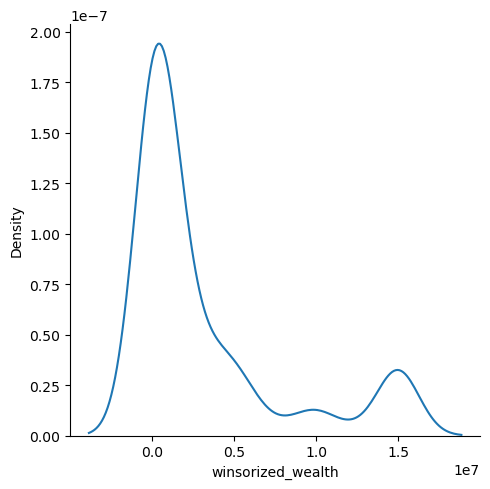

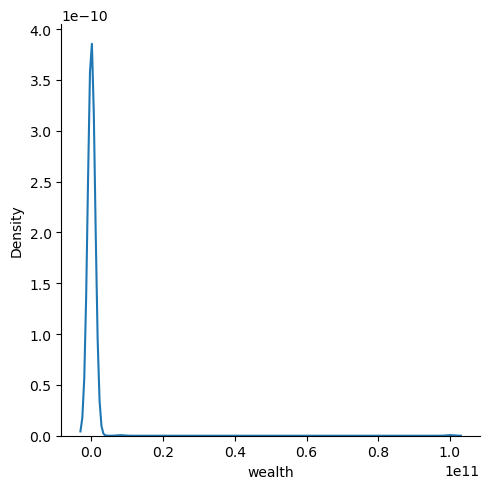

In [66]:
# WEALTH - winsorized, and non winsorized
sns.displot(data = df1["winsorized_wealth"], kind = "kde")
sns.displot(data = df1["wealth"], kind = "kde")

## Questions

In [28]:
matchCol = ["q8_2_1", "q8_2_2", "q8_2_3", "q8_2_4", "q8_2_5", "q8_3", "q8_4", "q8_5berlin_1", 
            "q8_5london_1", "q8_5paris_1", "q8_6", "q8_7", "q9_1_1", "q9_2_1", "q9_3",
            "q10_1_1", "q10_2_1", "q10_3_1", "q10_4"]
df1[ matchCol ] = 0

df1.columns

Index(['ResponseId', 'Q1', 'Q2', 'Q3', 'Q4a', 'Q4.5_4', 'Q4.5_5', 'Q4.5_6',
       'Q5_1', 'Q6 - changed', 'Q8_1', 'Q8_2', 'Q8_3', 'Q8_4', 'Q8_5', 'Q8_6',
       'Q8_7', 'Q8_8', 'Q9b_1', 'Q9b_4', 'Q9b_10', 'Q9b_5', 'Q9b_11', 'Q9b_12',
       'Q9b_6', 'Q9b_7', 'Q9b_8', 'Q9b_13', 'Q9b_14', 'Q9b_9', 'Q14b',
       'Q11a_1', 'Q11a_2', 'Q11a_3', 'Q11b_1', 'Q11b_2', 'Q11b_3', 'Q11b_4',
       'Q11b_5', 'Q11c', 'Q11d', 'Q11h', 'Attention Check', 'Q11i', 'Q13a',
       'Q13b', 'Q13c', 'Q13d', 'Q12a', 'Q12b', 'Q12c', 'Q14a', 'Q14b.1',
       'Q14c', 'Q54', 'Q57', 'Q58', 'Q15a', 'psid', 'age', 'age_rec', 'isced',
       'income', 'wealth', 'q8_2_1', 'q8_2_2', 'q8_2_3', 'q8_2_4', 'q8_2_5',
       'q8_3', 'q8_4', 'q8_5berlin_1', 'q8_5london_1', 'q8_5paris_1', 'q8_6',
       'q8_7', 'q9_1_1', 'q9_2_1', 'q9_3', 'q10_1_1', 'q10_2_1', 'q10_3_1',
       'q10_4'],
      dtype='object')

In [69]:
df1["q8_2_1"] = np.where(df1["Q11b_1"] == "No", 1, 2)
df1["q8_2_2"] = np.where(df1["Q11b_2"] == "No", 1, 2)
df1["q8_2_3"] = np.where(df1["Q11b_3"] == "No", 1, 2)
df1["q8_2_4"] = np.where(df1["Q11b_4"] == "No", 1, 2)
df1["q8_2_5"] = np.where(df1["Q11b_5"] == "No", 1, 2)

df1["q8_3"] = np.where(df1["Q11c"] == "The lower the quality of the study, the more likely that future studies will change the risk estimate.", 1,
                          np.where(df1["Q11c"] == "The higher the quality of the study, the more likely that future studies will change the risk estimate.", 2,
                                  np.where(df1["Q11c"] == "Irrespective of the quality of the study, future studies will not change the risk estimate.", 3,
                                          np.where(df1["Q11c"] == "Irrespective of the quality of the study, future studies will change the risk estimate substantially anyway.", 4,0
                                                  )
                                          )
                                  )
                         )


df1["q8_4"] = np.where(df1["Q11d"] == "The growth rate will be 0.4% on average each year", 1,
                          np.where(df1["Q11d"] == "The growth rate over five years will be exactly 2%", 2,
                                  np.where(df1["Q11d"] == "The growth rate over five years will be between 1% and 3%", 3,
                                          np.where(df1["Q11d"] == "It is not possible to predict the growth rate with certainty", 4,0
                                                  )
                                          )
                                  )
                         )

In [75]:
df1["q8_4"].value_counts()

q8_4
3    223
4    200
2    174
1    102
Name: count, dtype: int64

In [92]:
df1["q8_5berlin_1"] = np.where(df1["Q11a_1"].astype(int) == 1, 1, 2)
df1["q8_5london_1"] = np.where(df1["Q11a_1"].astype(int) == 1, 1, 2)
df1["q8_5paris_1"] = np.where(df1["Q11a_1"].astype(int) == 1, 1, 2)

df1["q8_6"] = np.where(df1["Q11i"] == "The medication increases recovery by 100%", 1,
                          np.where(df1["Q11i"] == "The medication increases recovery by 50%", 2,
                                   np.where(df1["Q11i"] == "The medication increases recovery by 2%", 3,
                                            np.where(df1["Q11i"] == "None of the above is implied", 4, 0
                                                    )
                                           )
                                  )
                         )

df1["q8_7"] = np.where(df1["Q11h"] == "5 in 100 people prior to the intervention to 6 out of 100 people after the intervention", 1,
                          np.where(df1["Q11h"] == "100 in 10,000 people prior to the intervention to 120 out of 10,000 people after the intervention", 2,
                                   np.where(df1["Q11h"] == "70 in 100 people prior to the intervention to 90 out of 100 people after the intervention", 3,
                                            np.where(df1["Q11h"] == "It is not possible to determine which of the answers is correct given the information provided", 4, 0
                                                    )
                                           )
                                  )
                         )


df1["q9_1_1"] = df1["Q14a"].astype(float).copy()
df1["q9_2_1"] = df1["Q14b.1"].astype(float).copy()

df1["q9_3"] = np.where(df1["Q14c"] == "Crosicol", 1,
                          np.where(df1["Q14c"] == "Hertinol", 2,
                                   np.where(df1["Q14c"] == "They are equal", 3,
                                            np.where(df1["Q14c"] == "Can’t say", 4, 0
                                                    )
                                           )
                                  )
                         )

In [95]:
df1["q9_3"].value_counts()

q9_3
3    224
2    218
1    204
4     53
Name: count, dtype: int64

In [101]:
df1["q10_1_1"] = df1["Q13a"].astype(float).copy()
df1["q10_2_1"] = df1["Q13b"].astype(float).copy()
df1["q10_3_1"] = df1["Q13c"].astype(float).copy()

df1["q10_4"] = np.where(df1["Q13d"] == "9 out of 59", 1,
                          np.where(df1["Q13d"] == "9 out of 10", 2,
                                   np.where(df1["Q13d"] == "59 out of 1000", 3,
                                            np.where(df1["Q13d"] == "59 out of 100", 4, 0
                                                    )
                                           )
                                  )
                         )

In [103]:
df1["q10_4"].value_counts()

q10_4
3    241
2    190
1    158
4    110
Name: count, dtype: int64

In [104]:
scoreColumns = ["certainty1", "certainty2", "certainty3", "certainty4", "certainty5", "uncertainty1", "uncertainty2", "numeracy1", "numeracy2", "numeracy3", "numeracy4", "numeracy5", "graph1", "graph2", "graph3", "riskcalculation1", "riskcalculation2", "riskcalculation3", "riskcalculation4"]
df1[scoreColumns] = 0

In [116]:
# Assigning scores

def scoring1(surveyFacet):
    surveyFacet.loc[ surveyFacet["q8_2_1"] == 2, "certainty1"] = 1
    surveyFacet.loc[ surveyFacet["q8_2_2"] == 2, "certainty2"] = 1
    surveyFacet.loc[ surveyFacet["q8_2_3"] == 2, "certainty3"] = 1
    surveyFacet.loc[ surveyFacet["q8_2_4"] == 2, "certainty4"] = 1
    surveyFacet.loc[ surveyFacet["q8_2_5"] == 2, "certainty5"] = 1

    surveyFacet.loc[ surveyFacet["q8_3"] == 1, "uncertainty1"] = 1
    surveyFacet.loc[ surveyFacet["q8_4"] == 4, "uncertainty2"] = 1

    surveyFacet.loc[ surveyFacet["q8_5berlin_1"] == 2, "riskcomprehension1"] = 1
    surveyFacet.loc[ surveyFacet["q8_5london_1"] == 1, "riskcomprehension2"] = 1
    surveyFacet.loc[ surveyFacet["q8_5paris_1"] == 1, "riskcomprehension3"] = 1
    
    surveyFacet.loc[ surveyFacet["q8_6"] == 1, "riskcomprehension4"] = 1
    surveyFacet.loc[ surveyFacet["q8_7"] == 4, "riskcomprehension5"] = 1

    surveyFacet.loc[ surveyFacet["q9_1_1"] == 25, "graph1"] = 1
    surveyFacet.loc[ surveyFacet["q9_2_1"] == 20, "graph2"] = 1
    surveyFacet.loc[ surveyFacet["q9_3"] == 3, "graph3"] = 1

    surveyFacet.loc[ surveyFacet["q10_1_1"] == 500, "numeracy1"] = 1
    surveyFacet.loc[ surveyFacet["q10_2_1"] == 10, "numeracy2"] = 1
    surveyFacet.loc[ (surveyFacet["q10_3_1"] == 0.1) | (surveyFacet["q10_3_1"] == ".1") | (surveyFacet["q10_3_1"] == ",1") , "numeracy3"] = 1
    surveyFacet.loc[ surveyFacet["q10_4"] == 1, "bayesian1"] = 1

    # Assigning total scores
    # surveyFacet["Certainty score_5"] = surveyFacet["certainty1"] + surveyFacet["certainty2"] + surveyFacet["certainty3"] + surveyFacet["certainty4"] + surveyFacet["certainty5"]
    #surveyFacet["Uncertainty score_5"] = surveyFacet["uncertainty1"] + surveyFacet["uncertainty2"]

    #surveyFacet["Number Comprehension score_5"] = surveyFacet["numeracy1"] + surveyFacet["numeracy2"] + surveyFacet["numeracy3"] + surveyFacet["numeracy4"] + surveyFacet["numeracy5"]
    #surveyFacet["Graph Comprehension score_5"] = surveyFacet["graph1"] + surveyFacet["graph2"] + surveyFacet["graph3"]

    #surveyFacet["Calculation score_4"] = surveyFacet["riskcalculation1"] + surveyFacet["riskcalculation2"] + surveyFacet["riskcalculation3"] + surveyFacet["riskcalculation4"]

    #surveyFacet["Total Score_19"] = surveyFacet["Certainty score_5"] + surveyFacet["Uncertainty score_5"] + surveyFacet["Number Comprehension score_5"] + surveyFacet["Graph Comprehension score_5"] + surveyFacet["Calculation score_4"]

    return surveyFacet

In [117]:
df2 = df1.groupby(["ResponseId"]).progress_apply(scoring1)
df2

100%|███████████████████████████████████████████████████████████████████████████████| 699/699 [00:03<00:00, 216.90it/s]


ResponseId      Q1  Q2                     Q3  \
ResponseId                                                      
0          0             0    Male  30  Post-Graduate Program   
1          1             1    Male  53  Post-Graduate Program   
2          2             2    Male  43  Undergraduate Program   
3          3             3    Male  32  Undergraduate Program   
4          4             4  Female  31  Post-Graduate Program   
...                    ...     ...  ..                    ...   
694        694         694  Female  44       Ph.D. and higher   
695        695         695    Male  37  Post-Graduate Program   
696        696         696    Male  41  Post-Graduate Program   
697        697         697    Male  33  Post-Graduate Program   
698        698         698    Male  34  Post-Graduate Program   

                                        Q4a             Q4.5_4  \
ResponseId                                                       
0          0                       Salaried         Financial    
1          1                       Salaried       unemployment   
2          2    Entrepreneur/Business Owner          financial   
3          3                       Salaried  Make my business    
4          4                       Salaried            economy   
...                                     ...                ...   
694        694                     Salaried     Financial risk   
695        695  Entrepreneur/Business Owner              Money   
696        696                     Salaried          inflation   
697        697                     Salaried          Planning    
698        698                     Salaried         Inflation    

                           Q4.5_5                                  Q4.5_6  \
ResponseId                                                                  
0          0              Health                                Politics    
1          1       global warming                               terrorism   
2          2               health  rising prices of essential commodities   
3          3    Personal finance                           Health issues    
4          4         job security                         gender equality   
...                           ...                                     ...   
694        694        Health risk                             Career risk   
695        695             House                                   Health   
696        696           security               high prices of education    
697        697            Target                                 Working    
698        698              Noise                              Pollution    

                                    Q5_1                     Q6 - changed  \
ResponseId                                                                  
0          0                           5           Rather much experience   
1          1                           5                  Some experience   
2          2                           6                  Some experience   
3          3    7 (willing to take risk)  Definitely very much experience   
4          4                           6  Definitely very much experience   
...                                  ...                              ...   
694        694                         3                  Some experience   
695        695                         6  Definitely very much experience   
696        696  7 (willing to take risk)  Definitely very much experience   
697        697  7 (willing to take risk)  Definitely very much experience   
698        698                         5                  Some experience   

                Q8_1  Q8_2  Q8_3  Q8_4  Q8_5  Q8_6  Q8_7  Q8_8 Q9b_1 Q9b_4  \
ResponseId                                                                   
0          0       5     5     5     6     6     6     5     6    25    15   
1          1       4     2     2     5     5     5     4     6    10    1

In [118]:
df2 = df2.reset_index(drop = True).dropna().copy()

In [40]:
def scoring2(survey):
    
    survey["Certainty_5"] = survey["certainty1"] + survey["certainty2"] + survey["certainty3"] + survey["certainty4"] + survey["certainty5"]
    
    survey["Uncertainty_2"] = survey["uncertainty1"] + survey["uncertainty2"]
    
    survey["RiskComprehension_5"] = survey["riskcomprehension1"] + survey["riskcomprehension2"] + survey["riskcomprehension3"] + survey["riskcomprehension4"] + survey["riskcomprehension5"]
    
    survey["GraphLiteracy_3"] = survey["graph1"] + survey["graph2"] + survey["graph3"]
    
    survey["Numeracy_2"] = survey["numeracy1"] + survey["numeracy2"] # + survey["numeracy3"]
    
    survey["Bayesianreasoning_1"] = survey["bayesian1"]
    
    survey["TotalScore_18"] = survey["Certainty_5"] + survey["Uncertainty_2"] + survey["RiskComprehension_5"] + survey["GraphLiteracy_3"] + survey["Numeracy_2"] + survey["Bayesianreasoning_1"]
    
    survey["Certainty_%"] = survey["Certainty_5"] / 5 * 100
    survey["Uncertainty_%"] = survey["Uncertainty_2"] / 2 * 100
    survey["RiskComprehension_%"] = survey["RiskComprehension_5"] / 5 * 100
    survey["GraphLiteracy_%"] = survey["GraphLiteracy_3"] / 3 * 100
    survey["Numeracy_%"] = survey["Numeracy_2"] / 2 * 100
    survey["Bayesianreasoning_%"] = survey["Bayesianreasoning_1"] / 1 * 100
    
    survey["TotalScore_%"] = survey["TotalScore_18"] / 18 * 100
    
    
    colReq = ["ResponseId", "age", "age_rec", "isced", "income", "wealth", "Certainty_5", "Uncertainty_2", "RiskComprehension_5", "GraphLiteracy_3",
              "Numeracy_2", "Bayesianreasoning_1", "Certainty_%", "Uncertainty_%", "RiskComprehension_%", "GraphLiteracy_%", "Numeracy_%", "Bayesianreasoning_%",
              "TotalScore_18", "TotalScore_%",]
    
    survey1 = survey[colReq].copy()
    return survey1

ResponseId  age  age_rec  isced  income    wealth  \
ResponseId                                                          
0          0             0   30        2      1       2   5000000   
1          1             1   53        3      1       4   9000000   
2          2             2   43        3      2       1   2200000   
3          3             3   32        2      2       3   8000000   
4          4             4   31        2      1       3  35000000   
...                    ...  ...      ...    ...     ...       ...   
694        694         694   44        3      1       2   5000000   
695        695         695   37        3      1       2   3000000   
696        696         696   41        3      1       2   2500000   
697        697         697   33        2      1       2    100000   
698        698         698   34        2      1       2     65000   

                Certainty_3  RiskComprehension_4  GraphLiteracy_3  Numeracy_3  \
ResponseId                                                                      
0          0              2                    1                1           1   
1          1              3                    1                0           2   
2          2              3                    0                1           1   
3          3              2                    0                0           1   
4          4              3                    0                0           2   
...                     ...                  ...              ...         ...   
694        694            3                    0                1           2   
695        695            3                    0                0           1   
696        696            3                    0                1           1   
697        697            1                    0                0           1   
698        698            1                    0                0           1   

                Bayesianreasoning_1  Certainty_%  RiskComprehension_%  \
ResponseId                                                              
0          0                      0    66.666667                 25.0   
1          1                      0   100.000000                 25.0   
2          2                      1   100.000000                  0.0   
3          3                      0    66.666667                  0.0   
4          4                      0   100.000000                  0.0   
...                             ...          ...                  ...   
694        694                    1   100.000000                  0.0   
695        695                    0   100.000000                  0.0   
696        696                    0   100.000000                  0.0   
697        697                    1    33.333333                  0.0   
698        698                    0    33.333333                  0.0   

                GraphLiteracy_%  Numeracy_%  Bayesianreasoning_%  \
ResponseId                                                         
0          0          33.333333   33.333333                  0.0   
1          1           0.000000   66.666667                  0.0   
2          2          33.333333   33.333333                100.0   
3          3           0.000000   33.333333                  0.0   
4          4           0.000000   66.666667                  0.0   
...                         ...         ...                  ...   
694        694        33.333333   66.666667                100.0   
695        695         0.000000   33.333333                  0.0   
696        696        33.333333   33.333333                  0.0   
697        697         0.000000   33.333333                100.0   
698        698         0.000000   33.333333                  0.0   

                TotalScore_14  TotalScore_%  
ResponseId                                   
0          0                5     35.714286  
1          1                6     42.857143  
2          2                6     42.857143  

In [ ]:
df2 = df2(d0)
df2

In [1]:
# The following graph represents frequency of each data point on "TotalScore_14" or the total score out of 19 questions across the sample.

df2['TotalScore_14'].plot(kind = 'hist', xticks = np.arange(0, 15, step=1), xlabel = 'TotalScore_14', title = 'Frequency of Scores' )

NameError: name 'df2' is not defined

<Axes: title={'center': 'Absolute mean of scores for above data set'}>

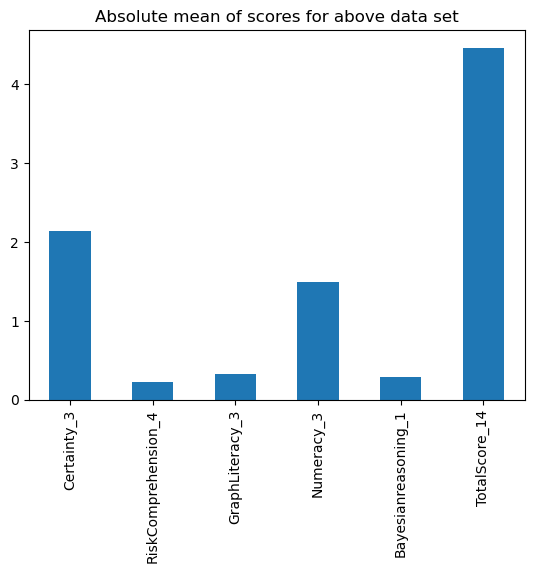

In [42]:
# Absolute mean scores for each facet

(df2[['Certainty_3','RiskComprehension_4','GraphLiteracy_3','Numeracy_3','Bayesianreasoning_1','TotalScore_14']].mean(axis = 0)).plot(kind = 'bar', title = 'Absolute mean of scores for above data set')

<Axes: title={'center': '% Mean of scores for above data set'}>

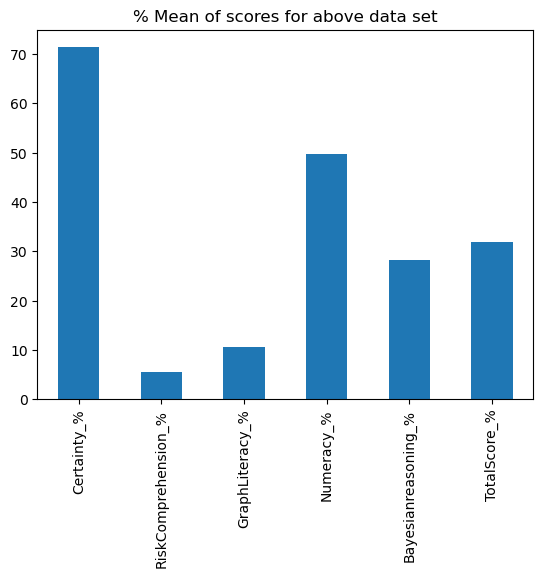

In [43]:
# Normalised mean scores for each facet

df2[['Certainty_%','RiskComprehension_%','GraphLiteracy_%','Numeracy_%','Bayesianreasoning_%','TotalScore_%']].mean(axis = 0).plot(kind = 'bar', title = '% Mean of scores for above data set')

In [44]:
# DF3 = Sorted by income

df3 = df2.sort_values(by = 'income')
df3 = df3.reset_index(drop = True)
df3.drop(df3[df3['income'] == 7].index, inplace = True)

df3

ResponseId  age  age_rec  isced  income   wealth  Certainty_3  \
0           306   49        3      3       1   300000            2   
1           479   25        2      2       1    50000            2   
2           477   25        2      2       1    50000            2   
3           476   21        2      2       1  5000000            2   
4           475   42        3      2       1   200000            3   
..          ...  ...      ...    ...     ...      ...          ...   
694         605   26        2      1       6   450000            1   
695         199   35        2      1       6   100000            2   
696         596   40        3      1       6   500000            2   
697         227   45        3      2       6   750000            3   
698         307   30        2      3       6  1500000            3   

     RiskComprehension_4  GraphLiteracy_3  Numeracy_3  Bayesianreasoning_1  \
0                      0                0           2                    0   
1                      0                1           1                    1   
2                      0                0           1                    0   
3                      0                0           1                    0   
4                      0                0           1                    0   
..                   ...              ...         ...                  ...   
694                    0                1           2                    0   
695                    0                0           1                    0   
696                    0                0           2                    1   
697                    0                0           1                    1   
698                    0                0           2                    0   

     Certainty_%  RiskComprehension_%  GraphLiteracy_%  Numeracy_%  \
0      66.666667                  0.0         0.000000   66.666667   
1      66.666667                  0.0        33.333333   33.333333   
2      66.666667                  0.0         0.000000   33.333333   
3      66.666667                  0.0         0.000000   33.333333   
4     100.000000                  0.0         0.000000   33.333333   
..           ...                  ...              ...         ...   
694    33.333333                  0.0        33.333333   66.666667   
695    66.666667                  0.0         0.000000   33.333333   
696    66.666667                  0.0         0.000000   66.666667   
697   100.000000                  0.0         0.000000   33.333333   
698   100.000000                  0.0         0.000000   66.666667   

     Bayesianreasoning_%  TotalScore_14  TotalScore_%  
0                    0.0              4     28.571429  
1                  100.0              5     35.714286  
2                    0.0              3     21.428571  
3                    0.0              3     21.428571  
4                    0.0              4     28.571429  
..                   ...            ...           ...  
694                  0.0              4     28.571429  
695                  0.0              3     21.428571  
696                100.0              5     35.714286  
697                100.0              5     35.714286  
698                  0.0              5     35.714286  

[699 rows x 18 columns]

<Axes: title={'center': 'Absolute mean score for each facet'}>

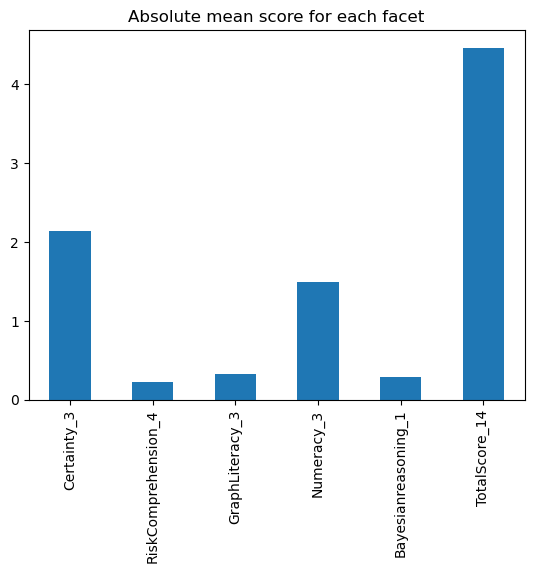

In [45]:
# Absolute mean score for each facet (Sort by Income)

df3[['Certainty_3','RiskComprehension_4','GraphLiteracy_3','Numeracy_3','Bayesianreasoning_1','TotalScore_14']].mean(axis = 0).plot(kind = 'bar', title = 'Absolute mean score for each facet')

<Axes: title={'center': '% Mean score for each facet'}>

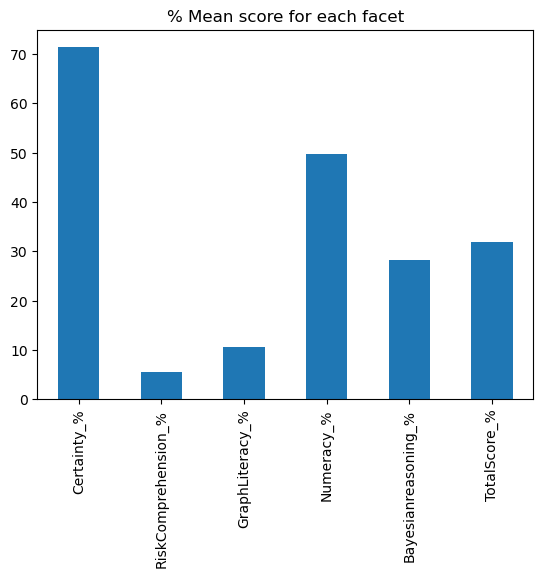

In [46]:
# Normalised mean score for each facet (Sort by Income)

(df3[['Certainty_%','RiskComprehension_%','GraphLiteracy_%','Numeracy_%','Bayesianreasoning_%','TotalScore_%']].mean(axis = 0)).plot(kind = 'bar', title = '% Mean score for each facet')

In [47]:
# Normalised mean of each facet as a numerical (sorted by income)

df3.groupby('income')[['Certainty_%','RiskComprehension_%','GraphLiteracy_%','Numeracy_%','Bayesianreasoning_%','TotalScore_%']].mean()

Certainty_%  RiskComprehension_%  GraphLiteracy_%  Numeracy_%  \
income                                                                  
1         66.838488             4.896907        10.652921   49.484536   
2         72.247360             5.769231        11.915535   49.472097   
3         76.900585             4.166667         9.941520   49.707602   
4         74.122807             7.236842        12.280702   49.561404   
5         66.666667             5.769231         5.769231   54.487179   
6         72.222222             9.523810         9.523810   46.825397   

        Bayesianreasoning_%  TotalScore_%  
income                                     
1                 22.164948     30.191458  
2                 26.696833     32.191338  
3                 31.578947     32.706767  
4                 30.263158     33.364662  
5                 32.692308     31.181319  
6                 47.619048     33.673469

In [48]:
# Count of responses for each category (sorted by income)

df3.groupby('income')[['ResponseId']].count()

ResponseId
income            
1              194
2              221
3              114
4               76
5               52
6               42

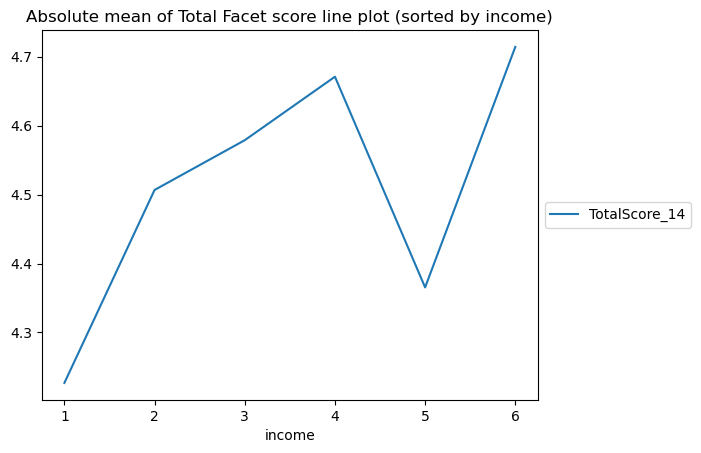

In [49]:
# Absolute mean of Total Facet score line plot (sorted by income)

df3.groupby('income')[['TotalScore_14']].mean().plot( kind = 'line', title = 'Absolute mean of Total Facet score line plot (sorted by income)').legend(loc='center left',bbox_to_anchor=(1.0, 0.5))

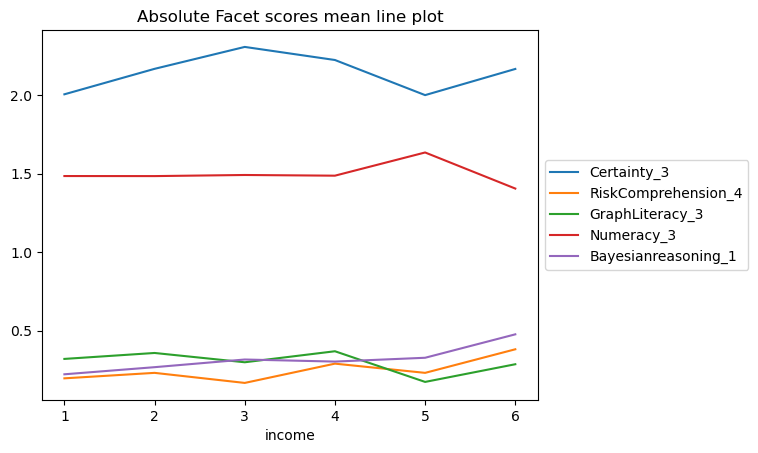

In [50]:
# Absolute mean of each Facet score line plot (sorted by income)

df3.groupby('income')[['Certainty_3','RiskComprehension_4','GraphLiteracy_3','Numeracy_3','Bayesianreasoning_1']].mean().plot( kind = 'line', title = 'Absolute Facet scores mean line plot').legend(loc='center left',bbox_to_anchor=(1.0, 0.5))

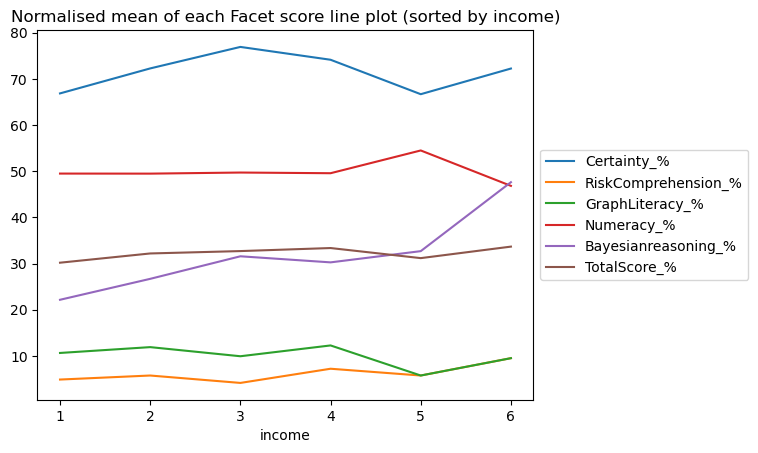

In [51]:
# Normalised mean of each Facet score line plot (sorted by income)


df3.groupby('income')[['Certainty_%','RiskComprehension_%','GraphLiteracy_%','Numeracy_%','Bayesianreasoning_%', 'TotalScore_%']].mean().plot( kind = 'line', title = 'Normalised mean of each Facet score line plot (sorted by income)').legend(loc='center left',bbox_to_anchor=(1.0, 0.5))

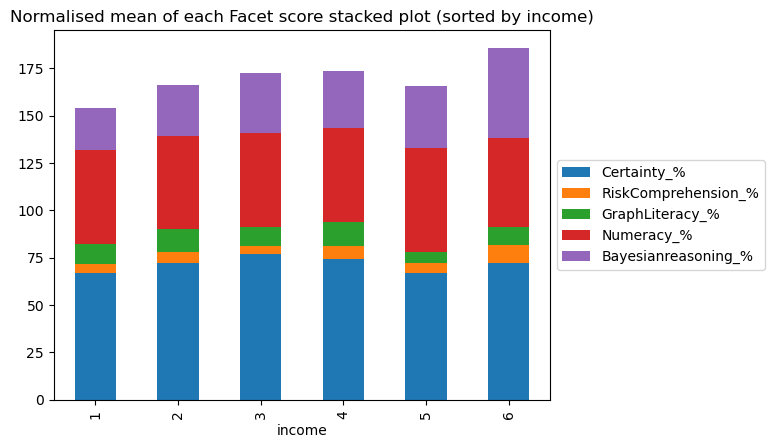

In [52]:
# Normalised mean of each Facet score stacked plot (sorted by income)

df3.groupby('income')[['Certainty_%','RiskComprehension_%','GraphLiteracy_%','Numeracy_%','Bayesianreasoning_%']].mean().plot( kind = 'bar', title = 'Normalised mean of each Facet score stacked plot (sorted by income)', stacked = True).legend(loc='center left',bbox_to_anchor=(1.0, 0.5))

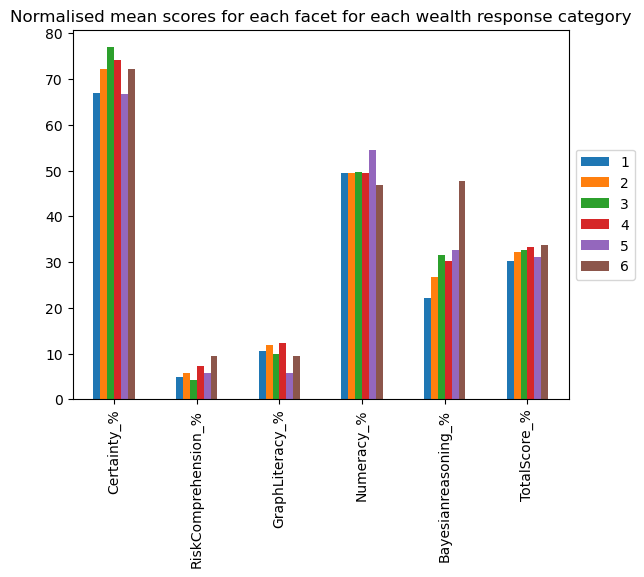

In [53]:
# Normalised mean of each Facet score hist plot (sorted by income)

df3.groupby('income')[['Certainty_%','RiskComprehension_%','GraphLiteracy_%','Numeracy_%','Bayesianreasoning_%','TotalScore_%']].mean().T.plot(kind = 'bar', title = 'Normalised mean scores for each facet for each wealth response category').legend(loc='center left',bbox_to_anchor=(1.0, 0.5))

<Axes: xlabel='income', ylabel='TotalScore_14'>

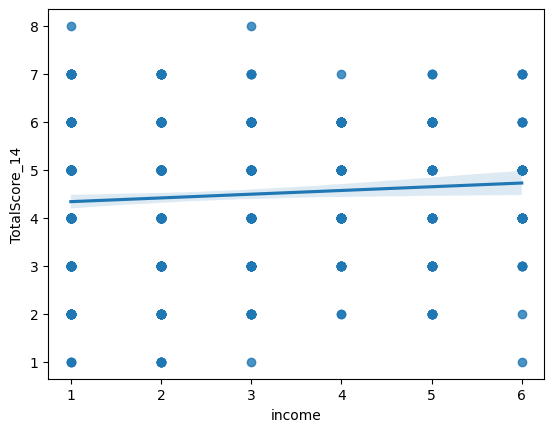

In [54]:
# Trend line for Absolute Total Facet Score vs income

sns.regplot (data = df3, x = 'income', y = 'TotalScore_14')

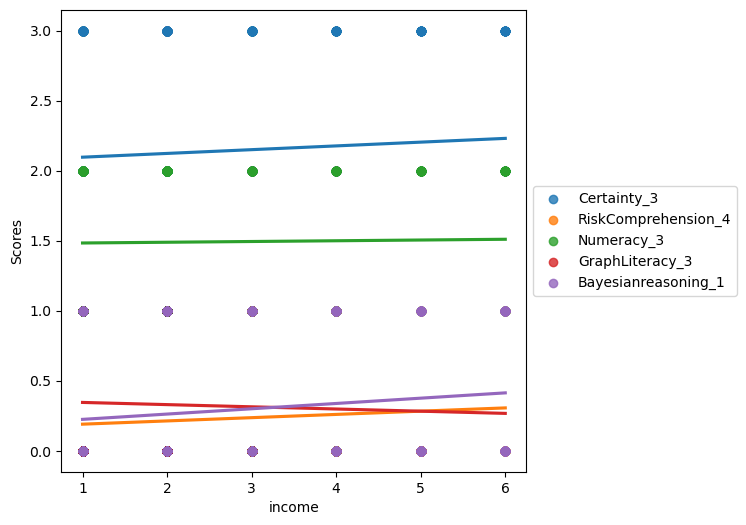

In [55]:
# Trend line for Absolute Independent Facet Score vs income reponses

fig, ax = plt.subplots(figsize=(6, 6))

sns.regplot (data = df3, x = 'income', y = 'Certainty_3', fit_reg=True, ci=None, ax=ax, label='Certainty_3')
sns.regplot (data = df3, x = 'income', y = 'RiskComprehension_4', fit_reg=True, ci=None, ax=ax, label='RiskComprehension_4')
sns.regplot (data = df3, x = 'income', y = 'Numeracy_3', fit_reg=True, ci=None, ax=ax, label='Numeracy_3')
sns.regplot (data = df3, x = 'income', y = 'GraphLiteracy_3', fit_reg=True, ci=None, ax=ax, label='GraphLiteracy_3')
sns.regplot (data = df3, x = 'income', y = 'Bayesianreasoning_1',fit_reg=True, ci=None, ax=ax, label='Bayesianreasoning_1' )

ax.set(ylabel='Scores', xlabel='income')
ax.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

<Axes: xlabel='income', ylabel='TotalScore_14'>

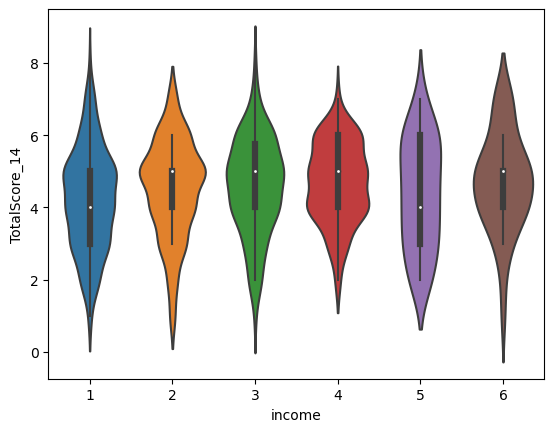

In [56]:
# Violine Plot for TotalScore_14 for each entry under income.

sns.violinplot( data = df3, x = 'income', y = 'TotalScore_14')

<Axes: xlabel='income', ylabel='Certainty_3'>

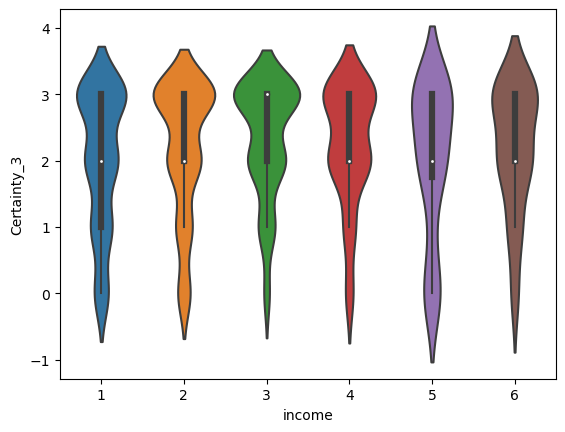

In [57]:
# Violine Plot for Certainty_3 for each entry under income.

sns.violinplot( data = df3, x = 'income', y = 'Certainty_3')

<Axes: xlabel='income', ylabel='RiskComprehension_4'>

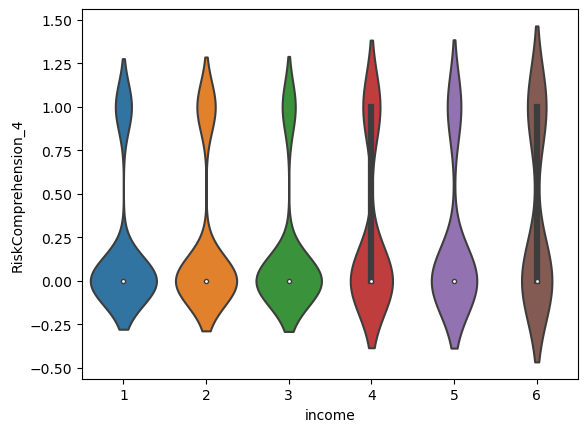

In [58]:
# Violine Plot for RiskComprehension_4 for each entry under income.

sns.violinplot( data = df3, x = 'income', y = 'RiskComprehension_4')

<Axes: xlabel='income', ylabel='GraphLiteracy_3'>

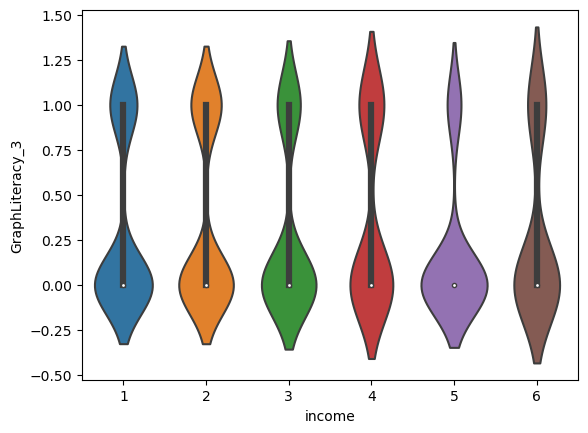

In [59]:
# Violine Plot for GraphLiteracy_3 for each entry under income.

sns.violinplot( data = df3, x = 'income', y = 'GraphLiteracy_3')

<Axes: xlabel='income', ylabel='Numeracy_3'>

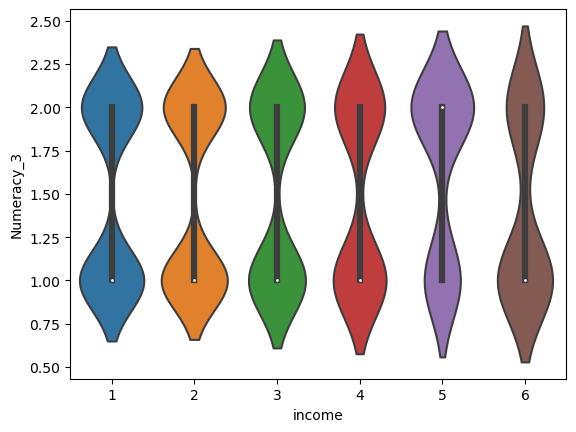

In [60]:
# Violine Plot for Numeracy_3 for each entry under income.

sns.violinplot( data = df3, x = 'income', y = 'Numeracy_3')

<Axes: xlabel='income', ylabel='Bayesianreasoning_1'>

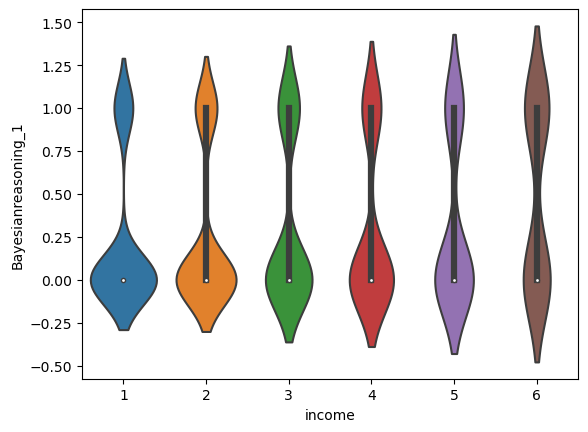

In [61]:
# Violine Plot for TotalScore_14 for each entry under income.

sns.violinplot( data = df3, x = 'income', y = 'Bayesianreasoning_1')

In [73]:
# Data Frame 2 or df2 is an aggregate data on facet total scores and over all total score, along with wealth and income data vs each response. 
# This data set is also sorted by wealth with all responses 'NA' removed.
# We also assign quartiles ranking each response according to this sort.

df4 = df2.sort_values(by = 'wealth')
df4 = df4.reset_index(drop = True)
df4 = df4.dropna(axis = 0, subset = 'wealth')
df4.insert(loc = len(df4.columns), column = "Quartile Number", value = pd.qcut(df4["wealth"].astype(float),q = 4, labels = False ) + 1, allow_duplicates = 'False')

df4

ResponseId  age  age_rec  isced  income    wealth  Certainty_3  \
0            48   29        2      2       1         0            0   
1           291   28        2      3       1         0            1   
2           676   52        3      1       3         0            3   
3           543   69        4      2       1         0            0   
4           316   46        3      3       1         0            1   
..          ...  ...      ...    ...     ...       ...          ...   
694           1   53        3      1       4   9000000            3   
695         518   34        2      2       3   9000000            3   
696         623   31        2      1       6  90000000            0   
697         190   34        2      2       2    950000            3   
698         571   30        2      1       3   9500000            3   

     RiskComprehension_4  GraphLiteracy_3  Numeracy_3  Bayesianreasoning_1  \
0                      0                0           2                    0   
1                      0                0           2                    0   
2                      0                1           2                    0   
3                      0                0           2                    0   
4                      0                0           1                    0   
..                   ...              ...         ...                  ...   
694                    1                0           2                    0   
695                    0                0           2                    0   
696                    1                1           1                    1   
697                    0                0           1                    0   
698                    0                0           2                    0   

     Certainty_%  RiskComprehension_%  GraphLiteracy_%  Numeracy_%  \
0       0.000000                  0.0         0.000000   66.666667   
1      33.333333                  0.0         0.000000   66.666667   
2     100.000000                  0.0        33.333333   66.666667   
3       0.000000                  0.0         0.000000   66.666667   
4      33.333333                  0.0         0.000000   33.333333   
..           ...                  ...              ...         ...   
694   100.000000                 25.0         0.000000   66.666667   
695   100.000000                  0.0         0.000000   66.666667   
696     0.000000                 25.0        33.333333   33.333333   
697   100.000000                  0.0         0.000000   33.333333   
698   100.000000                  0.0         0.000000   66.666667   

     Bayesianreasoning_%  TotalScore_14  TotalScore_%  Quartile Number  
0                    0.0              2     14.285714                1  
1                    0.0              3     21.428571                1  
2                    0.0              6     42.857143                1  
3                    0.0              2     14.285714                1  
4                    0.0              2     14.285714                1  
..                   ...            ...           ...              ...  
694                  0.0              6     42.857143                4  
695                  0.0              5     35.714286                4  
696                100.0              4     28.571429                4  
697                  0.0              4     28.571429                3  
698                  0.0              5     35.714286                4  

[699 rows x 19 columns]

<Axes: title={'center': 'Absolute mean score for each facet (Sort by Wealth)'}>

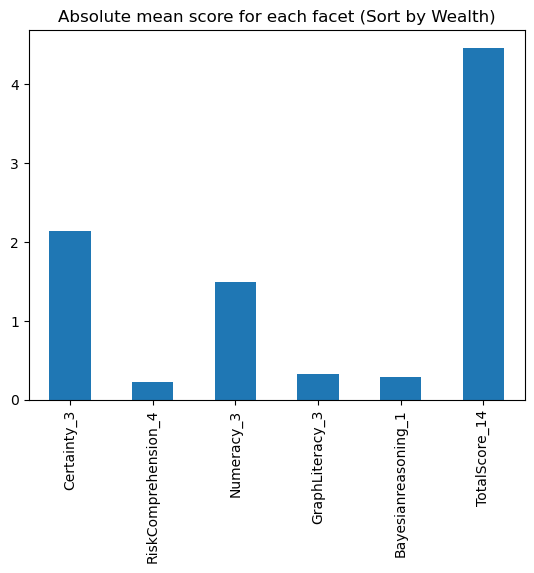

In [74]:
# Absolute mean score for each facet (Sort by Wealth)

df4[['Certainty_3','RiskComprehension_4','Numeracy_3','GraphLiteracy_3','Bayesianreasoning_1','TotalScore_14']].mean(axis = 0).plot(kind = 'bar', title = 'Absolute mean score for each facet (Sort by Wealth)')

<Axes: title={'center': 'Normalised mean score for each facet (Sort by Wealth)'}>

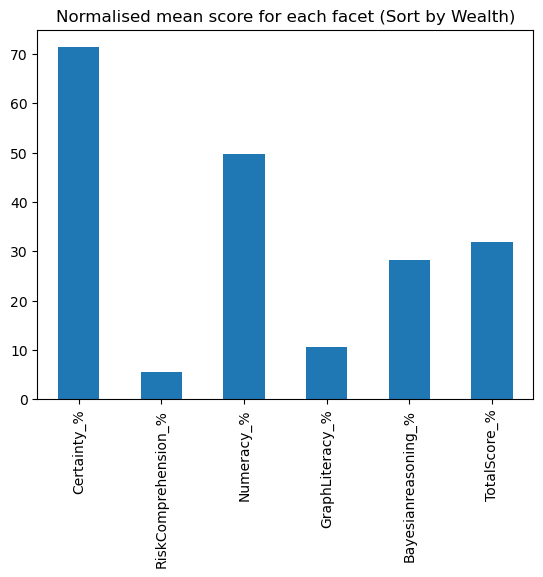

In [75]:
# Normalised mean score for each facet (Sort by Wealth)

(df4[['Certainty_%','RiskComprehension_%','Numeracy_%','GraphLiteracy_%','Bayesianreasoning_%','TotalScore_%']].mean(axis = 0)).plot(kind = 'bar', title = 'Normalised mean score for each facet (Sort by Wealth)')

<Axes: title={'center': 'Total responses line plot sorted by Wealth'}, xlabel='Unique responses sorted by wealth', ylabel='TotalScore_14'>

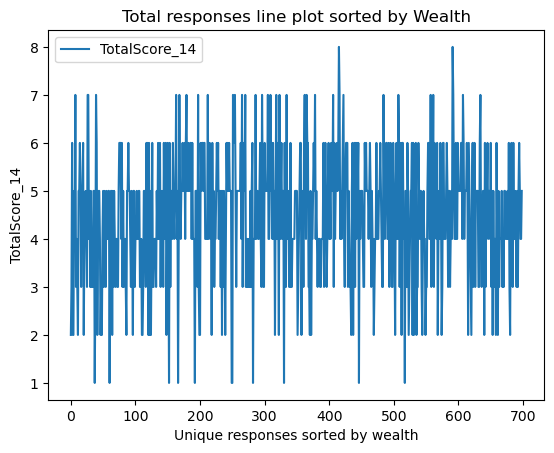

In [76]:
# Line Plot of Absolute Total Facet score vs sorted wealth

df4.plot(use_index = 'True' , kind = 'line', y = ['TotalScore_14'], title = 'Total responses line plot sorted by Wealth',xlabel = 'Unique responses sorted by wealth', ylabel = 'TotalScore_14')

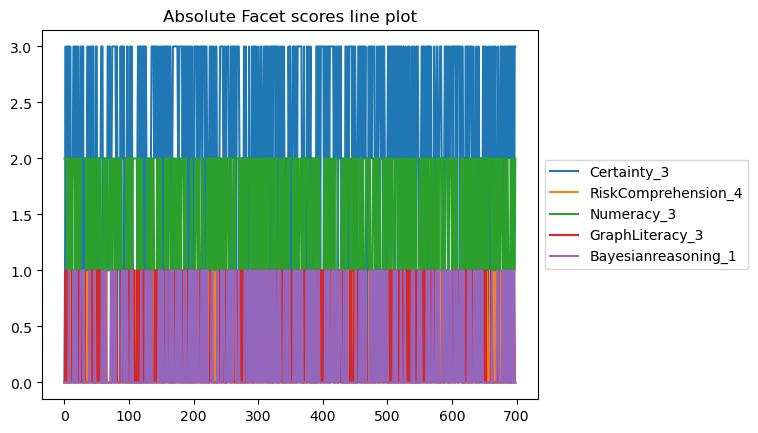

In [77]:
# Absolute Facet scores line plot from low to high wealth 
# I do understand that this is non readable

df4[['Certainty_3','RiskComprehension_4','Numeracy_3','GraphLiteracy_3','Bayesianreasoning_1']].plot( kind = 'line', title = 'Absolute Facet scores line plot', use_index = True).legend(loc='center left',bbox_to_anchor=(1.0, 0.5))

<Axes: ylabel='TotalScore_14'>

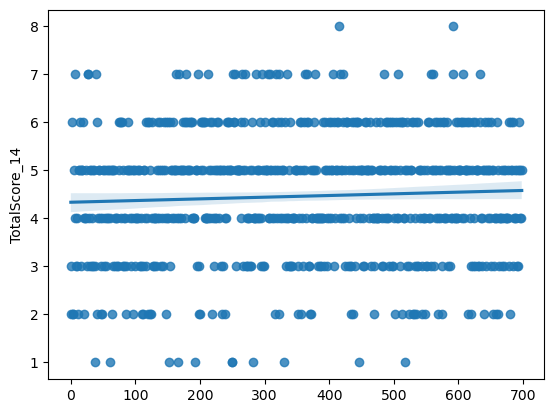

In [78]:
# Trend line for Absolute Total Facet Score vs unique wealth reponses

sns.regplot (data = df4, x = df4.index, y = 'TotalScore_14')

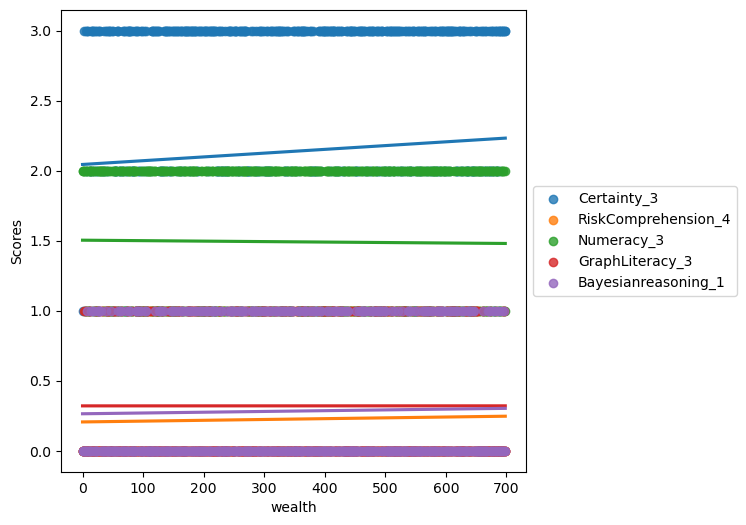

In [79]:
# Trend line for Absolute Independent Facet Score vs wealth reponses

fig1, ax1 = plt.subplots(figsize=(6, 6))

sns.regplot (data = df4, x = df4.index, y = 'Certainty_3', fit_reg=True, ci=None, ax=ax1, label='Certainty_3')
sns.regplot (data = df4, x = df4.index, y = 'RiskComprehension_4', fit_reg=True, ci=None, ax=ax1, label='RiskComprehension_4')
sns.regplot (data = df4, x = df4.index, y = 'Numeracy_3', fit_reg=True, ci=None, ax=ax1, label='Numeracy_3')
sns.regplot (data = df4, x = df4.index, y = 'GraphLiteracy_3', fit_reg=True, ci=None, ax=ax1, label='GraphLiteracy_3')
sns.regplot (data = df4, x = df4.index, y = 'Bayesianreasoning_1',fit_reg=True, ci=None, ax=ax1, label='Bayesianreasoning_1' )

ax1.set(ylabel='Scores', xlabel='wealth')
ax1.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

In [80]:
# Count of number of responses under each quartile

df4.groupby('Quartile Number')[['Quartile Number']].count()

Quartile Number
Quartile Number                 
1                            224
2                            129
3                            173
4                            173

In [81]:
df4.loc[df4['Quartile Number']==1]

ResponseId  age  age_rec  isced  income wealth  Certainty_3  \
0            48   29        2      2       1      0            0   
1           291   28        2      3       1      0            1   
2           676   52        3      1       3      0            3   
3           543   69        4      2       1      0            0   
4           316   46        3      3       1      0            1   
..          ...  ...      ...    ...     ...    ...          ...   
676         683   35        2      1       1  80000            3   
677         244   34        2      2       3  80000            2   
678         679   40        3      1       5  80000            3   
689         628   27        2      1       5  89000            3   
690         367   42        3      3       1      9            2   

     RiskComprehension_4  GraphLiteracy_3  Numeracy_3  Bayesianreasoning_1  \
0                      0                0           2                    0   
1                      0                0           2                    0   
2                      0                1           2                    0   
3                      0                0           2                    0   
4                      0                0           1                    0   
..                   ...              ...         ...                  ...   
676                    0                0           2                    0   
677                    0                0           2                    0   
678                    0                0           2                    1   
689                    0                0           1                    0   
690                    0                0           1                    0   

     Certainty_%  RiskComprehension_%  GraphLiteracy_%  Numeracy_%  \
0       0.000000                  0.0         0.000000   66.666667   
1      33.333333                  0.0         0.000000   66.666667   
2     100.000000                  0.0        33.333333   66.666667   
3       0.000000                  0.0         0.000000   66.666667   
4      33.333333                  0.0         0.000000   33.333333   
..           ...                  ...              ...         ...   
676   100.000000                  0.0         0.000000   66.666667   
677    66.666667                  0.0         0.000000   66.666667   
678   100.000000                  0.0         0.000000   66.666667   
689   100.000000                  0.0         0.000000   33.333333   
690    66.666667                  0.0         0.000000   33.333333   

     Bayesianreasoning_%  TotalScore_14  TotalScore_%  Quartile Number  
0                    0.0              2     14.285714                1  
1                    0.0              3     21.428571                1  
2                    0.0              6     42.857143                1  
3                    0.0              2     14.285714                1  
4                    0.0              2     14.285714                1  
..                   ...            ...           ...              ...  
676                  0.0              5     35.714286                1  
677                  0.0              4     28.571429                1  
678                100.0              6     42.857143                1  
689                  0.0              4     28.571429                1  
690                  0.0              3     21.428571                1  

[224 rows x 19 columns]

<Axes: title={'center': 'Total Score line plot sorted by Wealth Q1'}, xlabel='Unique responses', ylabel='TotalScore_14'>

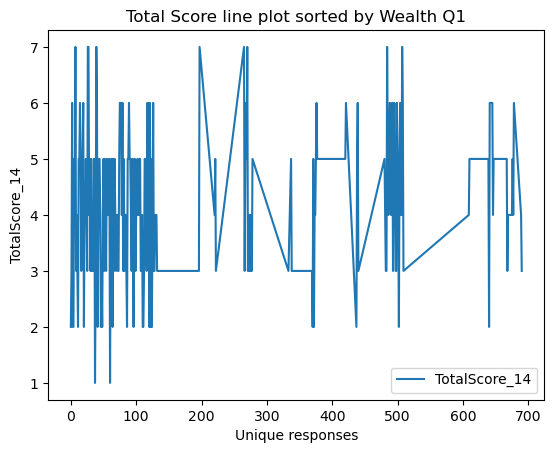

In [82]:
# This graph is basically a line plot of the TotalScore_14 across first quartile unique responses which are ordered by income

df4.loc[df4['Quartile Number']==1].plot(use_index = 'True' , kind = 'line', y = ['TotalScore_14'], title = 'Total Score line plot sorted by Wealth Q1',xlabel = 'Unique responses', ylabel = 'TotalScore_14')

<Axes: ylabel='TotalScore_14'>

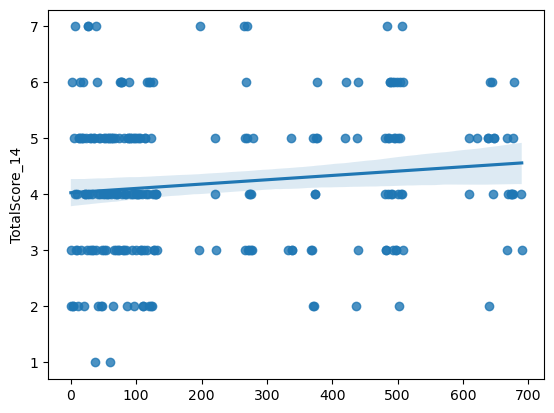

In [83]:
# Trend line for Absolute Total Facet Score vs unique Q14. Income reponses in Quartile 1

sns.regplot (data = df4.loc[df4['Quartile Number']==1], x = df4.loc[df4['Quartile Number']==1].index, y = 'TotalScore_14')

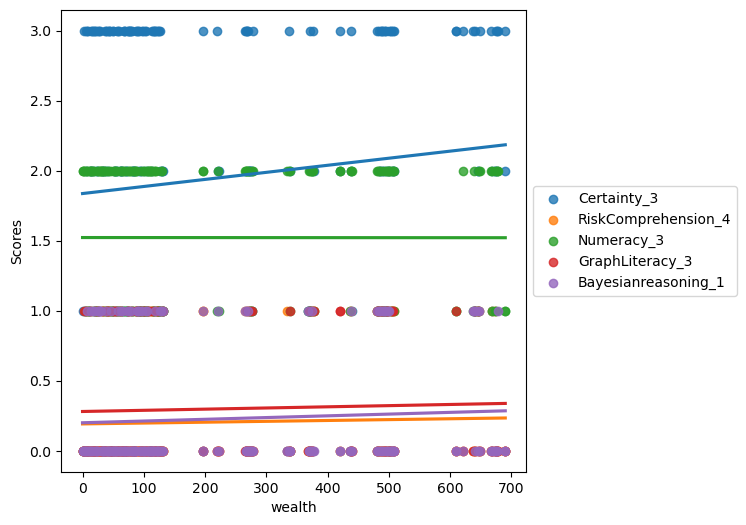

In [84]:
# Trend line for Absolute Independent Facet Score vs wealth reponses in Quartile 1

fig1, ax2 = plt.subplots(figsize=(6, 6))

sns.regplot (data = df4.loc[df4['Quartile Number']==1], x = df4.loc[df4['Quartile Number']==1].index, y = 'Certainty_3', fit_reg=True, ci=None, ax=ax2, label='Certainty_3')
sns.regplot (data = df4.loc[df4['Quartile Number']==1], x = df4.loc[df4['Quartile Number']==1].index, y = 'RiskComprehension_4', fit_reg=True, ci=None, ax=ax2, label='RiskComprehension_4')
sns.regplot (data = df4.loc[df4['Quartile Number']==1], x = df4.loc[df4['Quartile Number']==1].index, y = 'Numeracy_3', fit_reg=True, ci=None, ax=ax2, label='Numeracy_3')
sns.regplot (data = df4.loc[df4['Quartile Number']==1], x = df4.loc[df4['Quartile Number']==1].index, y = 'GraphLiteracy_3', fit_reg=True, ci=None, ax=ax2, label='GraphLiteracy_3')
sns.regplot (data = df4.loc[df4['Quartile Number']==1], x = df4.loc[df4['Quartile Number']==1].index, y = 'Bayesianreasoning_1',fit_reg=True, ci=None, ax=ax2, label='Bayesianreasoning_1' )

ax2.set(ylabel='Scores', xlabel='wealth')
ax2.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

In [85]:
df4.loc[df4['Quartile Number']==2]

ResponseId  age  age_rec  isced  income  wealth  Certainty_3  \
198         309   30        2      3       3  120000            1   
199         448   27        2      2       3  120000            1   
200         392   21        2      3       1  120000            1   
216         280   28        2      2       2  140000            3   
217         363   20        2      3       2  140000            3   
..          ...  ...      ...    ...     ...     ...          ...   
620         200   62        4      2       2  579000            0   
622         544   26        2      2       1  600000            3   
623         210   19        2      3       2  600000            2   
624         265   40        3      2       1  600000            3   
625         616   46        3      1       2  600000            3   

     RiskComprehension_4  GraphLiteracy_3  Numeracy_3  Bayesianreasoning_1  \
198                    0                1           1                    0   
199                    0                0           1                    0   
200                    0                0           1                    0   
216                    0                0           1                    0   
217                    0                0           1                    1   
..                   ...              ...         ...                  ...   
620                    0                1           1                    0   
622                    1                1           1                    0   
623                    0                0           1                    0   
624                    0                0           1                    0   
625                    0                0           2                    1   

     Certainty_%  RiskComprehension_%  GraphLiteracy_%  Numeracy_%  \
198    33.333333                  0.0        33.333333   33.333333   
199    33.333333                  0.0         0.000000   33.333333   
200    33.333333                  0.0         0.000000   33.333333   
216   100.000000                  0.0         0.000000   33.333333   
217   100.000000                  0.0         0.000000   33.333333   
..           ...                  ...              ...         ...   
620     0.000000                  0.0        33.333333   33.333333   
622   100.000000                 25.0        33.333333   33.333333   
623    66.666667                  0.0         0.000000   33.333333   
624   100.000000                  0.0         0.000000   33.333333   
625   100.000000                  0.0         0.000000   66.666667   

     Bayesianreasoning_%  TotalScore_14  TotalScore_%  Quartile Number  
198                  0.0              3     21.428571                2  
199                  0.0              2     14.285714                2  
200                  0.0              2     14.285714                2  
216                  0.0              4     28.571429                2  
217                100.0              5     35.714286                2  
..                   ...            ...           ...              ...  
620                  0.0              2     14.285714                2  
622                  0.0              6     42.857143                2  
623                  0.0              3     21.428571                2  
624                  0.0              4     28.571429                2  
625                100.0              6     42.857143                2  

[129 rows x 19 columns]

<Axes: title={'center': 'Total Score line plot sorted by Wealth Q1'}, xlabel='Unique responses', ylabel='TotalScore_14'>

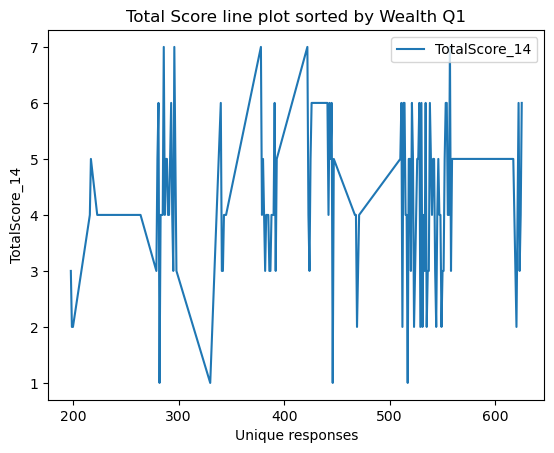

In [86]:
# This graph is basically a line plot of the TotalScore_14 across second quartile unique responses which are ordered by income

df4.loc[df4['Quartile Number']==2].plot(use_index = 'True' , kind = 'line', y = ['TotalScore_14'], title = 'Total Score line plot sorted by Wealth Q1',xlabel = 'Unique responses', ylabel = 'TotalScore_14')

<Axes: ylabel='TotalScore_14'>

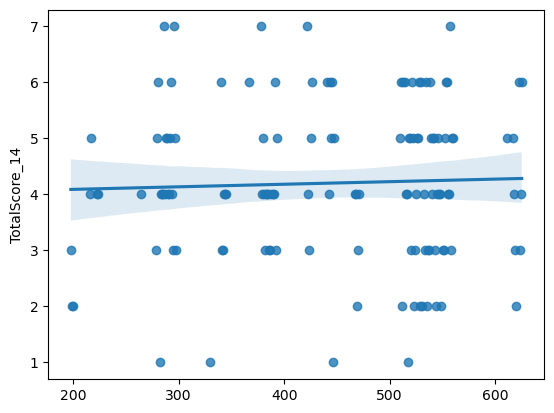

In [87]:
# Trend line for Absolute Total Facet Score vs unique wealth reponses in Quartile 2

sns.regplot (data = df4.loc[df4['Quartile Number']==2], x = df4.loc[df4['Quartile Number']==2].index, y = 'TotalScore_14')

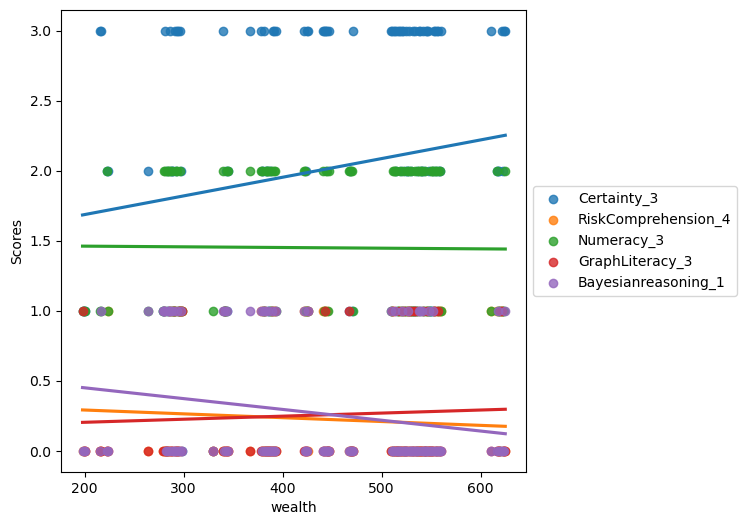

In [88]:
# Trend line for Absolute Independent Facet Score vs wealth reponses in Quartile 2

fig1, ax3 = plt.subplots(figsize=(6, 6))

sns.regplot (data = df4.loc[df4['Quartile Number']==2], x = df4.loc[df4['Quartile Number']==2].index, y = 'Certainty_3', fit_reg=True, ci=None, ax=ax3, label='Certainty_3')
sns.regplot (data = df4.loc[df4['Quartile Number']==2], x = df4.loc[df4['Quartile Number']==2].index, y = 'RiskComprehension_4', fit_reg=True, ci=None, ax=ax3, label='RiskComprehension_4')
sns.regplot (data = df4.loc[df4['Quartile Number']==2], x = df4.loc[df4['Quartile Number']==2].index, y = 'Numeracy_3', fit_reg=True, ci=None, ax=ax3, label='Numeracy_3')
sns.regplot (data = df4.loc[df4['Quartile Number']==2], x = df4.loc[df4['Quartile Number']==2].index, y = 'GraphLiteracy_3', fit_reg=True, ci=None, ax=ax3, label='GraphLiteracy_3')
sns.regplot (data = df4.loc[df4['Quartile Number']==2], x = df4.loc[df4['Quartile Number']==2].index, y = 'Bayesianreasoning_1',fit_reg=True, ci=None, ax=ax3, label='Bayesianreasoning_1' )

ax3.set(ylabel='Scores', xlabel='wealth')
ax3.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

In [89]:
df4.loc[df4['Quartile Number']==3]

ResponseId  age  age_rec  isced  income   wealth  Certainty_3  \
133         519   22        2      2       1  1000000            2   
134         371   46        3      3       3  1000000            2   
135         114   38        3      1       4  1000000            3   
136          44   26        2      2       3  1000000            3   
137         612   26        2      1       3  1000000            3   
..          ...  ...      ...    ...     ...      ...          ...   
681         680   40        3      1       5   800000            3   
682         521   28        2      2       2   800000            3   
683         209   23        2      2       2   800000            2   
691         574   52        3      1       1   900000            3   
697         190   34        2      2       2   950000            3   

     RiskComprehension_4  GraphLiteracy_3  Numeracy_3  Bayesianreasoning_1  \
133                    1                0           2                    0   
134                    1                0           1                    0   
135                    0                0           2                    1   
136                    0                0           1                    0   
137                    0                0           2                    0   
..                   ...              ...         ...                  ...   
681                    0                0           1                    1   
682                    1                0           2                    0   
683                    1                0           2                    0   
691                    0                0           2                    0   
697                    0                0           1                    0   

     Certainty_%  RiskComprehension_%  GraphLiteracy_%  Numeracy_%  \
133    66.666667                 25.0              0.0   66.666667   
134    66.666667                 25.0              0.0   33.333333   
135   100.000000                  0.0              0.0   66.666667   
136   100.000000                  0.0              0.0   33.333333   
137   100.000000                  0.0              0.0   66.666667   
..           ...                  ...              ...         ...   
681   100.000000                  0.0              0.0   33.333333   
682   100.000000                 25.0              0.0   66.666667   
683    66.666667                 25.0              0.0   66.666667   
691   100.000000                  0.0              0.0   66.666667   
697   100.000000                  0.0              0.0   33.333333   

     Bayesianreasoning_%  TotalScore_14  TotalScore_%  Quartile Number  
133                  0.0              5     35.714286                3  
134                  0.0              4     28.571429                3  
135                100.0              6     42.857143                3  
136                  0.0              4     28.571429                3  
137                  0.0              5     35.714286                3  
..                   ...            ...           ...              ...  
681                100.0              5     35.714286                3  
682                  0.0              6     42.857143                3  
683                  0.0              5     35.714286                3  
691                  0.0              5     35.714286                3  
697                  0.0              4     28.571429                3  

[173 rows x 19 columns]

<Axes: title={'center': 'Total Score line plot sorted by Wealth Q3'}, xlabel='Unique responses', ylabel='TotalScore_14'>

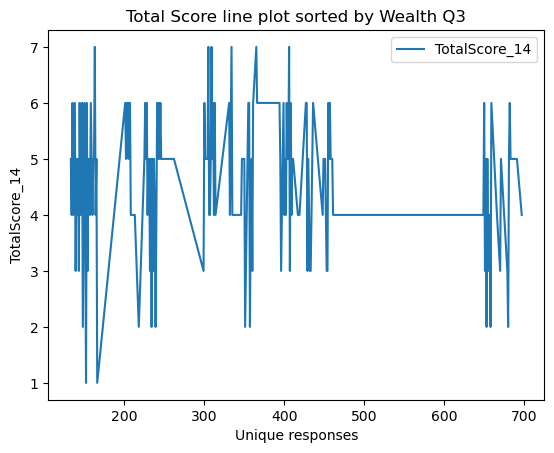

In [90]:
# This graph is basically a line plot of the TotalScore_14 across third quartile unique responses which are ordered by wealth

df4.loc[df4['Quartile Number']==3].plot(use_index = 'True' , kind = 'line', y = ['TotalScore_14'], title = 'Total Score line plot sorted by Wealth Q3',xlabel = 'Unique responses', ylabel = 'TotalScore_14')

<Axes: ylabel='TotalScore_14'>

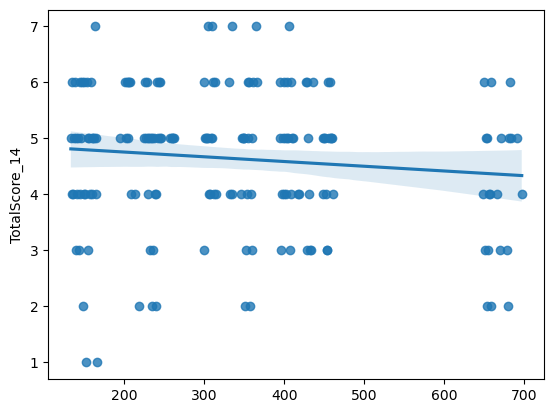

In [91]:
# Trend line for Absolute Total Facet Score vs unique wealth reponses in Quartile 3

sns.regplot (data = df4.loc[df4['Quartile Number']==3], x = df4.loc[df4['Quartile Number']==3].index, y = 'TotalScore_14')

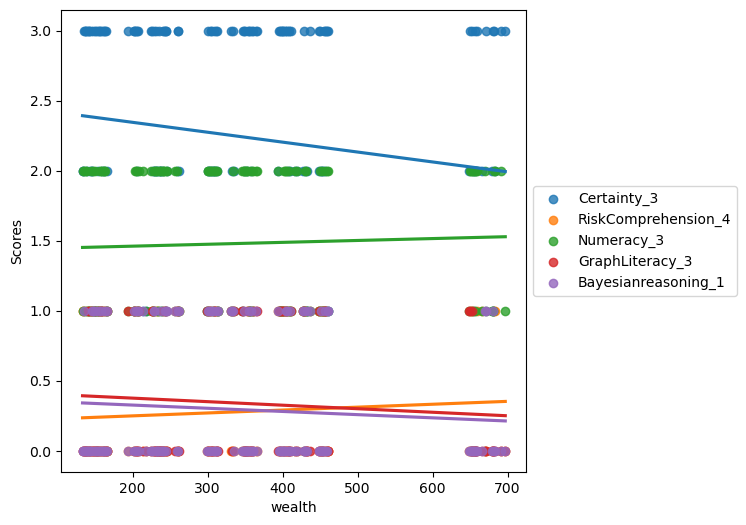

In [92]:
# Trend line for Absolute Independent Facet Score vs wealth reponses in Quartile 3

fig1, ax4 = plt.subplots(figsize=(6, 6))

sns.regplot (data = df4.loc[df4['Quartile Number']==3], x = df4.loc[df4['Quartile Number']==3].index, y = 'Certainty_3', fit_reg=True, ci=None, ax=ax4, label='Certainty_3')
sns.regplot (data = df4.loc[df4['Quartile Number']==3], x = df4.loc[df4['Quartile Number']==3].index, y = 'RiskComprehension_4', fit_reg=True, ci=None, ax=ax4, label='RiskComprehension_4')
sns.regplot (data = df4.loc[df4['Quartile Number']==3], x = df4.loc[df4['Quartile Number']==3].index, y = 'Numeracy_3', fit_reg=True, ci=None, ax=ax4, label='Numeracy_3')
sns.regplot (data = df4.loc[df4['Quartile Number']==3], x = df4.loc[df4['Quartile Number']==3].index, y = 'GraphLiteracy_3', fit_reg=True, ci=None, ax=ax4, label='GraphLiteracy_3')
sns.regplot (data = df4.loc[df4['Quartile Number']==3], x = df4.loc[df4['Quartile Number']==3].index, y = 'Bayesianreasoning_1',fit_reg=True, ci=None, ax=ax4, label='Bayesianreasoning_1' )

ax4.set(ylabel='Scores', xlabel='wealth')
ax4.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

In [93]:
df4.loc[df4['Quartile Number']==4]

ResponseId  age  age_rec  isced  income    wealth  Certainty_3  \
167         503   30        2      2       3  10000000            2   
168         641   35        2      1       6  10000000            3   
169          23   25        2      2       3  10000000            3   
170         250   32        2      2       4  10000000            3   
171         101   27        2      2       2  10000000            3   
..          ...  ...      ...    ...     ...       ...          ...   
693         204   34        2      2       3   9000000            3   
694           1   53        3      1       4   9000000            3   
695         518   34        2      2       3   9000000            3   
696         623   31        2      1       6  90000000            0   
698         571   30        2      1       3   9500000            3   

     RiskComprehension_4  GraphLiteracy_3  Numeracy_3  Bayesianreasoning_1  \
167                    0                0           2                    0   
168                    1                0           2                    1   
169                    0                0           2                    0   
170                    0                0           1                    0   
171                    0                0           2                    0   
..                   ...              ...         ...                  ...   
693                    0                0           2                    0   
694                    1                0           2                    0   
695                    0                0           2                    0   
696                    1                1           1                    1   
698                    0                0           2                    0   

     Certainty_%  RiskComprehension_%  GraphLiteracy_%  Numeracy_%  \
167    66.666667                  0.0         0.000000   66.666667   
168   100.000000                 25.0         0.000000   66.666667   
169   100.000000                  0.0         0.000000   66.666667   
170   100.000000                  0.0         0.000000   33.333333   
171   100.000000                  0.0         0.000000   66.666667   
..           ...                  ...              ...         ...   
693   100.000000                  0.0         0.000000   66.666667   
694   100.000000                 25.0         0.000000   66.666667   
695   100.000000                  0.0         0.000000   66.666667   
696     0.000000                 25.0        33.333333   33.333333   
698   100.000000                  0.0         0.000000   66.666667   

     Bayesianreasoning_%  TotalScore_14  TotalScore_%  Quartile Number  
167                  0.0              4     28.571429                4  
168                100.0              7     50.000000                4  
169                  0.0              5     35.714286                4  
170                  0.0              4     28.571429                4  
171                  0.0              5     35.714286                4  
..                   ...            ...           ...              ...  
693                  0.0              5     35.714286                4  
694                  0.0              6     42.857143                4  
695                  0.0              5     35.714286                4  
696                100.0              4     28.571429                4  
698                  0.0              5     35.714286                4  

[173 rows x 19 columns]

<Axes: title={'center': 'Total Score line plot sorted by Wealth Q4'}, xlabel='Unique responses', ylabel='TotalScore_14'>

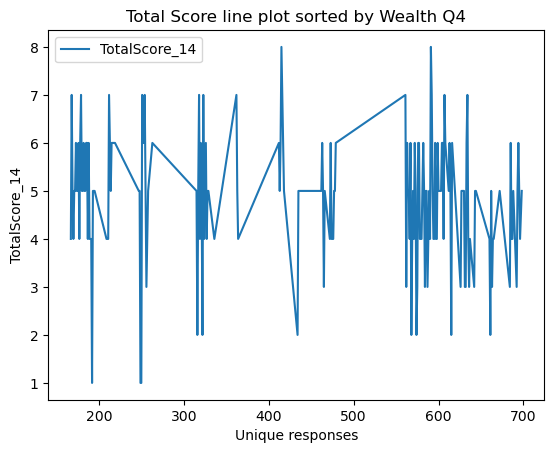

In [94]:
# This graph is basically a line plot of the TotalScore_14 across fourth quartile unique responses which are ordered by Wealth

df4.loc[df4['Quartile Number']==4].plot(use_index = 'True' , kind = 'line', y = ['TotalScore_14'], title = 'Total Score line plot sorted by Wealth Q4',xlabel = 'Unique responses', ylabel = 'TotalScore_14')

<Axes: ylabel='TotalScore_14'>

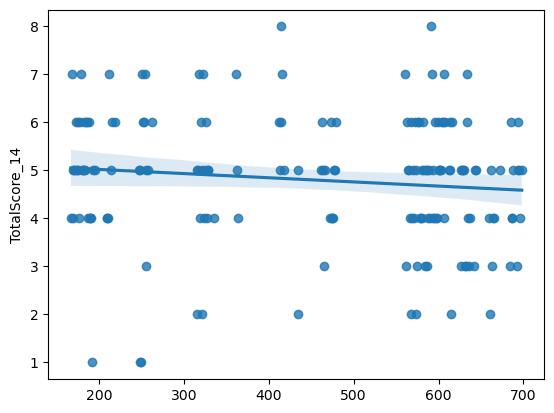

In [95]:
# Trend line for Absolute Total Facet Score vs unique wealth reponses in Quartile 4

sns.regplot (data = df4.loc[df4['Quartile Number']==4], x = df4.loc[df4['Quartile Number']==4].index, y = 'TotalScore_14')

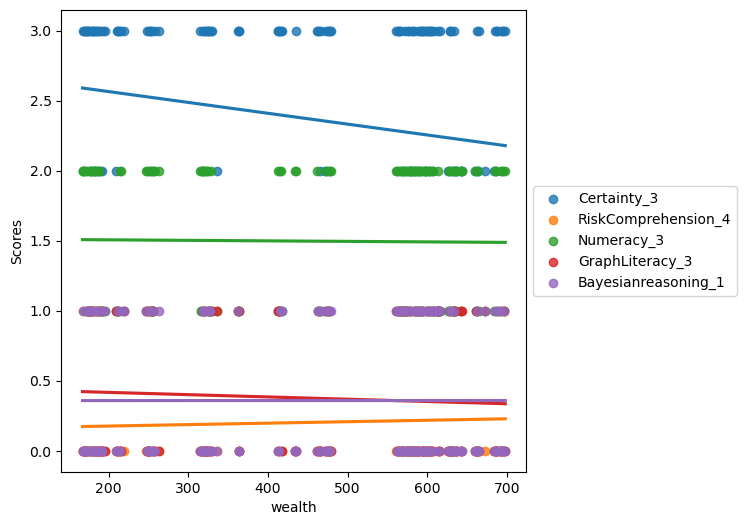

In [96]:
# Trend line for Absolute Independent Facet Score vs wealth reponses in Quartile 4

fig1, ax5 = plt.subplots(figsize=(6, 6))

sns.regplot (data = df4.loc[df4['Quartile Number']==4], x = df4.loc[df4['Quartile Number']==4].index, y = 'Certainty_3', fit_reg=True, ci=None, ax=ax5, label='Certainty_3')
sns.regplot (data = df4.loc[df4['Quartile Number']==4], x = df4.loc[df4['Quartile Number']==4].index, y = 'RiskComprehension_4', fit_reg=True, ci=None, ax=ax5, label='RiskComprehension_4')
sns.regplot (data = df4.loc[df4['Quartile Number']==4], x = df4.loc[df4['Quartile Number']==4].index, y = 'Numeracy_3', fit_reg=True, ci=None, ax=ax5, label='Numeracy_3')
sns.regplot (data = df4.loc[df4['Quartile Number']==4], x = df4.loc[df4['Quartile Number']==4].index, y = 'GraphLiteracy_3', fit_reg=True, ci=None, ax=ax5, label='GraphLiteracy_3')
sns.regplot (data = df4.loc[df4['Quartile Number']==4], x = df4.loc[df4['Quartile Number']==4].index, y = 'Bayesianreasoning_1',fit_reg=True, ci=None, ax=ax5, label='Bayesianreasoning_1' )

ax5.set(ylabel='Scores', xlabel='wealth')
ax5.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

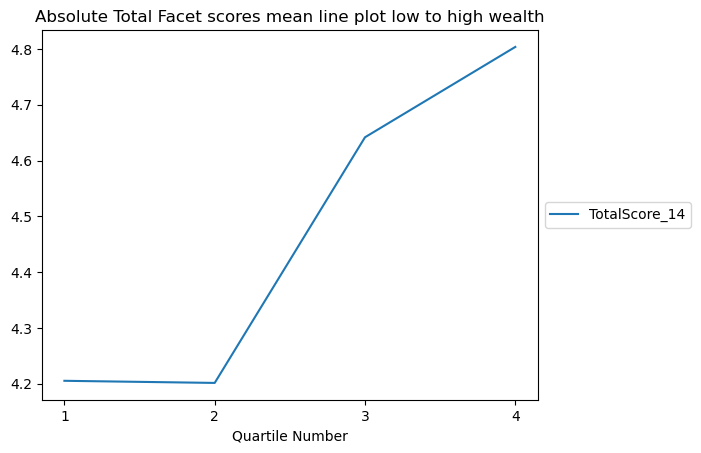

In [97]:
# Absolute Total Facet scores mean line plot from low to high Wealth

df4.groupby('Quartile Number')[['TotalScore_14']].mean().plot( kind = 'line', title = 'Absolute Total Facet scores mean line plot low to high wealth', xticks = np.arange(1,5,step = 1)).legend(loc='center left',bbox_to_anchor=(1.0, 0.5))

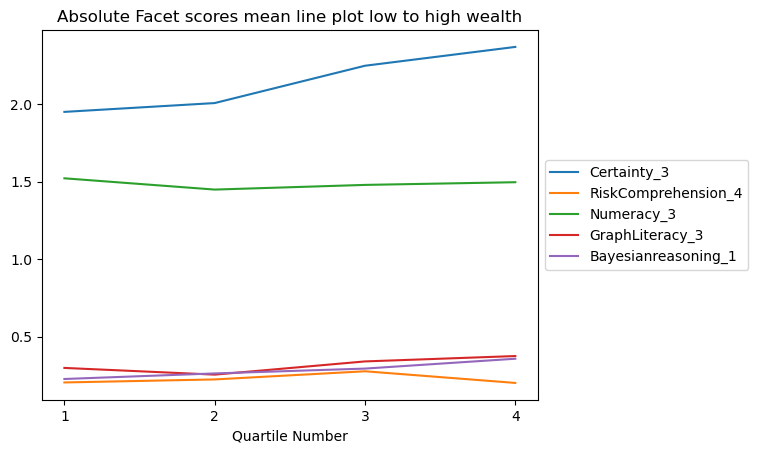

In [98]:
# Absolute Facet scores mean line plot from low to high wealth

df4.groupby('Quartile Number')[['Certainty_3','RiskComprehension_4','Numeracy_3','GraphLiteracy_3','Bayesianreasoning_1']].mean().plot( kind = 'line', title = 'Absolute Facet scores mean line plot low to high wealth', xticks = np.arange(1,5,step = 1)).legend(loc='center left',bbox_to_anchor=(1.0, 0.5))

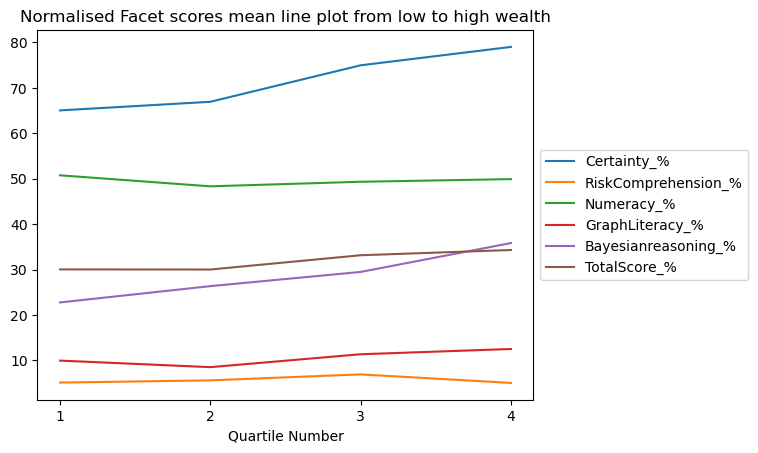

In [99]:
# Normalised Facet scores mean line plot from low to high wealth


df4.groupby('Quartile Number')[['Certainty_%','RiskComprehension_%','Numeracy_%','GraphLiteracy_%','Bayesianreasoning_%','TotalScore_%']].mean().plot( kind = 'line', title = 'Normalised Facet scores mean line plot from low to high wealth',  xticks = np.arange(1,5,step = 1)).legend(loc='center left',bbox_to_anchor=(1.0, 0.5))

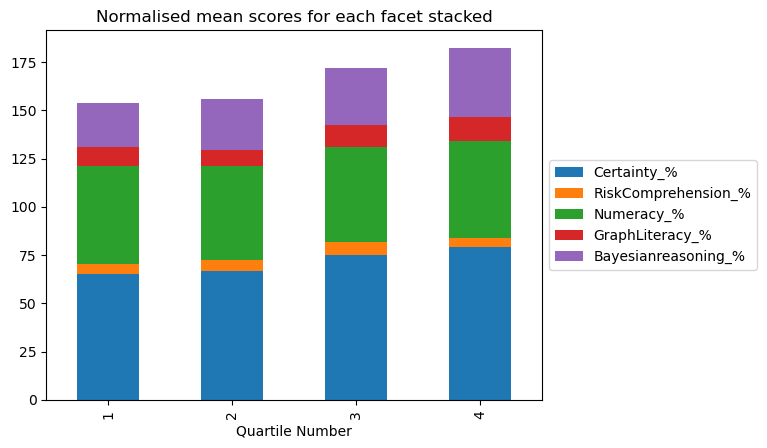

In [100]:
# Normalised mean scores for each facet stacked

df4.groupby('Quartile Number')[['Certainty_%','RiskComprehension_%','Numeracy_%','GraphLiteracy_%','Bayesianreasoning_%']].mean().plot( kind = 'bar', title = 'Normalised mean scores for each facet stacked', stacked = True).legend(loc='center left',bbox_to_anchor=(1.0, 0.5))

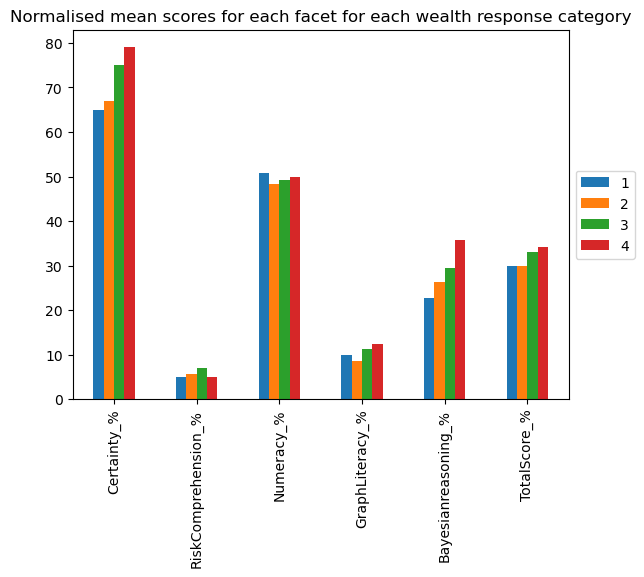

In [101]:
# Normalised mean scores for each facet for each wealth response Quartile

df4.groupby('Quartile Number')[['Certainty_%','RiskComprehension_%','Numeracy_%','GraphLiteracy_%','Bayesianreasoning_%','TotalScore_%']].mean().T.plot(kind = 'bar', title = 'Normalised mean scores for each facet for each wealth response category').legend(loc='center left',bbox_to_anchor=(1.0, 0.5))

<Axes: xlabel='Quartile Number', ylabel='TotalScore_14'>

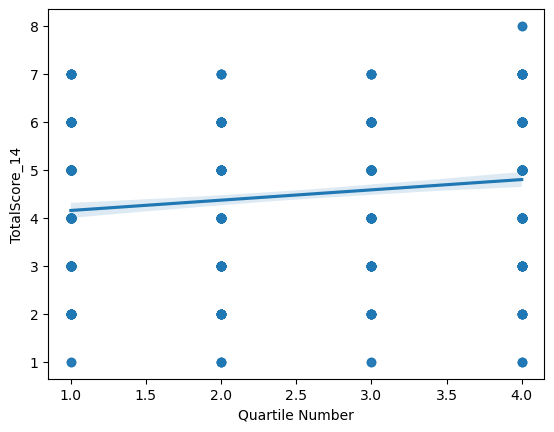

In [102]:
# Trend line for Absolute Total Facet Score vs Quartiles

sns.regplot (data = df4, x = 'Quartile Number', y = 'TotalScore_14')

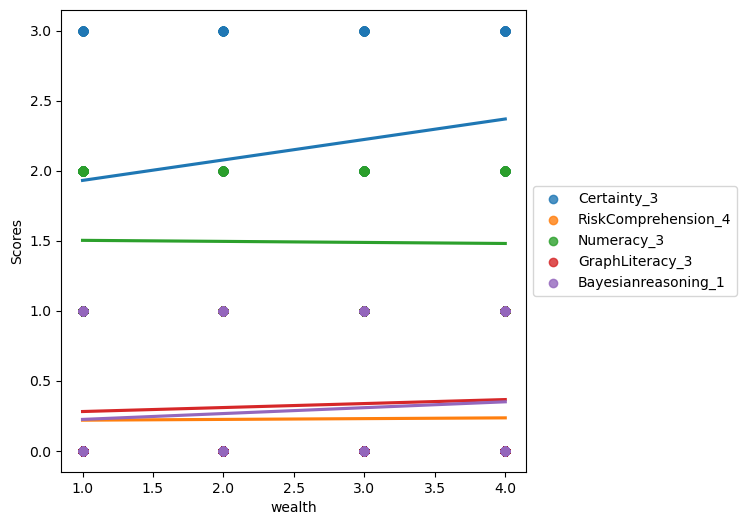

In [103]:
# Trend line for Absolute Independent Facet Score vs Quartiles

fig2, ax2 = plt.subplots(figsize=(6, 6))

sns.regplot (data = df4, x = 'Quartile Number', y = 'Certainty_3', fit_reg=True, ci=None, ax=ax2, label='Certainty_3')
sns.regplot (data = df4, x = 'Quartile Number', y = 'RiskComprehension_4', fit_reg=True, ci=None, ax=ax2, label='RiskComprehension_4')
sns.regplot (data = df4, x = 'Quartile Number', y = 'Numeracy_3', fit_reg=True, ci=None, ax=ax2, label='Numeracy_3')
sns.regplot (data = df4, x = 'Quartile Number', y = 'GraphLiteracy_3', fit_reg=True, ci=None, ax=ax2, label='GraphLiteracy_3')
sns.regplot (data = df4, x = 'Quartile Number', y = 'Bayesianreasoning_1',fit_reg=True, ci=None, ax=ax2, label='Bayesianreasoning_1' )

ax2.set(ylabel='Scores', xlabel='wealth')
ax2.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

<Axes: xlabel='Quartile Number', ylabel='TotalScore_14'>

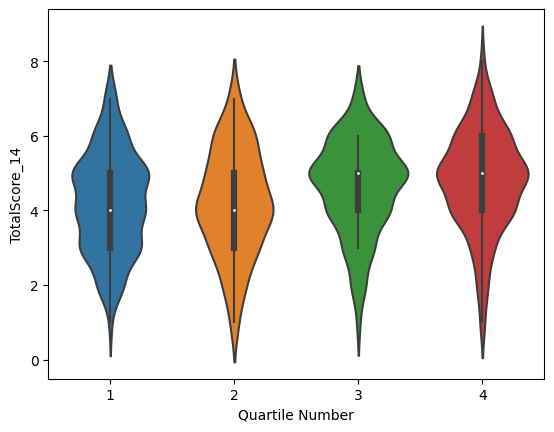

In [104]:
# Violine Plot for TotalScore_14 for each entry under Wealth Quartiles.

sns.violinplot( data = df4, x = 'Quartile Number', y = 'TotalScore_14')

<Axes: xlabel='Quartile Number', ylabel='Certainty_3'>

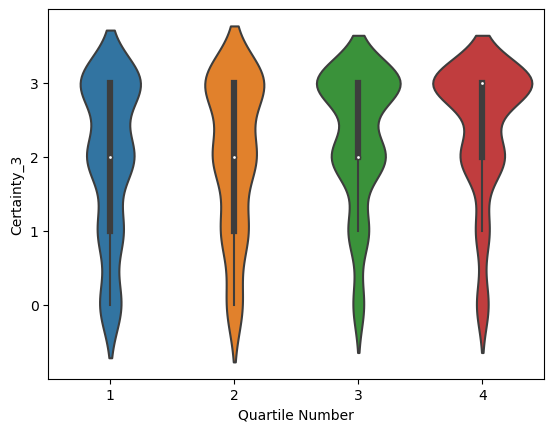

In [105]:
# Violine Plot for Certainty_3 for each entry under Wealth Quartiles.

sns.violinplot( data = df4, x = 'Quartile Number', y = 'Certainty_3')

<Axes: xlabel='Quartile Number', ylabel='RiskComprehension_4'>

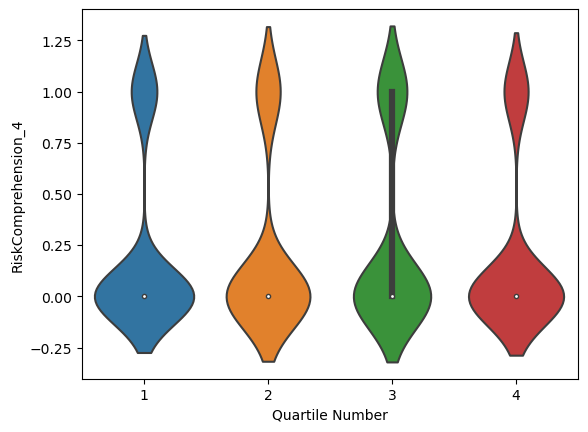

In [106]:
# Violine Plot for RiskComprehension_4 for each entry under Wealth Quartiles.

sns.violinplot( data = df4, x = 'Quartile Number', y = 'RiskComprehension_4')

<Axes: xlabel='Quartile Number', ylabel='GraphLiteracy_3'>

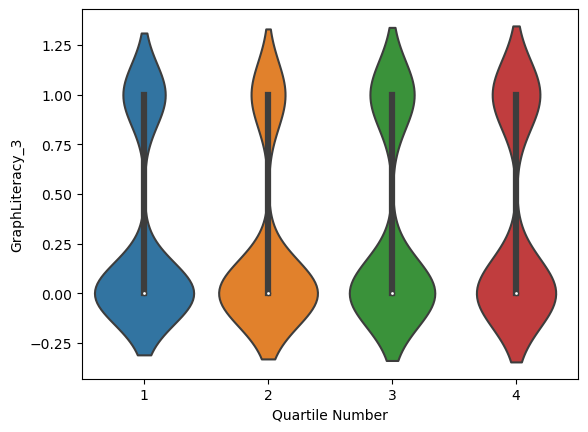

In [107]:
# Violine Plot for GraphLiteracy_3 for each entry under Wealth Quartiles.

sns.violinplot( data = df4, x = 'Quartile Number', y = 'GraphLiteracy_3')

<Axes: xlabel='Quartile Number', ylabel='Numeracy_3'>

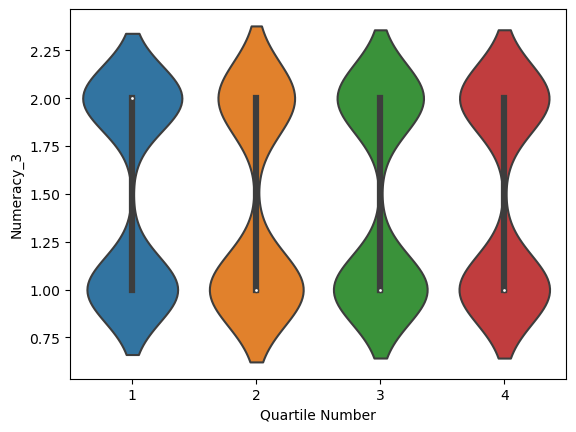

In [108]:
# Violine Plot for Numeracy_3 for each entry under Wealth Quartiles.

sns.violinplot( data = df4, x = 'Quartile Number', y = 'Numeracy_3')

<Axes: xlabel='Quartile Number', ylabel='Bayesianreasoning_1'>

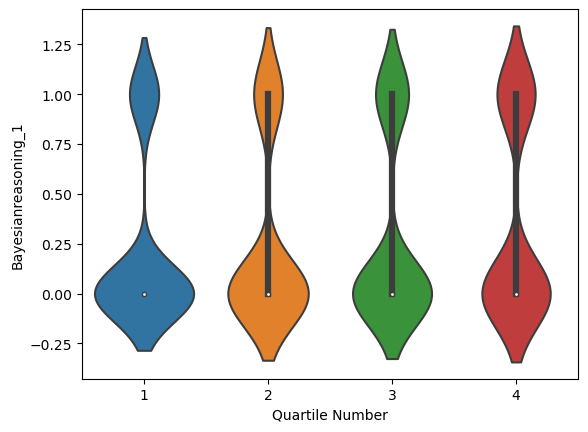

In [109]:
# Violine Plot for Bayesianreasoning_1 for each entry under Wealth Quartiles.

sns.violinplot( data = df4, x = 'Quartile Number', y = 'Bayesianreasoning_1')

In [110]:
# Data Frame 5 or df5 is an aggregate data on facet total scores and over all total score, along with  education data vs each response. 
# This data set is now sorted by education.

df5 = df2.sort_values(by = 'isced')
df5 = df5.reset_index(drop = True)

df5

ResponseId  age  age_rec  isced  income    wealth  Certainty_3  \
0             0   30        2      1       2   5000000            2   
1           599   35        2      1       3   2000000            3   
2           598   27        2      1       5  20000000            2   
3           597   45        3      1       3   5000000            2   
4           596   40        3      1       6    500000            2   
..          ...  ...      ...    ...     ...       ...          ...   
694         365   26        2      3       1   4000000            2   
695         364   28        2      3       3    100000            2   
696         363   20        2      3       2    140000            3   
697         361   75        4      3       1   2000000            2   
698         349   37        3      3       2  15000000            0   

     RiskComprehension_4  GraphLiteracy_3  Numeracy_3  Bayesianreasoning_1  \
0                      1                1           1                    0   
1                      1                0           2                    0   
2                      1                0           2                    0   
3                      0                0           2                    0   
4                      0                0           2                    1   
..                   ...              ...         ...                  ...   
694                    0                0           2                    0   
695                    0                0           1                    0   
696                    0                0           1                    1   
697                    0                1           2                    0   
698                    0                0           1                    0   

     Certainty_%  RiskComprehension_%  GraphLiteracy_%  Numeracy_%  \
0      66.666667                 25.0        33.333333   33.333333   
1     100.000000                 25.0         0.000000   66.666667   
2      66.666667                 25.0         0.000000   66.666667   
3      66.666667                  0.0         0.000000   66.666667   
4      66.666667                  0.0         0.000000   66.666667   
..           ...                  ...              ...         ...   
694    66.666667                  0.0         0.000000   66.666667   
695    66.666667                  0.0         0.000000   33.333333   
696   100.000000                  0.0         0.000000   33.333333   
697    66.666667                  0.0        33.333333   66.666667   
698     0.000000                  0.0         0.000000   33.333333   

     Bayesianreasoning_%  TotalScore_14  TotalScore_%  
0                    0.0              5     35.714286  
1                    0.0              6     42.857143  
2                    0.0              5     35.714286  
3                    0.0              4     28.571429  
4                  100.0              5     35.714286  
..                   ...            ...           ...  
694                  0.0              4     28.571429  
695                  0.0              3     21.428571  
696                100.0              5     35.714286  
697                  0.0              5     35.714286  
698                  0.0              1      7.142857  

[699 rows x 18 columns]

In [111]:
# since we didnt drop any values, the dataset is essentially the same as df2, but sorted

In [112]:
# Mean of each facet as a % for each category of isced

df5.groupby('isced')[['Certainty_%','RiskComprehension_%','Numeracy_%','GraphLiteracy_%','Bayesianreasoning_%']].mean()

Certainty_%  RiskComprehension_%  Numeracy_%  GraphLiteracy_%  \
isced                                                                  
1        76.058201             5.753968   50.264550        11.111111   
2        70.401107             5.601660   48.686030        10.650069   
3        66.504854             5.582524   50.323625        10.194175   

       Bayesianreasoning_%  
isced                       
1                32.142857  
2                26.141079  
3                26.213592

In [113]:
# Count of responses for each category isced

df5.groupby('isced')[['ResponseId']].count()

ResponseId
isced            
1             252
2             241
3             206

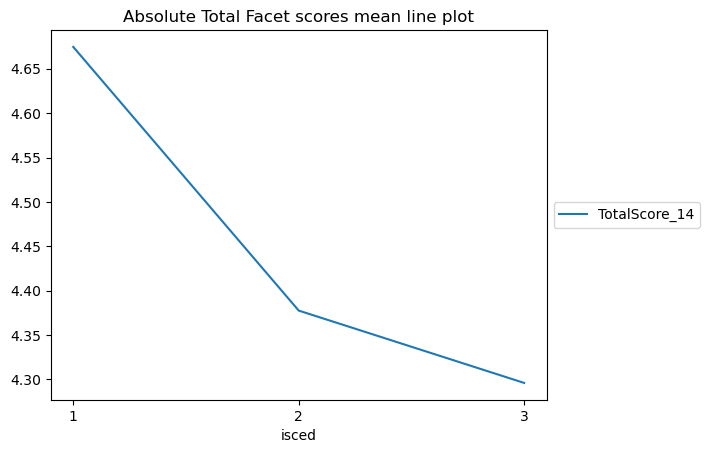

In [114]:
# Absolute Total Facet scores mean line plot from low to high education

df5.groupby('isced')[['TotalScore_14']].mean().plot( kind = 'line', title = 'Absolute Total Facet scores mean line plot', xticks = np.arange(1,4, step = 1)).legend(loc='center left',bbox_to_anchor=(1.0, 0.5))

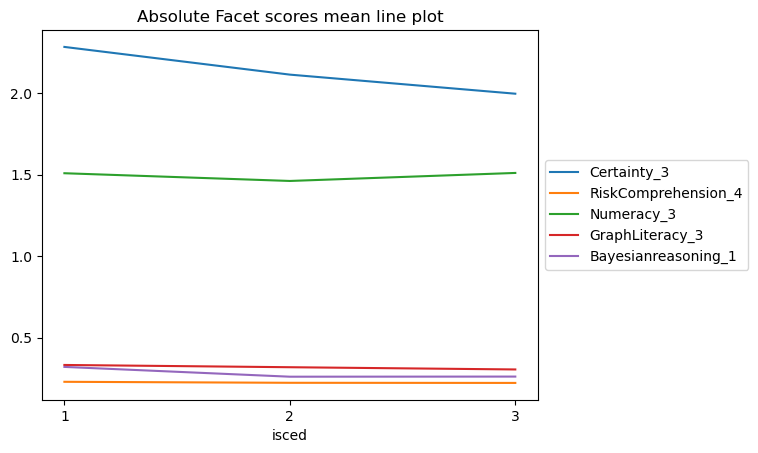

In [115]:
# Absolute Facet scores mean line plot from low to high edu

df5.groupby('isced')[['Certainty_3','RiskComprehension_4','Numeracy_3','GraphLiteracy_3','Bayesianreasoning_1']].mean().plot( kind = 'line', title = 'Absolute Facet scores mean line plot', xticks = np.arange(1,4, step = 1)).legend(loc='center left',bbox_to_anchor=(1.0, 0.5))

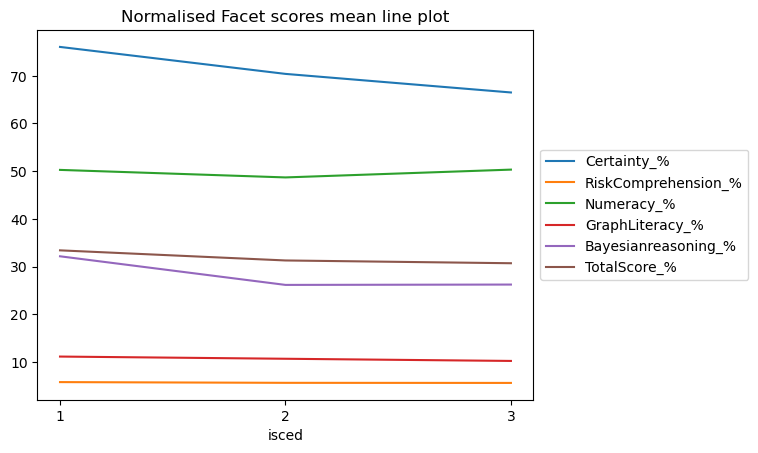

In [116]:
# Normalised Facet scores mean line plot from low to high edu


df5.groupby('isced')[['Certainty_%','RiskComprehension_%','Numeracy_%','GraphLiteracy_%','Bayesianreasoning_%','TotalScore_%']].mean().plot( kind = 'line', title = 'Normalised Facet scores mean line plot', xticks = np.arange(1,4, step = 1)).legend(loc='center left',bbox_to_anchor=(1.0, 0.5))

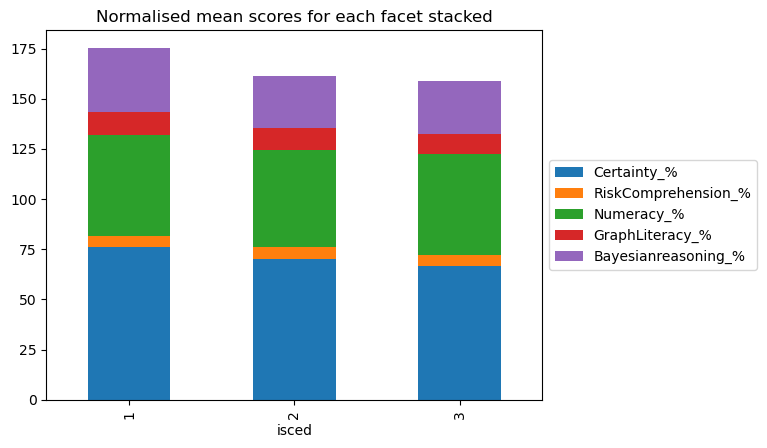

In [117]:
# Normalised mean scores for each facet stacked

df5.groupby('isced')[['Certainty_%','RiskComprehension_%','Numeracy_%','GraphLiteracy_%','Bayesianreasoning_%']].mean().plot( kind = 'bar', title = 'Normalised mean scores for each facet stacked', stacked = True).legend(loc='center left',bbox_to_anchor=(1.0, 0.5))

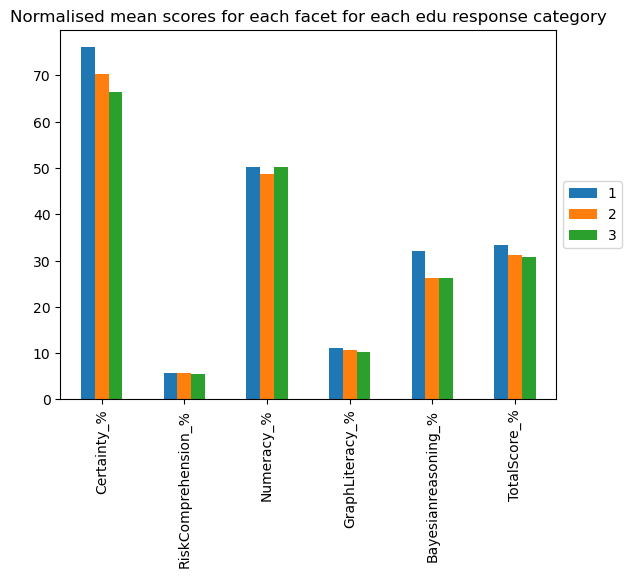

In [118]:
# Normalised mean scores for each facet for each edu response category

df5.groupby('isced')[['Certainty_%','RiskComprehension_%','Numeracy_%','GraphLiteracy_%','Bayesianreasoning_%','TotalScore_%']].mean().T.plot(kind = 'bar', title = 'Normalised mean scores for each facet for each edu response category').legend(loc='center left',bbox_to_anchor=(1.0, 0.5))

<Axes: xlabel='isced', ylabel='TotalScore_14'>

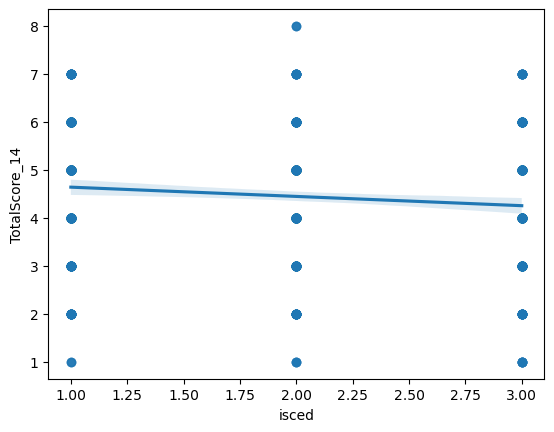

In [119]:
# Trend line for Absolute Total Facet Score vs edu (isced) reponses

sns.regplot (data = df5, x = 'isced', y = 'TotalScore_14')

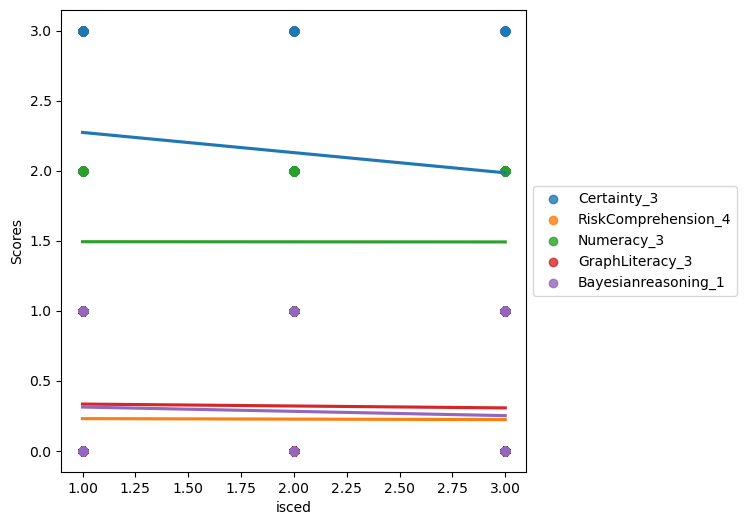

In [120]:
# Trend line for Absolute Independent Facet Score vs edu (isced) reponses

fig, ax6 = plt.subplots(figsize=(6, 6))

sns.regplot (data = df5, x = 'isced', y = 'Certainty_3', fit_reg=True, ci=None, ax=ax6, label='Certainty_3')
sns.regplot (data = df5, x = 'isced', y = 'RiskComprehension_4', fit_reg=True, ci=None, ax=ax6, label='RiskComprehension_4')
sns.regplot (data = df5, x = 'isced', y = 'Numeracy_3', fit_reg=True, ci=None, ax=ax6, label='Numeracy_3')
sns.regplot (data = df5, x = 'isced', y = 'GraphLiteracy_3', fit_reg=True, ci=None, ax=ax6, label='GraphLiteracy_3')
sns.regplot (data = df5, x = 'isced', y = 'Bayesianreasoning_1',fit_reg=True, ci=None, ax=ax6, label='Bayesianreasoning_1' )

ax6.set(ylabel='Scores', xlabel='isced')
ax6.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

<Axes: xlabel='isced', ylabel='TotalScore_14'>

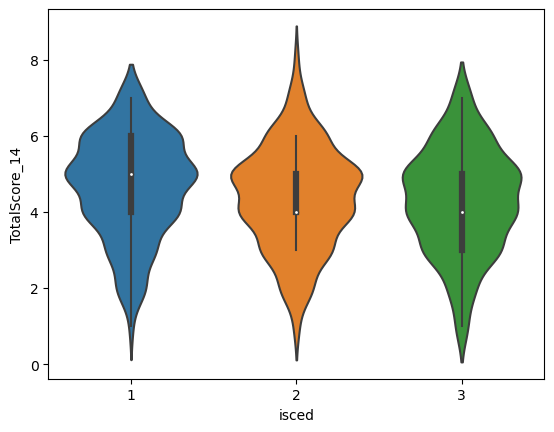

In [121]:
# Violine Plot for TotalScore_14 for each entry under edu.

sns.violinplot( data = df5, x = 'isced', y = 'TotalScore_14')

<Axes: xlabel='isced', ylabel='Certainty_3'>

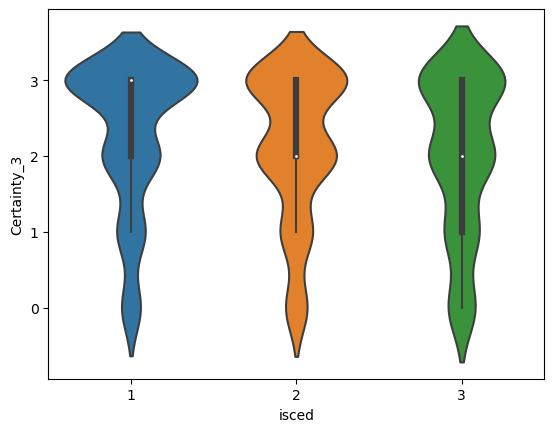

In [122]:
# Violine Plot for Certainty_3 for each entry under edu.

sns.violinplot( data = df5, x = 'isced', y = 'Certainty_3')

<Axes: xlabel='isced', ylabel='RiskComprehension_4'>

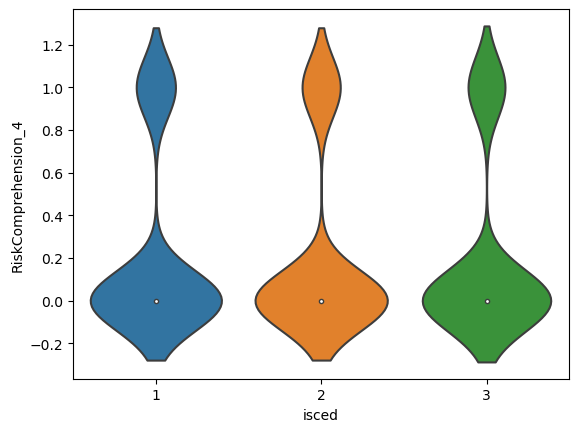

In [123]:
# Violine Plot for RiskComprehension_4 for each entry under edu.

sns.violinplot( data = df5, x = 'isced', y = 'RiskComprehension_4')

<Axes: xlabel='isced', ylabel='GraphLiteracy_3'>

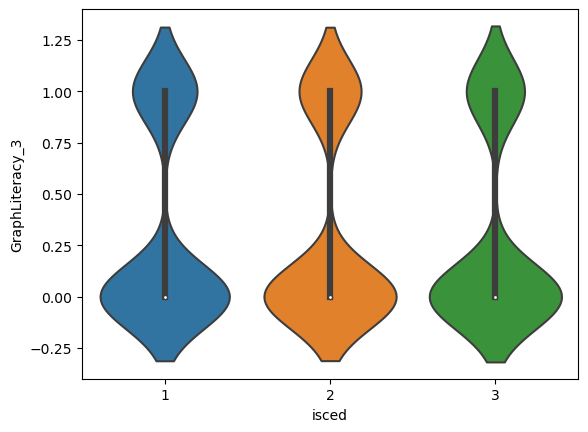

In [124]:
# Violine Plot for GraphLiteracy_3 for each entry under edu.

sns.violinplot( data = df5, x = 'isced', y = 'GraphLiteracy_3')

<Axes: xlabel='isced', ylabel='Numeracy_3'>

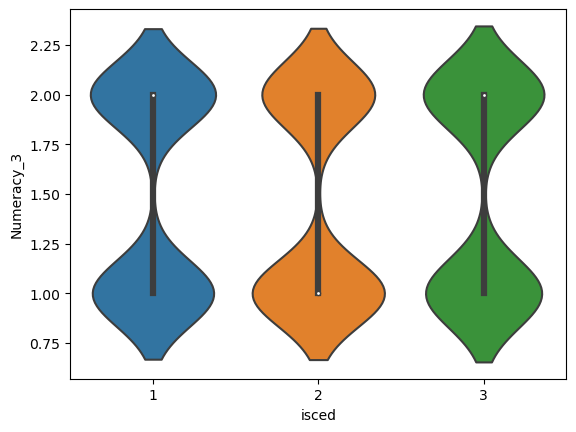

In [125]:
# Violine Plot for Numeracy_3 for each entry under edu.

sns.violinplot( data = df5, x = 'isced', y = 'Numeracy_3')

<Axes: xlabel='isced', ylabel='Bayesianreasoning_1'>

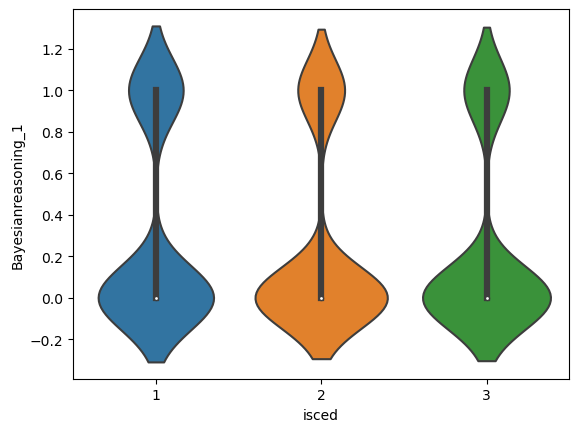

In [126]:
# Violine Plot for TotalScore_14 for each entry under edu.

sns.violinplot( data = df5, x = 'isced', y = 'Bayesianreasoning_1')

In [130]:
# Descriptive stats for the data set, isced = 1
# NA values of wealth are removed

df6 = df5.dropna(axis = 0, subset = 'wealth')
# df6.drop(df6[df6['wealth'] == 3500000].index, inplace = True)
df6.loc[df6['isced']==1][['wealth']].describe()

# temp --> remove after doing global changes
df6["wealth"] = df6["wealth"].astype(float)

In [131]:
# Descriptive stats for the data set, isced = 2

df6.loc[df6['isced']==2][['wealth']].describe()

wealth
count  2.410000e+02
mean   4.807468e+06
std    1.680959e+07
min    0.000000e+00
25%    1.000000e+05
50%    5.000000e+05
75%    2.500000e+06
max    1.565000e+08

In [132]:
# Descriptive stats for the data set, isced = 3

df6.loc[df6['isced']==3][['wealth']].describe()

wealth
count  2.060000e+02
mean   4.259471e+06
std    1.546074e+07
min    0.000000e+00
25%    2.125000e+04
50%    2.000000e+05
75%    1.500000e+06
max    1.500000e+08

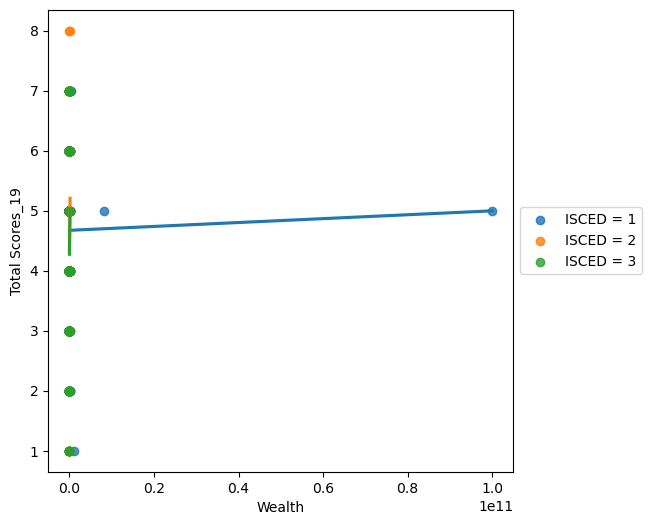

In [133]:
# Trend line for Absolute Tota Facet Score vs wealth reponses sorted by isced and ORDERED by wealth WITH scatter

fig, ax7 = plt.subplots(figsize=(6, 6))

sns.regplot (data = df6.loc[df6['isced']==1].reset_index(drop = True), x = df6.loc[df6['isced']==1].reset_index(drop = True)['wealth'], y = 'TotalScore_14', fit_reg=True, ci=None, ax=ax7, label='ISCED = 1')
sns.regplot (data = df6.loc[df6['isced']==2].reset_index(drop = True), x = df6.loc[df6['isced']==2].reset_index(drop = True)['wealth'], y = 'TotalScore_14', fit_reg=True, ci=None, ax=ax7, label='ISCED = 2')
sns.regplot (data = df6.loc[df6['isced']==3].reset_index(drop = True), x = df6.loc[df6['isced']==3].reset_index(drop = True)['wealth'], y = 'TotalScore_14', fit_reg=True, ci=None, ax=ax7, label='ISCED = 3')

ax7.set(ylabel='Total Scores_19', xlabel='Wealth')
ax7.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

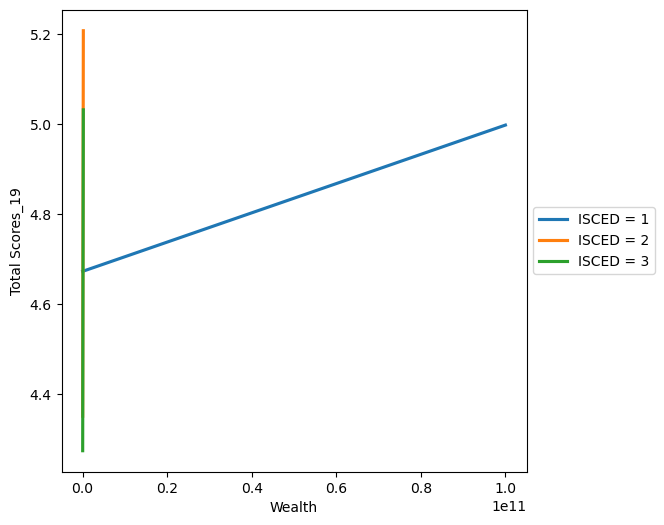

In [134]:
# Trend line for Absolute Tota Facet Score vs wealth reponses sorted by isced and ORDERED by wealth WITHOUT scatter

fig, ax8 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df6.loc[df6['isced']==1].reset_index(drop = True), x = df6.loc[df6['isced']==1].reset_index(drop = True)['wealth'], y = 'TotalScore_14', fit_reg=True, ci=None, ax=ax8, label='ISCED = 1')
sns.regplot (scatter = False, data = df6.loc[df6['isced']==2].reset_index(drop = True), x = df6.loc[df6['isced']==2].reset_index(drop = True)['wealth'], y = 'TotalScore_14', fit_reg=True, ci=None, ax=ax8, label='ISCED = 2')
sns.regplot (scatter = False, data = df6.loc[df6['isced']==3].reset_index(drop = True), x = df6.loc[df6['isced']==3].reset_index(drop = True)['wealth'], y = 'TotalScore_14', fit_reg=True, ci=None, ax=ax8, label='ISCED = 3')

ax8.set(ylabel='Total Scores_19', xlabel='Wealth')
ax8.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

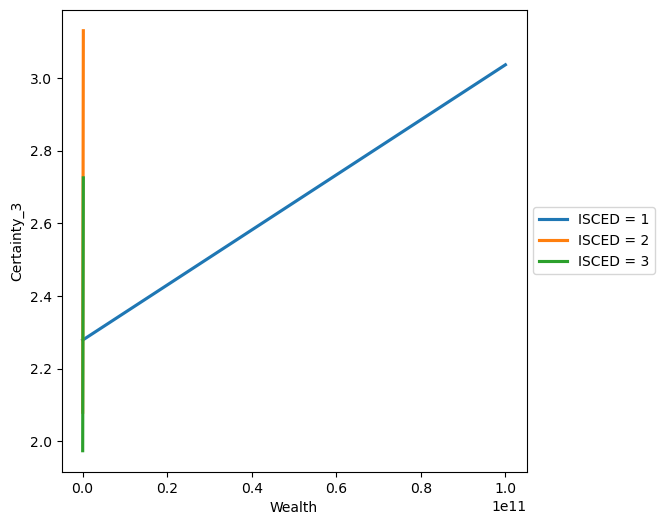

In [135]:
# Trend line for Absolute Certainty Score vs wealth reponses sorted by isced and ORDERED by wealth WITHOUT scatter

fig, ax9 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df6.loc[df6['isced']==1].reset_index(drop = True), x = df6.loc[df6['isced']==1].reset_index(drop = True)['wealth'], y = 'Certainty_3', fit_reg=True, ci=None, ax=ax9, label='ISCED = 1')
sns.regplot (scatter = False, data = df6.loc[df6['isced']==2].reset_index(drop = True), x = df6.loc[df6['isced']==2].reset_index(drop = True)['wealth'], y = 'Certainty_3', fit_reg=True, ci=None, ax=ax9, label='ISCED = 2')
sns.regplot (scatter = False, data = df6.loc[df6['isced']==3].reset_index(drop = True), x = df6.loc[df6['isced']==3].reset_index(drop = True)['wealth'], y = 'Certainty_3', fit_reg=True, ci=None, ax=ax9, label='ISCED = 3')

ax9.set(ylabel='Certainty_3', xlabel='Wealth')
ax9.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

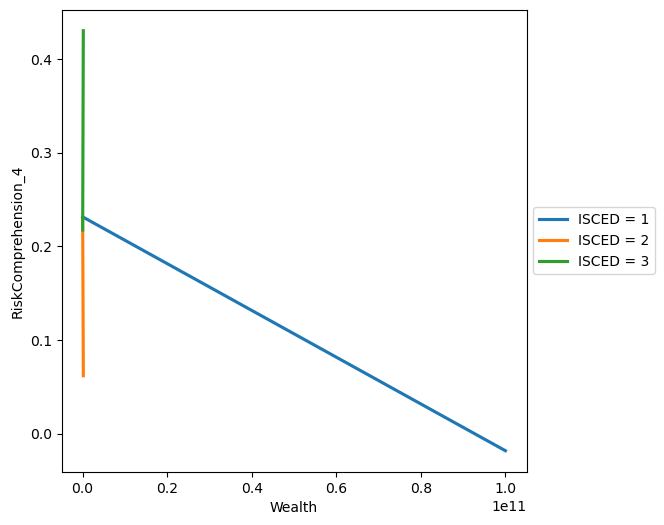

In [136]:
# Trend line for Absolute Uncertainty Score vs wealth reponses sorted by isced and ORDERED by wealth WITHOUT scatter

fig, ax10 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df6.loc[df6['isced']==1].reset_index(drop = True), x = df6.loc[df6['isced']==1].reset_index(drop = True)['wealth'], y = 'RiskComprehension_4', fit_reg=True, ci=None, ax=ax10, label='ISCED = 1')
sns.regplot (scatter = False, data = df6.loc[df6['isced']==2].reset_index(drop = True), x = df6.loc[df6['isced']==2].reset_index(drop = True)['wealth'], y = 'RiskComprehension_4', fit_reg=True, ci=None, ax=ax10, label='ISCED = 2')
sns.regplot (scatter = False, data = df6.loc[df6['isced']==3].reset_index(drop = True), x = df6.loc[df6['isced']==3].reset_index(drop = True)['wealth'], y = 'RiskComprehension_4', fit_reg=True, ci=None, ax=ax10, label='ISCED = 3')

ax10.set(ylabel='RiskComprehension_4', xlabel='Wealth')
ax10.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

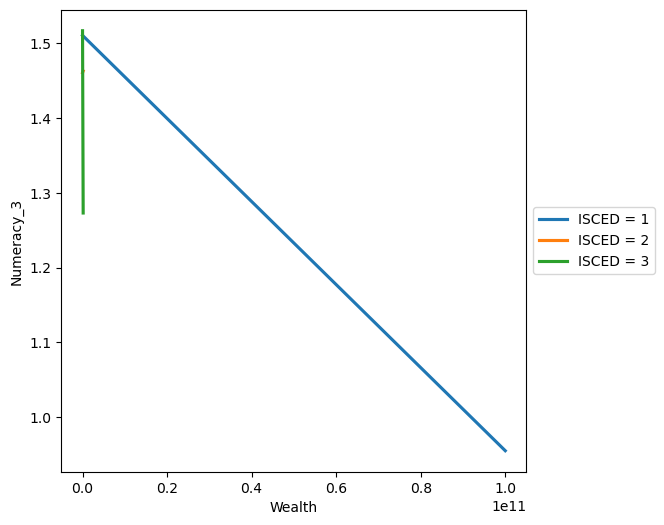

In [137]:
# Trend line for Absolute Number Comprehension Score vs wealth reponses sorted by isced and ORDERED by wealth WITHOUT scatter

fig, ax11 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df6.loc[df6['isced']==1].reset_index(drop = True), x = df6.loc[df6['isced']==1].reset_index(drop = True)['wealth'], y = 'Numeracy_3', fit_reg=True, ci=None, ax=ax11, label='ISCED = 1')
sns.regplot (scatter = False, data = df6.loc[df6['isced']==2].reset_index(drop = True), x = df6.loc[df6['isced']==2].reset_index(drop = True)['wealth'], y = 'Numeracy_3', fit_reg=True, ci=None, ax=ax11, label='ISCED = 2')
sns.regplot (scatter = False, data = df6.loc[df6['isced']==3].reset_index(drop = True), x = df6.loc[df6['isced']==3].reset_index(drop = True)['wealth'], y = 'Numeracy_3', fit_reg=True, ci=None, ax=ax11, label='ISCED = 3')

ax11.set(ylabel='Numeracy_3', xlabel='Wealth')
ax11.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

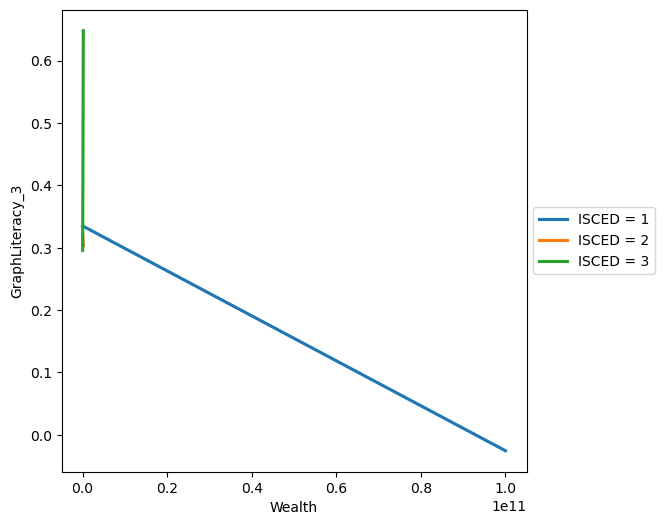

In [138]:
# Trend line for Absolute Graph Comprehension Score vs wealth reponses sorted by isced and ORDERED by wealth WITHOUT scatter

fig, ax11 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df6.loc[df6['isced']==1].reset_index(drop = True), x = df6.loc[df6['isced']==1].reset_index(drop = True)['wealth'], y = 'GraphLiteracy_3', fit_reg=True, ci=None, ax=ax11, label='ISCED = 1')
sns.regplot (scatter = False, data = df6.loc[df6['isced']==2].reset_index(drop = True), x = df6.loc[df6['isced']==2].reset_index(drop = True)['wealth'], y = 'GraphLiteracy_3', fit_reg=True, ci=None, ax=ax11, label='ISCED = 2')
sns.regplot (scatter = False, data = df6.loc[df6['isced']==3].reset_index(drop = True), x = df6.loc[df6['isced']==3].reset_index(drop = True)['wealth'], y = 'GraphLiteracy_3', fit_reg=True, ci=None, ax=ax11, label='ISCED = 3')

ax11.set(ylabel='GraphLiteracy_3', xlabel='Wealth')
ax11.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

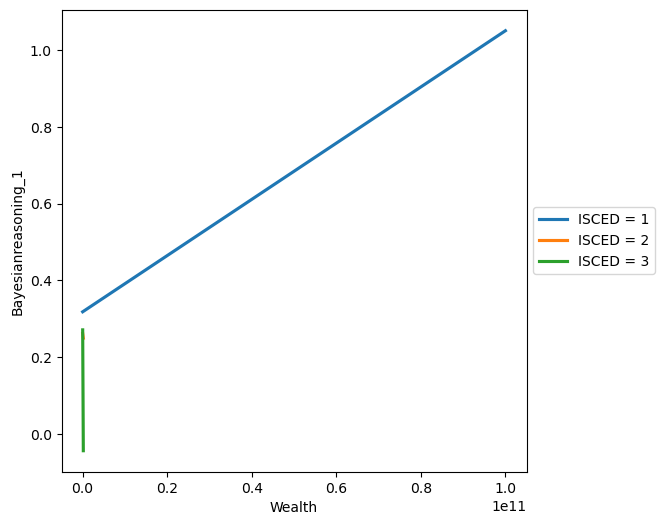

In [139]:
# Trend line for Absolute Bayesian Reasoning Score vs wealth reponses sorted by isced and ORDERED by wealth WITHOUT scatter

fig, ax12 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df6.loc[df6['isced']==1].reset_index(drop = True), x = df6.loc[df6['isced']==1].reset_index(drop = True)['wealth'], y = 'Bayesianreasoning_1', fit_reg=True, ci=None, ax=ax12, label='ISCED = 1')
sns.regplot (scatter = False, data = df6.loc[df6['isced']==2].reset_index(drop = True), x = df6.loc[df6['isced']==2].reset_index(drop = True)['wealth'], y = 'Bayesianreasoning_1', fit_reg=True, ci=None, ax=ax12, label='ISCED = 2')
sns.regplot (scatter = False, data = df6.loc[df6['isced']==3].reset_index(drop = True), x = df6.loc[df6['isced']==3].reset_index(drop = True)['wealth'], y = 'Bayesianreasoning_1', fit_reg=True, ci=None, ax=ax12, label='ISCED = 3')

ax12.set(ylabel='Bayesianreasoning_1', xlabel='Wealth')
ax12.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

In [140]:
# Descriptive stats for the data set, isced = 1
# NA values of income are removed

df7 = df5
df7.drop(df7[df7['income'] == 7].index, inplace = True)

df7.loc[df7['isced']==1].describe()

ResponseId         age     age_rec  isced      income  Certainty_3  \
count  252.000000  252.000000  252.000000  252.0  252.000000   252.000000   
mean   370.682540   35.757937    2.460317    1.0    3.234127     2.281746   
std    272.942711    8.983880    0.587395    0.0    1.432667     0.959324   
min      0.000000   19.000000    2.000000    1.0    1.000000     0.000000   
25%    102.750000   30.000000    2.000000    1.0    2.000000     2.000000   
50%    572.500000   34.500000    2.000000    1.0    3.000000     3.000000   
75%    635.250000   40.000000    3.000000    1.0    4.000000     3.000000   
max    698.000000   66.000000    4.000000    1.0    6.000000     3.000000   

       RiskComprehension_4  GraphLiteracy_3  Numeracy_3  Bayesianreasoning_1  \
count           252.000000       252.000000  252.000000           252.000000   
mean              0.230159         0.333333    1.507937             0.321429   
std               0.421772         0.472343    0.500932             0.467954   
min               0.000000         0.000000    1.000000             0.000000   
25%               0.000000         0.000000    1.000000             0.000000   
50%               0.000000         0.000000    2.000000             0.000000   
75%               0.000000         1.000000    2.000000             1.000000   
max               1.000000         1.000000    2.000000             1.000000   

       Certainty_%  RiskComprehension_%  GraphLiteracy_%  Numeracy_%  \
count   252.000000           252.000000       252.000000  252.000000   
mean     76.058201             5.753968        11.111111   50.264550   
std      31.977473            10.544300        15.744755   16.697730   
min       0.000000             0.000000         0.000000   33.333333   
25%      66.666667             0.000000         0.000000   33.333333   
50%     100.000000             0.000000         0.000000   66.666667   
75%     100.000000             0.000000        33.333333   66.666667   
max     100.000000            25.000000        33.333333   66.666667   

       Bayesianreasoning_%  TotalScore_14  TotalScore_%  
count           252.000000     252.000000    252.000000  
mean             32.142857       4.674603     33.390023  
std              46.795429       1.328986      9.492760  
min               0.000000       1.000000      7.142857  
25%               0.000000       4.000000     28.571429  
50%               0.000000       5.000000     35.714286  
75%             100.000000       6.000000     42.857143  
max             100.000000       7.000000     50.000000

In [141]:
df7.loc[df7['isced']==2].describe()

ResponseId        age     age_rec  isced      income  Certainty_3  \
count  241.000000  241.00000  241.000000  241.0  241.000000   241.000000   
mean   327.900415   33.40249    2.373444    2.0    2.224066     2.112033   
std    174.356168   11.55926    0.599965    0.0    1.227973     0.961715   
min      2.000000   18.00000    2.000000    2.0    1.000000     0.000000   
25%    182.000000   25.00000    2.000000    2.0    1.000000     2.000000   
50%    398.000000   30.00000    2.000000    2.0    2.000000     2.000000   
75%    490.000000   39.00000    3.000000    2.0    3.000000     3.000000   
max    556.000000   72.00000    4.000000    2.0    6.000000     3.000000   

       RiskComprehension_4  GraphLiteracy_3  Numeracy_3  Bayesianreasoning_1  \
count           241.000000       241.000000  241.000000           241.000000   
mean              0.224066         0.319502    1.460581             0.261411   
std               0.417834         0.467254    0.499481             0.440318   
min               0.000000         0.000000    1.000000             0.000000   
25%               0.000000         0.000000    1.000000             0.000000   
50%               0.000000         0.000000    1.000000             0.000000   
75%               0.000000         1.000000    2.000000             1.000000   
max               1.000000         1.000000    2.000000             1.000000   

       Certainty_%  RiskComprehension_%  GraphLiteracy_%  Numeracy_%  \
count   241.000000           241.000000       241.000000  241.000000   
mean     70.401107             5.601660        10.650069   48.686030   
std      32.057176            10.445844        15.575138   16.649369   
min       0.000000             0.000000         0.000000   33.333333   
25%      66.666667             0.000000         0.000000   33.333333   
50%      66.666667             0.000000         0.000000   33.333333   
75%     100.000000             0.000000        33.333333   66.666667   
max     100.000000            25.000000        33.333333   66.666667   

       Bayesianreasoning_%  TotalScore_14  TotalScore_%  
count           241.000000     241.000000    241.000000  
mean             26.141079       4.377593     31.268524  
std              44.031769       1.327025      9.478751  
min               0.000000       1.000000      7.142857  
25%               0.000000       4.000000     28.571429  
50%               0.000000       4.000000     28.571429  
75%             100.000000       5.000000     35.714286  
max             100.000000       8.000000     57.142857

In [142]:
df7.loc[df7['isced']==3].describe()

ResponseId         age     age_rec  isced      income  Certainty_3  \
count  206.000000  206.000000  206.000000  206.0  206.000000   206.000000   
mean   347.160194   36.601942    2.548544    3.0    2.150485     1.995146   
std    104.520781   13.248352    0.651507    0.0    1.521128     1.038280   
min     27.000000   18.000000    2.000000    3.0    1.000000     0.000000   
25%    285.250000   27.000000    2.000000    3.0    1.000000     1.000000   
50%    345.500000   35.000000    2.000000    3.0    2.000000     2.000000   
75%    404.500000   45.000000    3.000000    3.0    2.750000     3.000000   
max    570.000000   75.000000    4.000000    3.0    6.000000     3.000000   

       RiskComprehension_4  GraphLiteracy_3  Numeracy_3  Bayesianreasoning_1  \
count           206.000000       206.000000  206.000000           206.000000   
mean              0.223301         0.305825    1.509709             0.262136   
std               0.417473         0.461879    0.501124             0.440868   
min               0.000000         0.000000    1.000000             0.000000   
25%               0.000000         0.000000    1.000000             0.000000   
50%               0.000000         0.000000    2.000000             0.000000   
75%               0.000000         1.000000    2.000000             1.000000   
max               1.000000         1.000000    2.000000             1.000000   

       Certainty_%  RiskComprehension_%  GraphLiteracy_%  Numeracy_%  \
count   206.000000           206.000000       206.000000  206.000000   
mean     66.504854             5.582524        10.194175   50.323625   
std      34.609329            10.436824        15.395950   16.704118   
min       0.000000             0.000000         0.000000   33.333333   
25%      33.333333             0.000000         0.000000   33.333333   
50%      66.666667             0.000000         0.000000   66.666667   
75%     100.000000             0.000000        33.333333   66.666667   
max     100.000000            25.000000        33.333333   66.666667   

       Bayesianreasoning_%  TotalScore_14  TotalScore_%  
count           206.000000     206.000000    206.000000  
mean             26.213592       4.296117     30.686546  
std              44.086755       1.363169      9.736919  
min               0.000000       1.000000      7.142857  
25%               0.000000       3.000000     21.428571  
50%               0.000000       4.000000     28.571429  
75%             100.000000       5.000000     35.714286  
max             100.000000       7.000000     50.000000

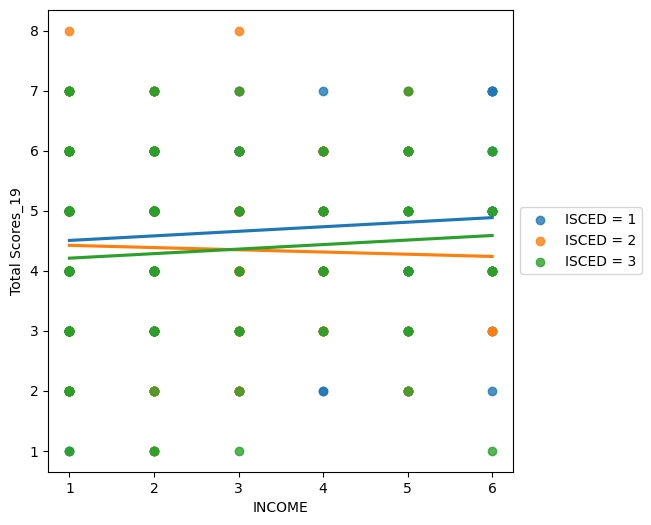

In [143]:
# Trend line for Absolute Tota Facet Score vs income reponses sorted by isced and ORDERED by income WITH scatter

fig, ax7 = plt.subplots(figsize=(6, 6))

sns.regplot (data = df7.loc[df7['isced']==1].reset_index(drop = True), x = 'income', y = df7.loc[df7['isced']==1]['TotalScore_14'], fit_reg=True, ci=None, ax=ax7, label='ISCED = 1')
sns.regplot (data = df7.loc[df7['isced']==2].reset_index(drop = True), x = 'income', y = df7.loc[df7['isced']==2]['TotalScore_14'], fit_reg=True, ci=None, ax=ax7, label='ISCED = 2')
sns.regplot (data = df7.loc[df7['isced']==3].reset_index(drop = True), x = 'income', y = df7.loc[df7['isced']==3]['TotalScore_14'], fit_reg=True, ci=None, ax=ax7, label='ISCED = 3')

ax7.set(ylabel='Total Scores_19', xlabel='INCOME')
ax7.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

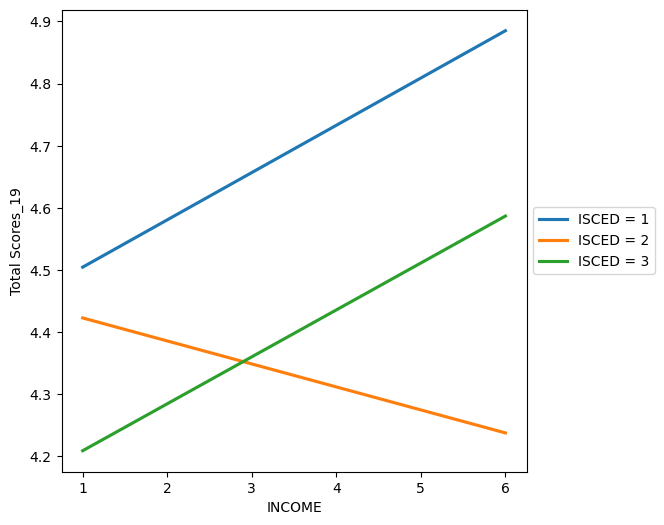

In [144]:
# Trend line for Absolute Tota Facet Score vs income reponses sorted by isced and ORDERED by income WITHOUT scatter

fig, ax8 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df7.loc[df7['isced']==1].reset_index(drop = True), x = 'income', y = 'TotalScore_14', fit_reg=True, ci=None, ax=ax8, label='ISCED = 1')
sns.regplot (scatter = False, data = df7.loc[df7['isced']==2].reset_index(drop = True), x = 'income', y = 'TotalScore_14', fit_reg=True, ci=None, ax=ax8, label='ISCED = 2')
sns.regplot (scatter = False, data = df7.loc[df7['isced']==3].reset_index(drop = True), x = 'income', y = 'TotalScore_14', fit_reg=True, ci=None, ax=ax8, label='ISCED = 3')

ax8.set(ylabel='Total Scores_19', xlabel='INCOME')
ax8.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

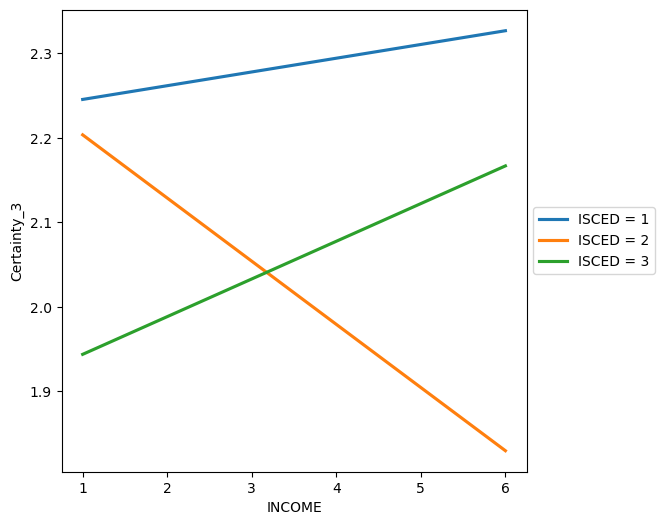

In [145]:
# Trend line for Absolute Certainty Score vs income reponses sorted by isced and ORDERED by income WITHOUT scatter

fig, ax9 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df7.loc[df7['isced']==1].reset_index(drop = True), x = 'income', y = 'Certainty_3', fit_reg=True, ci=None, ax=ax9, label='ISCED = 1')
sns.regplot (scatter = False, data = df7.loc[df7['isced']==2].reset_index(drop = True), x = 'income', y = 'Certainty_3', fit_reg=True, ci=None, ax=ax9, label='ISCED = 2')
sns.regplot (scatter = False, data = df7.loc[df7['isced']==3].reset_index(drop = True), x = 'income', y = 'Certainty_3', fit_reg=True, ci=None, ax=ax9, label='ISCED = 3')

ax9.set(ylabel='Certainty_3', xlabel='INCOME')
ax9.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

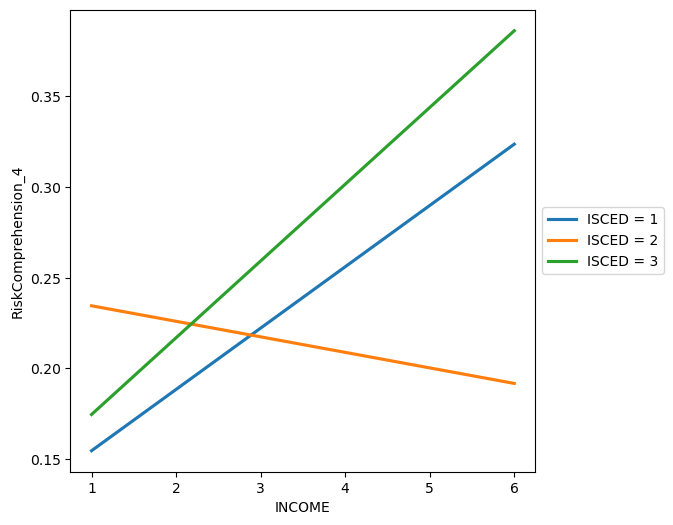

In [146]:
# Trend line for Absolute Risk Comprehension Score vs income reponses sorted by isced and ORDERED by income WITHOUT scatter

fig, ax10 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df7.loc[df7['isced']==1].reset_index(drop = True), x = 'income', y = 'RiskComprehension_4', fit_reg=True, ci=None, ax=ax10, label='ISCED = 1')
sns.regplot (scatter = False, data = df7.loc[df7['isced']==2].reset_index(drop = True), x = 'income', y = 'RiskComprehension_4', fit_reg=True, ci=None, ax=ax10, label='ISCED = 2')
sns.regplot (scatter = False, data = df7.loc[df7['isced']==3].reset_index(drop = True), x = 'income', y = 'RiskComprehension_4', fit_reg=True, ci=None, ax=ax10, label='ISCED = 3')

ax10.set(ylabel='RiskComprehension_4', xlabel='INCOME')
ax10.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

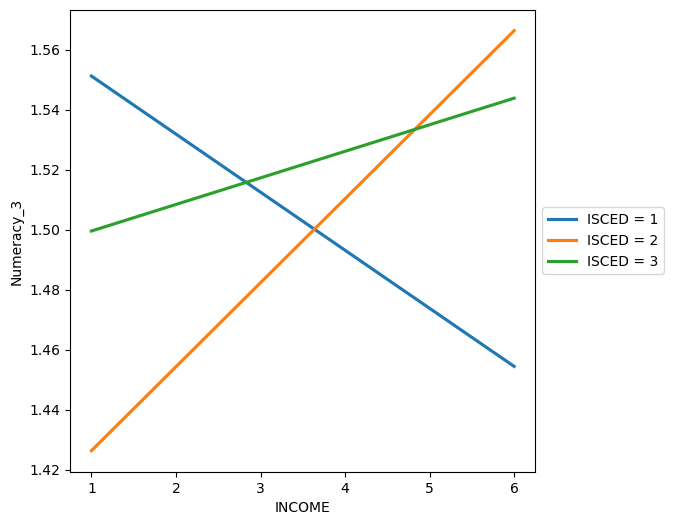

In [147]:
# Trend line for Absolute Number Comprehension Score vs income reponses sorted by isced and ORDERED by income WITHOUT scatter

fig, ax11 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df7.loc[df7['isced']==1].reset_index(drop = True), x = 'income', y = 'Numeracy_3', fit_reg=True, ci=None, ax=ax11, label='ISCED = 1')
sns.regplot (scatter = False, data = df7.loc[df7['isced']==2].reset_index(drop = True), x = 'income', y = 'Numeracy_3', fit_reg=True, ci=None, ax=ax11, label='ISCED = 2')
sns.regplot (scatter = False, data = df7.loc[df7['isced']==3].reset_index(drop = True), x = 'income', y = 'Numeracy_3', fit_reg=True, ci=None, ax=ax11, label='ISCED = 3')

ax11.set(ylabel='Numeracy_3', xlabel='INCOME')
ax11.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

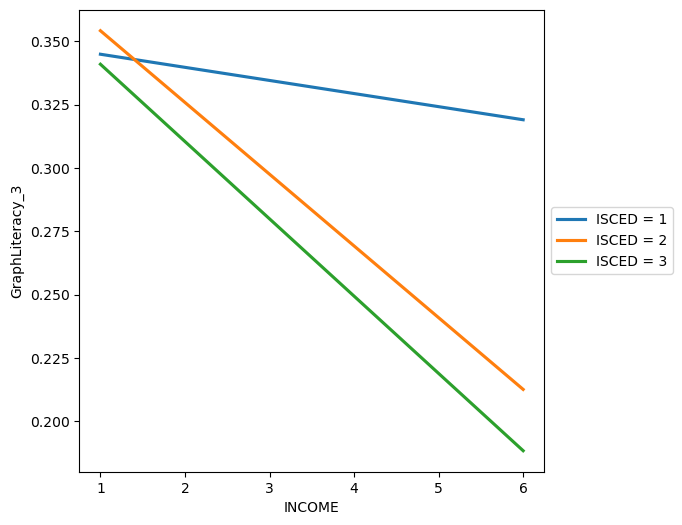

In [148]:
# Trend line for Absolute Graph Comprehension Score vs income reponses sorted by isced and ORDERED by income WITHOUT scatter

fig, ax11 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df7.loc[df7['isced']==1].reset_index(drop = True), x = 'income', y = 'GraphLiteracy_3', fit_reg=True, ci=None, ax=ax11, label='ISCED = 1')
sns.regplot (scatter = False, data = df7.loc[df7['isced']==2].reset_index(drop = True), x = 'income', y = 'GraphLiteracy_3', fit_reg=True, ci=None, ax=ax11, label='ISCED = 2')
sns.regplot (scatter = False, data = df7.loc[df7['isced']==3].reset_index(drop = True), x = 'income', y = 'GraphLiteracy_3', fit_reg=True, ci=None, ax=ax11, label='ISCED = 3')

ax11.set(ylabel='GraphLiteracy_3', xlabel='INCOME')
ax11.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

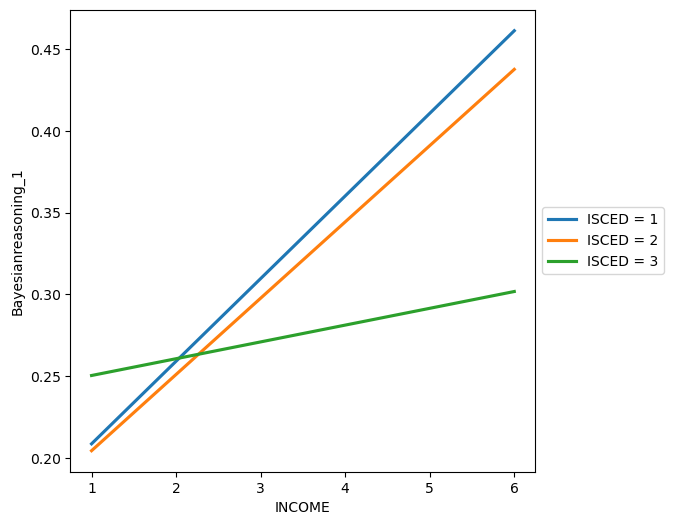

In [149]:
# Trend line for Absolute Bayesian Reasoning Score vs income reponses sorted by isced and ORDERED by income WITHOUT scatter

fig, ax12 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df7.loc[df7['isced']==1].reset_index(drop = True), x = 'income', y = 'Bayesianreasoning_1', fit_reg=True, ci=None, ax=ax12, label='ISCED = 1')
sns.regplot (scatter = False, data = df7.loc[df7['isced']==2].reset_index(drop = True), x = 'income', y = 'Bayesianreasoning_1', fit_reg=True, ci=None, ax=ax12, label='ISCED = 2')
sns.regplot (scatter = False, data = df7.loc[df7['isced']==3].reset_index(drop = True), x = 'income', y = 'Bayesianreasoning_1', fit_reg=True, ci=None, ax=ax12, label='ISCED = 3')

ax12.set(ylabel='Bayesianreasoning_1', xlabel='INCOME')
ax12.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

In [150]:
df7

ResponseId  age  age_rec  isced  income    wealth  Certainty_3  \
0             0   30        2      1       2   5000000            2   
1           599   35        2      1       3   2000000            3   
2           598   27        2      1       5  20000000            2   
3           597   45        3      1       3   5000000            2   
4           596   40        3      1       6    500000            2   
..          ...  ...      ...    ...     ...       ...          ...   
694         365   26        2      3       1   4000000            2   
695         364   28        2      3       3    100000            2   
696         363   20        2      3       2    140000            3   
697         361   75        4      3       1   2000000            2   
698         349   37        3      3       2  15000000            0   

     RiskComprehension_4  GraphLiteracy_3  Numeracy_3  Bayesianreasoning_1  \
0                      1                1           1                    0   
1                      1                0           2                    0   
2                      1                0           2                    0   
3                      0                0           2                    0   
4                      0                0           2                    1   
..                   ...              ...         ...                  ...   
694                    0                0           2                    0   
695                    0                0           1                    0   
696                    0                0           1                    1   
697                    0                1           2                    0   
698                    0                0           1                    0   

     Certainty_%  RiskComprehension_%  GraphLiteracy_%  Numeracy_%  \
0      66.666667                 25.0        33.333333   33.333333   
1     100.000000                 25.0         0.000000   66.666667   
2      66.666667                 25.0         0.000000   66.666667   
3      66.666667                  0.0         0.000000   66.666667   
4      66.666667                  0.0         0.000000   66.666667   
..           ...                  ...              ...         ...   
694    66.666667                  0.0         0.000000   66.666667   
695    66.666667                  0.0         0.000000   33.333333   
696   100.000000                  0.0         0.000000   33.333333   
697    66.666667                  0.0        33.333333   66.666667   
698     0.000000                  0.0         0.000000   33.333333   

     Bayesianreasoning_%  TotalScore_14  TotalScore_%  
0                    0.0              5     35.714286  
1                    0.0              6     42.857143  
2                    0.0              5     35.714286  
3                    0.0              4     28.571429  
4                  100.0              5     35.714286  
..                   ...            ...           ...  
694                  0.0              4     28.571429  
695                  0.0              3     21.428571  
696                100.0              5     35.714286  
697                  0.0              5     35.714286  
698                  0.0              1      7.142857  

[699 rows x 18 columns]

In [151]:
# Since we already have a classification for Age groups in the form of age_rec, we will use that.
# We will also use median of age to see if it yields any relevant results, as instructed.

# AXES to be used = Age or age groups, ISCED, Income

# Age groups = [2,3,4]
# Age group 2 = 18 to 35 y/o
# Age group 3 = 36 to 59 y/o
# Age group 4 = 60 to 75 y/o (75 y/o, i.e, within the scope of the data we have, it can mean 60 and above also)



In [152]:
df7.loc[(df7['age_rec']==2)].describe()

ResponseId         age  age_rec       isced      income  Certainty_3  \
count  425.000000  425.000000    425.0  425.000000  425.000000   425.000000   
mean   355.920000   27.917647      2.0    1.912941    2.527059     2.141176   
std    197.921459    4.729005      0.0    0.776693    1.455260     0.958489   
min      0.000000   18.000000      2.0    1.000000    1.000000     0.000000   
25%    204.000000   24.000000      2.0    1.000000    1.000000     2.000000   
50%    364.000000   28.000000      2.0    2.000000    2.000000     2.000000   
75%    518.000000   32.000000      2.0    3.000000    3.000000     3.000000   
max    698.000000   35.000000      2.0    3.000000    6.000000     3.000000   

       RiskComprehension_4  GraphLiteracy_3  Numeracy_3  Bayesianreasoning_1  \
count           425.000000       425.000000  425.000000           425.000000   
mean              0.249412         0.303529    1.503529             0.270588   
std               0.433182         0.460324    0.500577             0.444787   
min               0.000000         0.000000    1.000000             0.000000   
25%               0.000000         0.000000    1.000000             0.000000   
50%               0.000000         0.000000    2.000000             0.000000   
75%               0.000000         1.000000    2.000000             1.000000   
max               1.000000         1.000000    2.000000             1.000000   

       Certainty_%  RiskComprehension_%  GraphLiteracy_%  Numeracy_%  \
count   425.000000           425.000000       425.000000  425.000000   
mean     71.372549             6.235294        10.117647   50.117647   
std      31.949638            10.829562        15.344123   16.685893   
min       0.000000             0.000000         0.000000   33.333333   
25%      66.666667             0.000000         0.000000   33.333333   
50%      66.666667             0.000000         0.000000   66.666667   
75%     100.000000             0.000000        33.333333   66.666667   
max     100.000000            25.000000        33.333333   66.666667   

       Bayesianreasoning_%  TotalScore_14  TotalScore_%  
count           425.000000     425.000000    425.000000  
mean             27.058824       4.468235     31.915966  
std              44.478730       1.336905      9.549319  
min               0.000000       1.000000      7.142857  
25%               0.000000       4.000000     28.571429  
50%               0.000000       5.000000     35.714286  
75%             100.000000       5.000000     35.714286  
max             100.000000       8.000000     57.142857

In [153]:
df7.loc[(df7['age_rec']==3)].describe()

ResponseId         age  age_rec       isced      income  Certainty_3  \
count  229.000000  229.000000    229.0  229.000000  229.000000   229.000000   
mean   340.087336   43.104803      3.0    1.934498    2.759825     2.183406   
std    208.893474    5.013790      0.0    0.858440    1.518584     0.991846   
min      1.000000   36.000000      3.0    1.000000    1.000000     0.000000   
25%    155.000000   39.000000      3.0    1.000000    2.000000     2.000000   
50%    336.000000   42.000000      3.0    2.000000    2.000000     3.000000   
75%    546.000000   46.000000      3.0    3.000000    4.000000     3.000000   
max    696.000000   55.000000      3.0    3.000000    6.000000     3.000000   

       RiskComprehension_4  GraphLiteracy_3  Numeracy_3  Bayesianreasoning_1  \
count           229.000000       229.000000  229.000000           229.000000   
mean              0.192140         0.323144    1.493450             0.296943   
std               0.394845         0.468702    0.501052             0.457912   
min               0.000000         0.000000    1.000000             0.000000   
25%               0.000000         0.000000    1.000000             0.000000   
50%               0.000000         0.000000    1.000000             0.000000   
75%               0.000000         1.000000    2.000000             1.000000   
max               1.000000         1.000000    2.000000             1.000000   

       Certainty_%  RiskComprehension_%  GraphLiteracy_%  Numeracy_%  \
count   229.000000           229.000000       229.000000  229.000000   
mean     72.780204             4.803493        10.771470   49.781659   
std      33.061534             9.871134        15.623391   16.701743   
min       0.000000             0.000000         0.000000   33.333333   
25%      66.666667             0.000000         0.000000   33.333333   
50%     100.000000             0.000000         0.000000   33.333333   
75%     100.000000             0.000000        33.333333   66.666667   
max     100.000000            25.000000        33.333333   66.666667   

       Bayesianreasoning_%  TotalScore_14  TotalScore_%  
count           229.000000     229.000000    229.000000  
mean             29.694323       4.489083     32.064878  
std              45.791222       1.355985      9.685609  
min               0.000000       1.000000      7.142857  
25%               0.000000       4.000000     28.571429  
50%               0.000000       5.000000     35.714286  
75%             100.000000       5.000000     35.714286  
max             100.000000       7.000000     50.000000

In [154]:
df7.loc[(df7['age_rec']==4)].describe()

ResponseId        age  age_rec      isced     income  Certainty_3  \
count   45.000000  45.000000     45.0  45.000000  45.000000    45.000000   
mean   329.000000  63.666667      4.0   2.133333   1.955556     1.888889   
std    204.826867   4.866397      0.0   0.814639   1.330679     1.228862   
min      5.000000  57.000000      4.0   1.000000   1.000000     0.000000   
25%    156.000000  60.000000      4.0   1.000000   1.000000     1.000000   
50%    310.000000  63.000000      4.0   2.000000   1.000000     2.000000   
75%    529.000000  67.000000      4.0   3.000000   2.000000     3.000000   
max    678.000000  75.000000      4.0   3.000000   6.000000     3.000000   

       RiskComprehension_4  GraphLiteracy_3  Numeracy_3  Bayesianreasoning_1  \
count            45.000000        45.000000   45.000000            45.000000   
mean              0.177778         0.466667    1.377778             0.333333   
std               0.386646         0.504525    0.490310             0.476731   
min               0.000000         0.000000    1.000000             0.000000   
25%               0.000000         0.000000    1.000000             0.000000   
50%               0.000000         0.000000    1.000000             0.000000   
75%               0.000000         1.000000    2.000000             1.000000   
max               1.000000         1.000000    2.000000             1.000000   

       Certainty_%  RiskComprehension_%  GraphLiteracy_%  Numeracy_%  \
count    45.000000            45.000000        45.000000   45.000000   
mean     62.962963             4.444444        15.555556   45.925926   
std      40.962056             9.666144        16.817499   16.343672   
min       0.000000             0.000000         0.000000   33.333333   
25%      33.333333             0.000000         0.000000   33.333333   
50%      66.666667             0.000000         0.000000   33.333333   
75%     100.000000             0.000000        33.333333   66.666667   
max     100.000000            25.000000        33.333333   66.666667   

       Bayesianreasoning_%  TotalScore_14  TotalScore_%  
count            45.000000      45.000000     45.000000  
mean             33.333333       4.244444     30.317460  
std              47.673129       1.400577     10.004122  
min               0.000000       1.000000      7.142857  
25%               0.000000       4.000000     28.571429  
50%               0.000000       4.000000     28.571429  
75%             100.000000       5.000000     35.714286  
max             100.000000       8.000000     57.142857

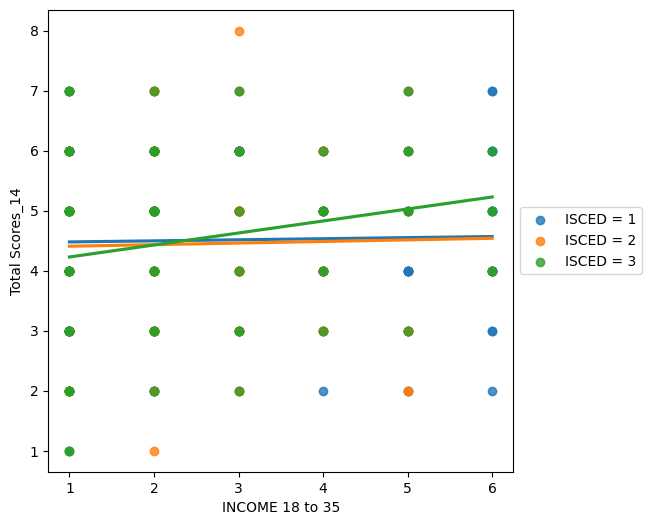

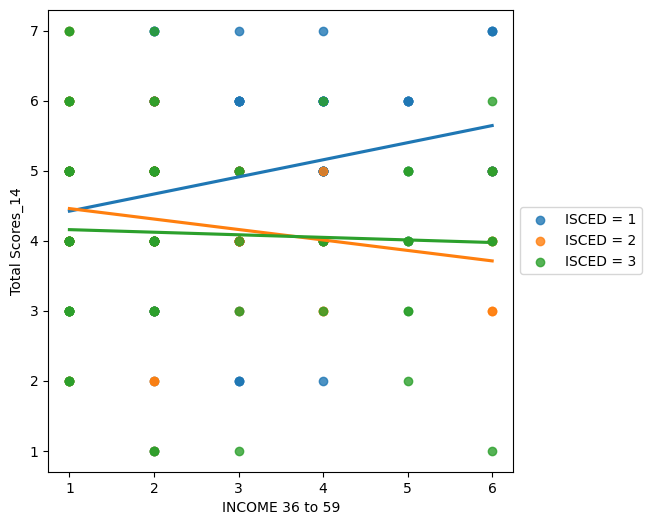

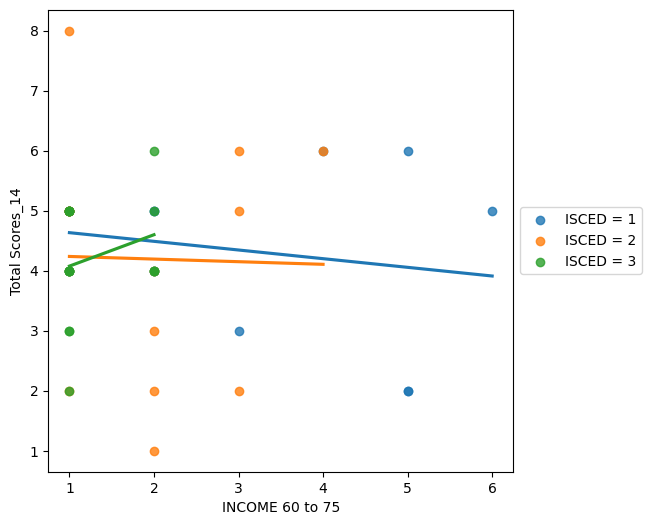

In [155]:
fig, ax1 = plt.subplots(figsize=(6, 6))

sns.regplot (data = df7.loc[(df7['age_rec']==2) & (df7['isced']==1)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==2) & (df7['isced']==1)]['TotalScore_14'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 1')
sns.regplot (data = df7.loc[(df7['age_rec']==2) & (df7['isced']==2)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==2) & (df7['isced']==2)]['TotalScore_14'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 2')
sns.regplot (data = df7.loc[(df7['age_rec']==2) & (df7['isced']==3)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==2) & (df7['isced']==3)]['TotalScore_14'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 3')

ax1.set(ylabel='Total Scores_14', xlabel='INCOME 18 to 35')
ax1.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

fig, ax2 = plt.subplots(figsize=(6, 6))

sns.regplot (data = df7.loc[(df7['age_rec']==3) & (df7['isced']==1)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==3) & (df7['isced']==1)]['TotalScore_14'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 1')
sns.regplot (data = df7.loc[(df7['age_rec']==3) & (df7['isced']==2)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==3) & (df7['isced']==2)]['TotalScore_14'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 2')
sns.regplot (data = df7.loc[(df7['age_rec']==3) & (df7['isced']==3)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==3) & (df7['isced']==3)]['TotalScore_14'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 3')

ax2.set(ylabel='Total Scores_14', xlabel='INCOME 36 to 59')
ax2.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

fig, ax3 = plt.subplots(figsize=(6, 6))

sns.regplot (data = df7.loc[(df7['age_rec']==4) & (df7['isced']==1)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==4) & (df7['isced']==1)]['TotalScore_14'], fit_reg=True, ci=None, ax=ax3, label='ISCED = 1')
sns.regplot (data = df7.loc[(df7['age_rec']==4) & (df7['isced']==2)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==4) & (df7['isced']==2)]['TotalScore_14'], fit_reg=True, ci=None, ax=ax3, label='ISCED = 2')
sns.regplot (data = df7.loc[(df7['age_rec']==4) & (df7['isced']==3)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==4) & (df7['isced']==3)]['TotalScore_14'], fit_reg=True, ci=None, ax=ax3, label='ISCED = 3')

ax3.set(ylabel='Total Scores_14', xlabel='INCOME 60 to 75')
ax3.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

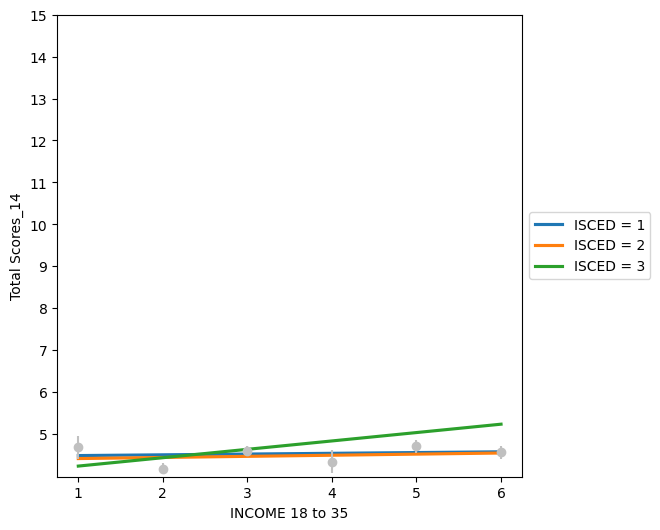

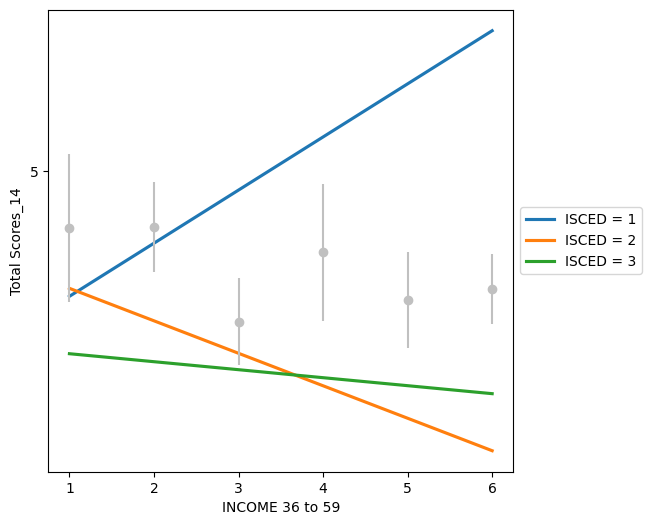

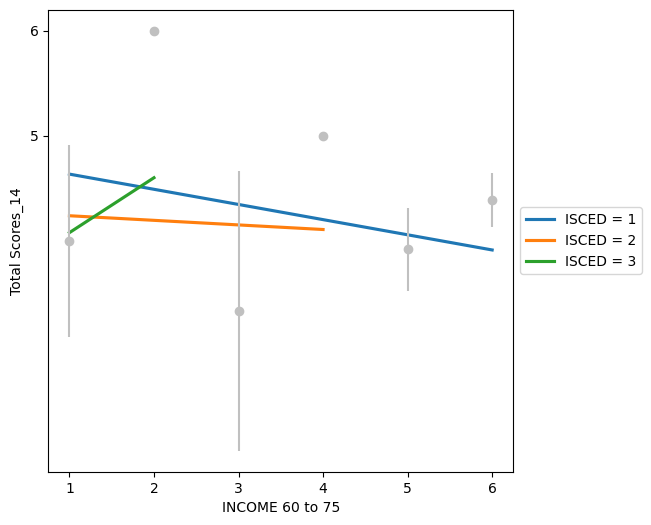

In [156]:
fig, ax1 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==2) & (df7['isced']==1)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==2) & (df7['isced']==1)]['TotalScore_14'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 1')
sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==2) & (df7['isced']==2)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==2) & (df7['isced']==2)]['TotalScore_14'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 2')
sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==2) & (df7['isced']==3)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==2) & (df7['isced']==3)]['TotalScore_14'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 3')

ax1.errorbar(x = df7.loc[ df7['age_rec']==2  ]["income"].unique(), y = df7.loc[ df7['age_rec']==2  ].groupby(['income']).mean(numeric_only=True)['TotalScore_14'], yerr = df7.loc[ (df7['age_rec']==2) ].groupby(['income'])['TotalScore_14'].sem(), fmt='o', color = lighten_color('gray',0.5))
ax1.set(ylabel='Total Scores_14', xlabel='INCOME 18 to 35',  yticks = np.arange(5, 16 , 1))
ax1.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

fig, ax2 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==3) & (df7['isced']==1)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==3) & (df7['isced']==1)]['TotalScore_14'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 1')
sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==3) & (df7['isced']==2)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==3) & (df7['isced']==2)]['TotalScore_14'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 2')
sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==3) & (df7['isced']==3)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==3) & (df7['isced']==3)]['TotalScore_14'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 3')

ax2.set(ylabel='Total Scores_14', xlabel='INCOME 36 to 59',  yticks = np.arange(5, 16 , 1))
ax2.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
ax2.errorbar(x = df7.loc[ df7['age_rec']==3  ]["income"].unique(), y = df7.loc[ df7['age_rec']==3  ].groupby(['income']).mean(numeric_only=True)['TotalScore_14'], yerr = df7.loc[ (df7['age_rec']==3) ].groupby(['income'])['TotalScore_14'].sem(), fmt='o', color = lighten_color('gray',0.5))
plt.show()

fig, ax3 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==4) & (df7['isced']==1)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==4) & (df7['isced']==1)]['TotalScore_14'], fit_reg=True, ci=None, ax=ax3, label='ISCED = 1')
sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==4) & (df7['isced']==2)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==4) & (df7['isced']==2)]['TotalScore_14'], fit_reg=True, ci=None, ax=ax3, label='ISCED = 2')
sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==4) & (df7['isced']==3)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==4) & (df7['isced']==3)]['TotalScore_14'], fit_reg=True, ci=None, ax=ax3, label='ISCED = 3')

ax3.set(ylabel='Total Scores_14', xlabel='INCOME 60 to 75',  yticks = np.arange(5, 16 , 1))
ax3.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
ax3.errorbar(x = df7.loc[ df7['age_rec']== 4 ]['income'].unique(), y = df7.loc[ df7['age_rec']==4  ].groupby(['income']).mean(numeric_only=True)['TotalScore_14'], yerr = df7.loc[ (df7['age_rec']==4) ].groupby(['income'])['TotalScore_14'].sem(), fmt='o', color = lighten_color('gray',0.5))
plt.show()

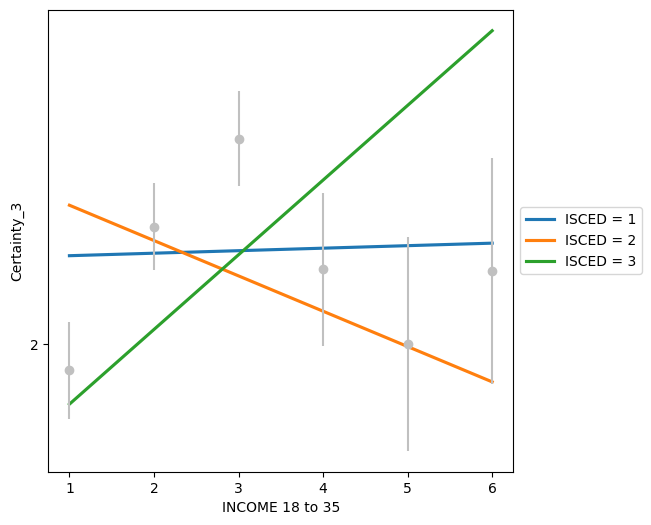

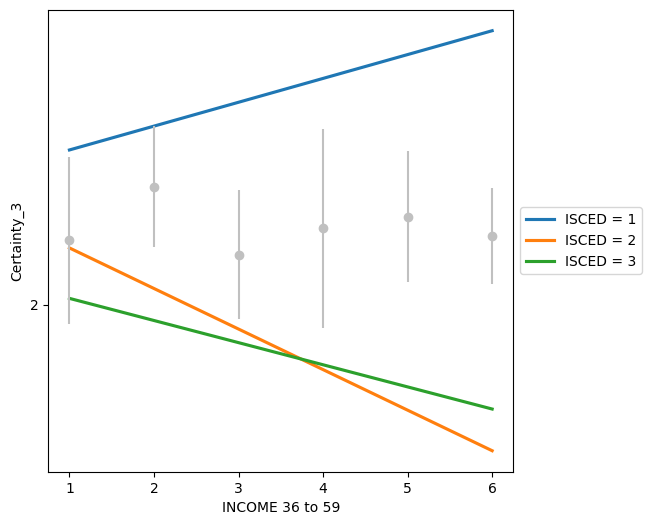

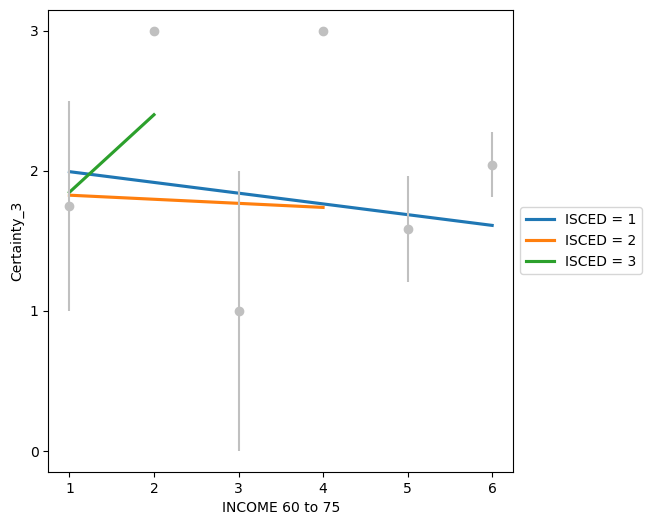

In [157]:
fig, ax1 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==2) & (df7['isced']==1)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==2) & (df7['isced']==1)]['Certainty_3'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 1')
sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==2) & (df7['isced']==2)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==2) & (df7['isced']==2)]['Certainty_3'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 2')
sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==2) & (df7['isced']==3)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==2) & (df7['isced']==3)]['Certainty_3'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 3')

ax1.set(ylabel='Certainty_3', xlabel='INCOME 18 to 35',  yticks = np.arange(0, 6 , 1))
ax1.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
ax1.errorbar(x = [1,2,3,4,5,6], y = df7.loc[ df7['age_rec']==2  ].groupby(['income'])['Certainty_3'].mean(), yerr = df7.loc[ (df7['age_rec']==2) ].groupby(['income'])['Certainty_3'].sem(), fmt='o', color = lighten_color('gray',0.5))
plt.show()

fig, ax2 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==3) & (df7['isced']==1)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==3) & (df7['isced']==1)]['Certainty_3'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 1')
sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==3) & (df7['isced']==2)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==3) & (df7['isced']==2)]['Certainty_3'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 2')
sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==3) & (df7['isced']==3)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==3) & (df7['isced']==3)]['Certainty_3'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 3')

ax2.set(ylabel='Certainty_3', xlabel='INCOME 36 to 59',  yticks = np.arange(0, 6 , 1))
ax2.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
ax2.errorbar(x = df7.loc[ df7['age_rec']== 3 ]['income'].unique(), y = df7.loc[ df7['age_rec']==3  ].groupby(['income'])['Certainty_3'].mean(), yerr = df7.loc[ (df7['age_rec']==3) ].groupby(['income'])['Certainty_3'].sem(), fmt='o', color = lighten_color('gray',0.5))
plt.show()

fig, ax3 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==4) & (df7['isced']==1)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==4) & (df7['isced']==1)]['Certainty_3'], fit_reg=True, ci=None, ax=ax3, label='ISCED = 1')
sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==4) & (df7['isced']==2)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==4) & (df7['isced']==2)]['Certainty_3'], fit_reg=True, ci=None, ax=ax3, label='ISCED = 2')
sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==4) & (df7['isced']==3)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==4) & (df7['isced']==3)]['Certainty_3'], fit_reg=True, ci=None, ax=ax3, label='ISCED = 3')

ax3.set(ylabel='Certainty_3', xlabel='INCOME 60 to 75',  yticks = np.arange(0, 6 , 1))
ax3.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
ax3.errorbar(x = df7.loc[ df7['age_rec']== 4 ]['income'].unique(), y = df7.loc[ df7['age_rec']==4  ].groupby(['income'])['Certainty_3'].mean(), yerr = df7.loc[ (df7['age_rec']==4) ].groupby(['income'])['Certainty_3'].sem(), fmt='o', color = lighten_color('gray',0.5))
plt.show()

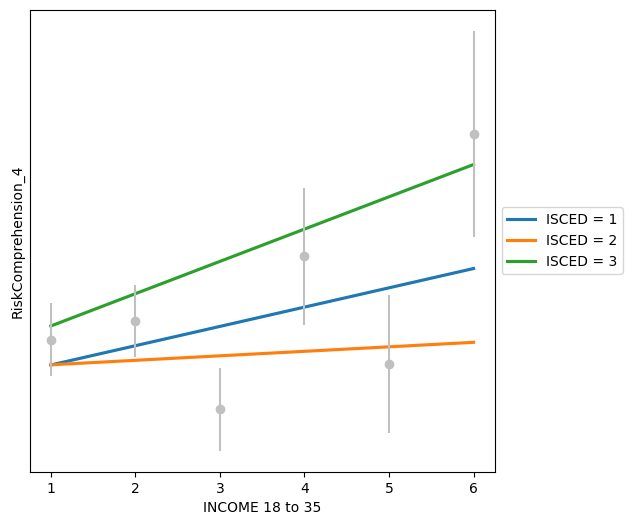

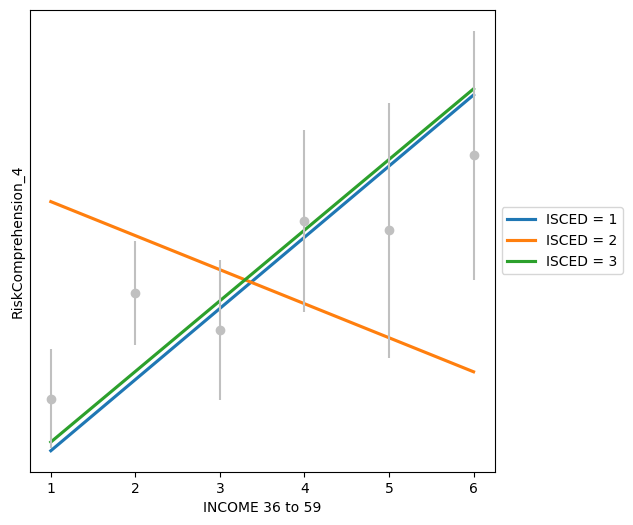

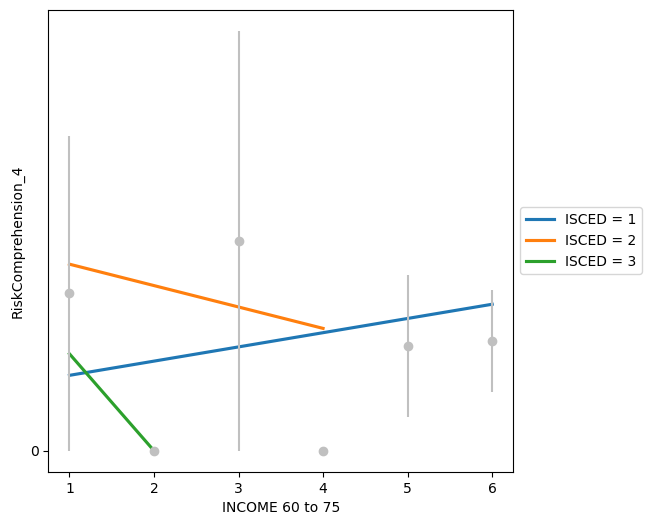

In [158]:
fig, ax1 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==2) & (df7['isced']==1)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==2) & (df7['isced']==1)]['RiskComprehension_4'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 1')
sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==2) & (df7['isced']==2)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==2) & (df7['isced']==2)]['RiskComprehension_4'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 2')
sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==2) & (df7['isced']==3)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==2) & (df7['isced']==3)]['RiskComprehension_4'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 3')

ax1.set(ylabel='RiskComprehension_4', xlabel='INCOME 18 to 35',  yticks = np.arange(0, 3 , 1))
ax1.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
ax1.errorbar(x = [1,2,3,4,5,6], y = df7.loc[ df7['age_rec']==2  ].groupby(['income'])['RiskComprehension_4'].mean(), yerr = df7.loc[ (df7['age_rec']==2) ].groupby(['income'])['RiskComprehension_4'].sem(), fmt='o', color = lighten_color('gray',0.5))
plt.show()

fig, ax2 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==3) & (df7['isced']==1)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==3) & (df7['isced']==1)]['RiskComprehension_4'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 1')
sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==3) & (df7['isced']==2)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==3) & (df7['isced']==2)]['RiskComprehension_4'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 2')
sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==3) & (df7['isced']==3)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==3) & (df7['isced']==3)]['RiskComprehension_4'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 3')

ax2.set(ylabel='RiskComprehension_4', xlabel='INCOME 36 to 59',  yticks = np.arange(0, 3 , 1))
ax2.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
ax2.errorbar(x = [1,2,3,4,5,6], y = df7.loc[ df7['age_rec']==3  ].groupby(['income'])['RiskComprehension_4'].mean(), yerr = df7.loc[ (df7['age_rec']==3) ].groupby(['income'])['RiskComprehension_4'].sem(), fmt='o', color = lighten_color('gray',0.5))
plt.show()

fig, ax3 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==4) & (df7['isced']==1)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==4) & (df7['isced']==1)]['RiskComprehension_4'], fit_reg=True, ci=None, ax=ax3, label='ISCED = 1')
sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==4) & (df7['isced']==2)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==4) & (df7['isced']==2)]['RiskComprehension_4'], fit_reg=True, ci=None, ax=ax3, label='ISCED = 2')
sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==4) & (df7['isced']==3)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==4) & (df7['isced']==3)]['RiskComprehension_4'], fit_reg=True, ci=None, ax=ax3, label='ISCED = 3')

ax3.set(ylabel='RiskComprehension_4', xlabel='INCOME 60 to 75',  yticks = np.arange(0, 3 , 1))
ax3.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
ax3.errorbar(x = df7.loc[ df7['age_rec']== 4 ]['income'].unique(), y = df7.loc[ df7['age_rec']==4  ].groupby(['income'])['RiskComprehension_4'].mean(), yerr = df7.loc[ (df7['age_rec']==4) ].groupby(['income'])['RiskComprehension_4'].sem(), fmt='o', color = lighten_color('gray',0.5))
plt.show()

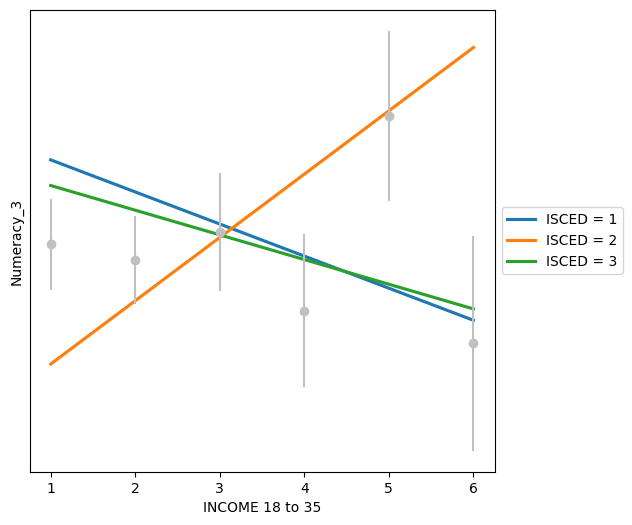

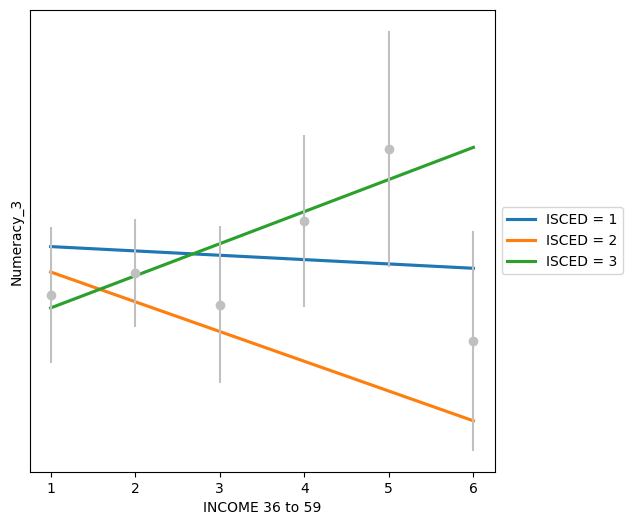

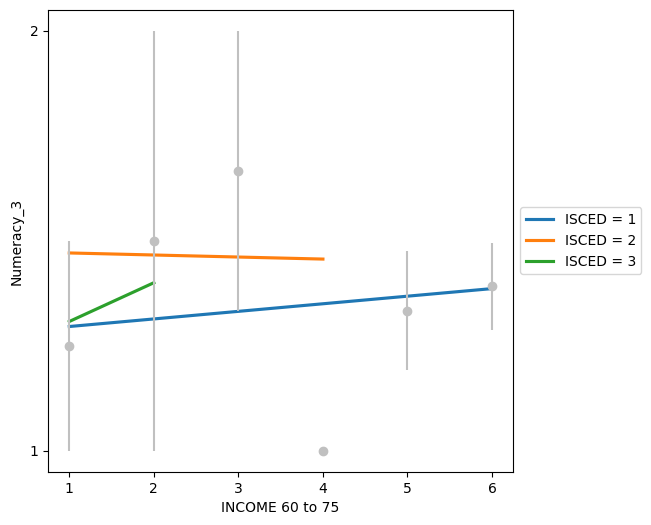

In [159]:
fig, ax1 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==2) & (df7['isced']==1)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==2) & (df7['isced']==1)]['Numeracy_3'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 1')
sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==2) & (df7['isced']==2)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==2) & (df7['isced']==2)]['Numeracy_3'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 2')
sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==2) & (df7['isced']==3)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==2) & (df7['isced']==3)]['Numeracy_3'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 3')

ax1.set(ylabel='Numeracy_3', xlabel='INCOME 18 to 35',  yticks = np.arange(0, 6 , 1))
ax1.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
ax1.errorbar(x = [1,2,3,4,5,6], y = df7.loc[ df7['age_rec']==2  ].groupby(['income'])['Numeracy_3'].mean(), yerr = df7.loc[ (df7['age_rec']==2) ].groupby(['income'])['Numeracy_3'].sem(), fmt='o', color = lighten_color('gray',0.5))
plt.show()

fig, ax2 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==3) & (df7['isced']==1)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==3) & (df7['isced']==1)]['Numeracy_3'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 1')
sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==3) & (df7['isced']==2)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==3) & (df7['isced']==2)]['Numeracy_3'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 2')
sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==3) & (df7['isced']==3)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==3) & (df7['isced']==3)]['Numeracy_3'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 3')

ax2.set(ylabel='Numeracy_3', xlabel='INCOME 36 to 59',  yticks = np.arange(0, 6 , 1))
ax2.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
ax2.errorbar(x = [1,2,3,4,5,6], y = df7.loc[ df7['age_rec']==3  ].groupby(['income'])['Numeracy_3'].mean(), yerr = df7.loc[ (df7['age_rec']==3) ].groupby(['income'])['Numeracy_3'].sem(), fmt='o', color = lighten_color('gray',0.5))
plt.show()

fig, ax3 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==4) & (df7['isced']==1)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==4) & (df7['isced']==1)]['Numeracy_3'], fit_reg=True, ci=None, ax=ax3, label='ISCED = 1')
sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==4) & (df7['isced']==2)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==4) & (df7['isced']==2)]['Numeracy_3'], fit_reg=True, ci=None, ax=ax3, label='ISCED = 2')
sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==4) & (df7['isced']==3)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==4) & (df7['isced']==3)]['Numeracy_3'], fit_reg=True, ci=None, ax=ax3, label='ISCED = 3')

ax3.set(ylabel='Numeracy_3', xlabel='INCOME 60 to 75',  yticks = np.arange(0, 6 , 1))
ax3.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
ax3.errorbar(x = df7.loc[ df7['age_rec']== 4 ]['income'].unique(), y = df7.loc[ df7['age_rec']==4  ].groupby(['income'])['Numeracy_3'].mean(), yerr = df7.loc[ (df7['age_rec']==4) ].groupby(['income'])['Numeracy_3'].sem(), fmt='o', color = lighten_color('gray',0.5))
plt.show()

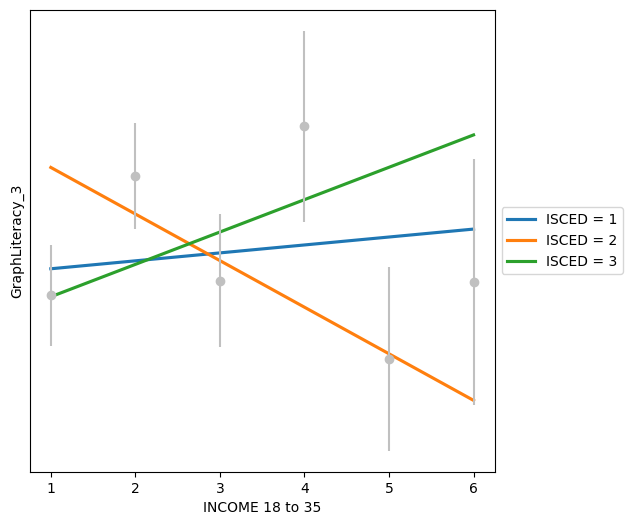

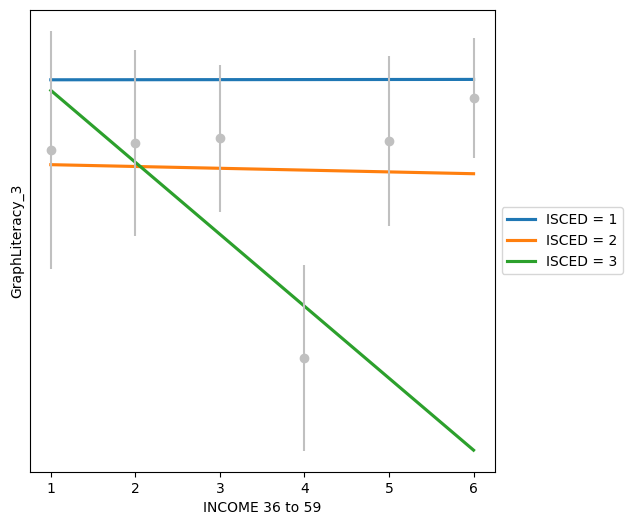

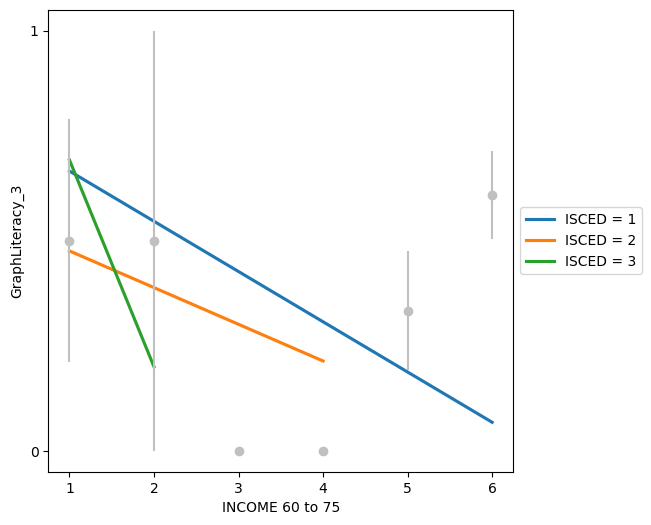

In [160]:
fig, ax1 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==2) & (df7['isced']==1)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==2) & (df7['isced']==1)]['GraphLiteracy_3'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 1')
sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==2) & (df7['isced']==2)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==2) & (df7['isced']==2)]['GraphLiteracy_3'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 2')
sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==2) & (df7['isced']==3)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==2) & (df7['isced']==3)]['GraphLiteracy_3'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 3')

ax1.set(ylabel='GraphLiteracy_3', xlabel='INCOME 18 to 35',  yticks = np.arange(0, 4 , 1))
ax1.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
ax1.errorbar(x = [1,2,3,4,5,6], y = df7.loc[ df7['age_rec']==2  ].groupby(['income'])['GraphLiteracy_3'].mean(), yerr = df7.loc[ (df7['age_rec']==2) ].groupby(['income'])['GraphLiteracy_3'].sem(), fmt='o', color = lighten_color('gray',0.5))
plt.show()

fig, ax2 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==3) & (df7['isced']==1)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==3) & (df7['isced']==1)]['GraphLiteracy_3'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 1')
sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==3) & (df7['isced']==2)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==3) & (df7['isced']==2)]['GraphLiteracy_3'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 2')
sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==3) & (df7['isced']==3)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==3) & (df7['isced']==3)]['GraphLiteracy_3'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 3')

ax2.set(ylabel='GraphLiteracy_3', xlabel='INCOME 36 to 59',  yticks = np.arange(0, 4 , 1))
ax2.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
ax2.errorbar(x = df7.loc[ df7['age_rec']== 3 ]['income'].unique(), y = df7.loc[ df7['age_rec']==3  ].groupby(['income'])['GraphLiteracy_3'].mean(), yerr = df7.loc[ (df7['age_rec']==3) ].groupby(['income'])['GraphLiteracy_3'].sem(), fmt='o', color = lighten_color('gray',0.5))
plt.show()

fig, ax3 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==4) & (df7['isced']==1)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==4) & (df7['isced']==1)]['GraphLiteracy_3'], fit_reg=True, ci=None, ax=ax3, label='ISCED = 1')
sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==4) & (df7['isced']==2)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==4) & (df7['isced']==2)]['GraphLiteracy_3'], fit_reg=True, ci=None, ax=ax3, label='ISCED = 2')
sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==4) & (df7['isced']==3)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==4) & (df7['isced']==3)]['GraphLiteracy_3'], fit_reg=True, ci=None, ax=ax3, label='ISCED = 3')

ax3.set(ylabel='GraphLiteracy_3', xlabel='INCOME 60 to 75',  yticks = np.arange(0, 4 , 1))
ax3.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
ax3.errorbar(x = df7.loc[ df7['age_rec']== 4 ]['income'].unique(), y = df7.loc[ df7['age_rec']==4  ].groupby(['income'])['GraphLiteracy_3'].mean(), yerr = df7.loc[ (df7['age_rec']==4) ].groupby(['income'])['GraphLiteracy_3'].sem(), fmt='o', color = lighten_color('gray',0.5))
plt.show()

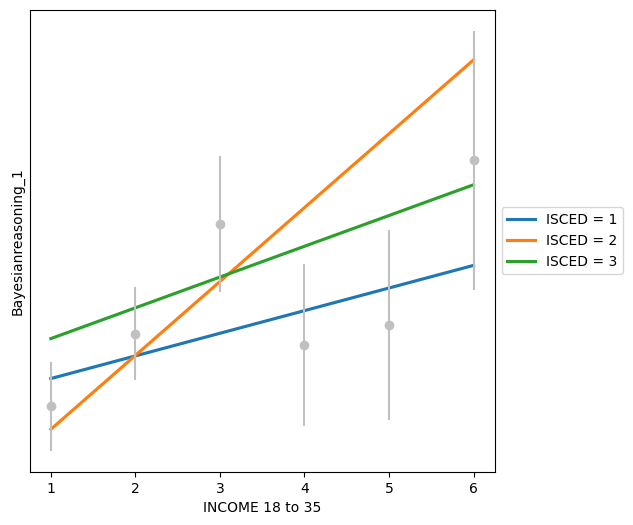

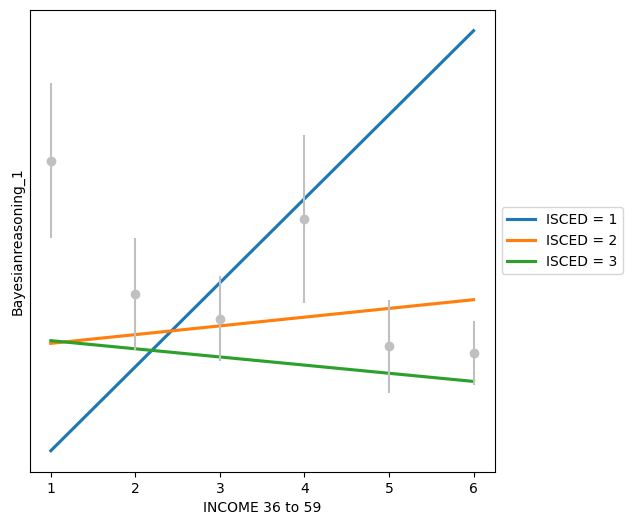

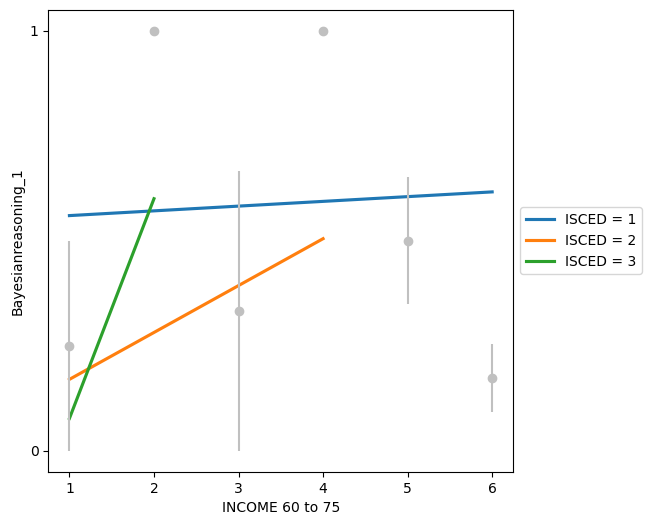

In [161]:
fig, ax1 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==2) & (df7['isced']==1)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==2) & (df7['isced']==1)]['Bayesianreasoning_1'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 1')
sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==2) & (df7['isced']==2)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==2) & (df7['isced']==2)]['Bayesianreasoning_1'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 2')
sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==2) & (df7['isced']==3)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==2) & (df7['isced']==3)]['Bayesianreasoning_1'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 3')

ax1.set(ylabel='Bayesianreasoning_1', xlabel='INCOME 18 to 35',  yticks = np.arange(0, 5 , 1))
ax1.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
ax1.errorbar(x = [1,2,3,4,5,6], y = df7.loc[ df7['age_rec']==2  ].groupby(['income'])['Bayesianreasoning_1'].mean(), yerr = df7.loc[ (df7['age_rec']==2) ].groupby(['income'])['Bayesianreasoning_1'].sem(), fmt='o', color = lighten_color('gray',0.5))
plt.show()

fig, ax2 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==3) & (df7['isced']==1)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==3) & (df7['isced']==1)]['Bayesianreasoning_1'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 1')
sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==3) & (df7['isced']==2)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==3) & (df7['isced']==2)]['Bayesianreasoning_1'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 2')
sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==3) & (df7['isced']==3)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==3) & (df7['isced']==3)]['Bayesianreasoning_1'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 3')

ax2.set(ylabel='Bayesianreasoning_1', xlabel='INCOME 36 to 59',  yticks = np.arange(0, 5 , 1))
ax2.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
ax2.errorbar(x = df7.loc[ df7['age_rec']== 3 ]['income'].unique(), y = df7.loc[ df7['age_rec']==3  ].groupby(['income'])['Bayesianreasoning_1'].mean(), yerr = df7.loc[ (df7['age_rec']==3) ].groupby(['income'])['Bayesianreasoning_1'].sem(), fmt='o', color = lighten_color('gray',0.5))
plt.show()

fig, ax3 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==4) & (df7['isced']==1)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==4) & (df7['isced']==1)]['Bayesianreasoning_1'], fit_reg=True, ci=None, ax=ax3, label='ISCED = 1')
sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==4) & (df7['isced']==2)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==4) & (df7['isced']==2)]['Bayesianreasoning_1'], fit_reg=True, ci=None, ax=ax3, label='ISCED = 2')
sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==4) & (df7['isced']==3)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==4) & (df7['isced']==3)]['Bayesianreasoning_1'], fit_reg=True, ci=None, ax=ax3, label='ISCED = 3')

ax3.set(ylabel='Bayesianreasoning_1', xlabel='INCOME 60 to 75',  yticks = np.arange(0, 5 , 1))
ax3.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
ax3.errorbar(x = df7.loc[ df7['age_rec']== 4 ]['income'].unique(), y = df7.loc[ df7['age_rec']==4  ].groupby(['income'])['Bayesianreasoning_1'].mean(), yerr = df7.loc[ (df7['age_rec']==4) ].groupby(['income'])['Bayesianreasoning_1'].sem(), fmt='o', color = lighten_color('gray',0.5))
plt.show()

In [162]:
# Age median method
# Age_median

In [163]:
age_m = df1["age"].median()
age_m

33.0

In [164]:
df7["income"].value_counts()

income
2    221
1    194
3    114
4     76
5     52
6     42
Name: count, dtype: int64

In [165]:
df7.loc[(df7['age'] < age_m)].describe()

ResponseId         age  age_rec       isced      income  Certainty_3  \
count  338.000000  338.000000    338.0  338.000000  338.000000   338.000000   
mean   345.745562   26.260355      2.0    1.970414    2.349112     2.112426   
std    194.884917    3.812788      0.0    0.762053    1.365976     0.970985   
min      0.000000   18.000000      2.0    1.000000    1.000000     0.000000   
25%    205.250000   24.000000      2.0    1.000000    1.000000     2.000000   
50%    343.500000   26.000000      2.0    2.000000    2.000000     2.000000   
75%    509.500000   30.000000      2.0    3.000000    3.000000     3.000000   
max    693.000000   32.000000      2.0    3.000000    6.000000     3.000000   

       RiskComprehension_4  GraphLiteracy_3  Numeracy_3  Bayesianreasoning_1  \
count           338.000000       338.000000  338.000000           338.000000   
mean              0.260355         0.295858    1.482249             0.263314   
std               0.439479         0.457104    0.500426             0.441084   
min               0.000000         0.000000    1.000000             0.000000   
25%               0.000000         0.000000    1.000000             0.000000   
50%               0.000000         0.000000    1.000000             0.000000   
75%               1.000000         1.000000    2.000000             1.000000   
max               1.000000         1.000000    2.000000             1.000000   

       Certainty_%  RiskComprehension_%  GraphLiteracy_%  Numeracy_%  \
count   338.000000           338.000000       338.000000  338.000000   
mean     70.414201             6.508876         9.861933   49.408284   
std      32.366177            10.986973        15.236805   16.680854   
min       0.000000             0.000000         0.000000   33.333333   
25%      66.666667             0.000000         0.000000   33.333333   
50%      66.666667             0.000000         0.000000   33.333333   
75%     100.000000            25.000000        33.333333   66.666667   
max     100.000000            25.000000        33.333333   66.666667   

       Bayesianreasoning_%  TotalScore_14  TotalScore_%  
count           338.000000     338.000000    338.000000  
mean             26.331361       4.414201     31.530008  
std              44.108407       1.314168      9.386916  
min               0.000000       1.000000      7.142857  
25%               0.000000       3.000000     21.428571  
50%               0.000000       5.000000     35.714286  
75%             100.000000       5.000000     35.714286  
max             100.000000       8.000000     57.142857

In [166]:
df7.loc[(df7['age'] > age_m)].describe()

ResponseId         age     age_rec       isced      income  \
count  347.000000  347.000000  347.000000  347.000000  347.000000   
mean   350.051873   43.985591    2.919308    1.910663    2.786744   
std    208.145271    9.435961    0.578369    0.843593    1.560179   
min      1.000000   34.000000    2.000000    1.000000    1.000000   
25%    161.000000   36.000000    3.000000    1.000000    2.000000   
50%    352.000000   42.000000    3.000000    2.000000    2.000000   
75%    544.500000   48.000000    3.000000    3.000000    4.000000   
max    698.000000   75.000000    4.000000    3.000000    6.000000   

       Certainty_3  RiskComprehension_4  GraphLiteracy_3  Numeracy_3  \
count   347.000000           347.000000       347.000000  347.000000   
mean      2.146974             0.195965         0.342939    1.504323   
std       1.016489             0.397515         0.475377    0.500703   
min       0.000000             0.000000         0.000000    1.000000   
25%       2.000000             0.000000         0.000000    1.000000   
50%       2.000000             0.000000         0.000000    2.000000   
75%       3.000000             0.000000         1.000000    2.000000   
max       3.000000             1.000000         1.000000    2.000000   

       Bayesianreasoning_1  Certainty_%  RiskComprehension_%  GraphLiteracy_%  \
count           347.000000   347.000000           347.000000       347.000000   
mean              0.299712    71.565802             4.899135        11.431316   
std               0.458793    33.882960             9.937881        15.845898   
min               0.000000     0.000000             0.000000         0.000000   
25%               0.000000    66.666667             0.000000         0.000000   
50%               0.000000    66.666667             0.000000         0.000000   
75%               1.000000   100.000000             0.000000        33.333333   
max               1.000000   100.000000            25.000000        33.333333   

       Numeracy_%  Bayesianreasoning_%  TotalScore_14  TotalScore_%  
count  347.000000           347.000000     347.000000    347.000000  
mean    50.144092            29.971182       4.489914     32.070811  
std     16.690110            45.879325       1.381876      9.870540  
min     33.333333             0.000000       1.000000      7.142857  
25%     33.333333             0.000000       4.000000     28.571429  
50%     66.666667             0.000000       5.000000     35.714286  
75%     66.666667           100.000000       5.000000     35.714286  
max     66.666667           100.000000       8.000000     57.142857

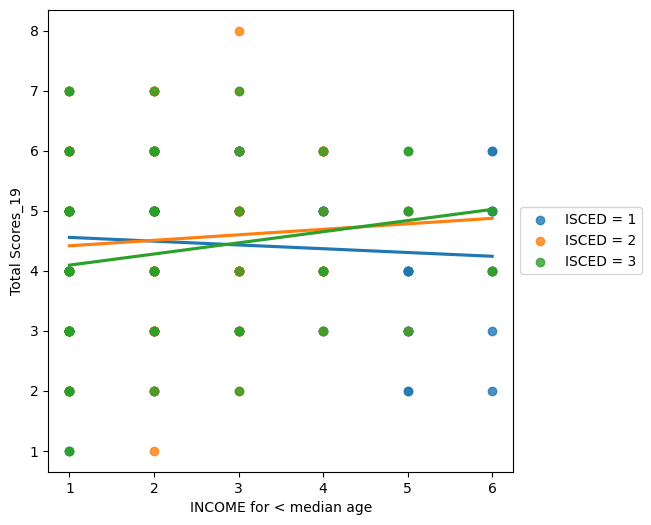

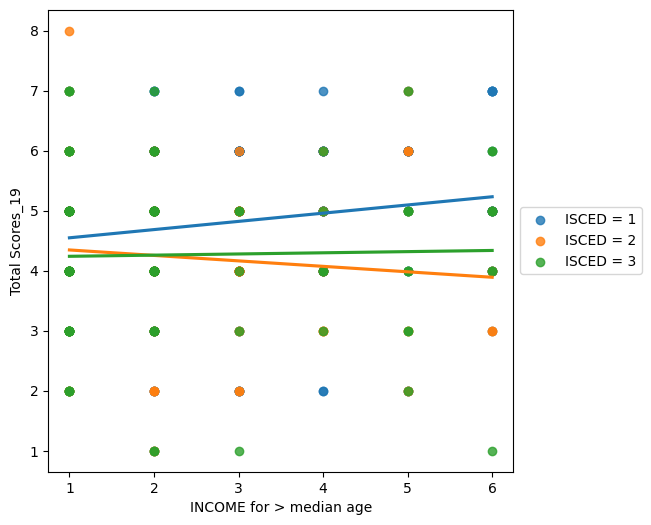

In [167]:
fig, ax1 = plt.subplots(figsize=(6, 6))

sns.regplot (data = df7.loc[(df7['age'] < age_m) & (df7['isced']==1)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age'] < age_m) & (df7['isced']==1)]['TotalScore_14'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 1')
sns.regplot (data = df7.loc[(df7['age'] < age_m) & (df7['isced']==2)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age'] < age_m) & (df7['isced']==2)]['TotalScore_14'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 2')
sns.regplot (data = df7.loc[(df7['age'] < age_m) & (df7['isced']==3)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age'] < age_m) & (df7['isced']==3)]['TotalScore_14'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 3')

ax1.set(ylabel='Total Scores_19', xlabel='INCOME for < median age')
ax1.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

fig, ax2 = plt.subplots(figsize=(6, 6))

sns.regplot (data = df7.loc[(df7['age'] > age_m) & (df7['isced']==1)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age'] > age_m) & (df7['isced']==1)]['TotalScore_14'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 1')
sns.regplot (data = df7.loc[(df7['age'] > age_m) & (df7['isced']==2)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age'] > age_m) & (df7['isced']==2)]['TotalScore_14'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 2')
sns.regplot (data = df7.loc[(df7['age'] > age_m) & (df7['isced']==3)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age'] > age_m) & (df7['isced']==3)]['TotalScore_14'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 3')

ax2.set(ylabel='Total Scores_19', xlabel='INCOME for > median age')
ax2.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

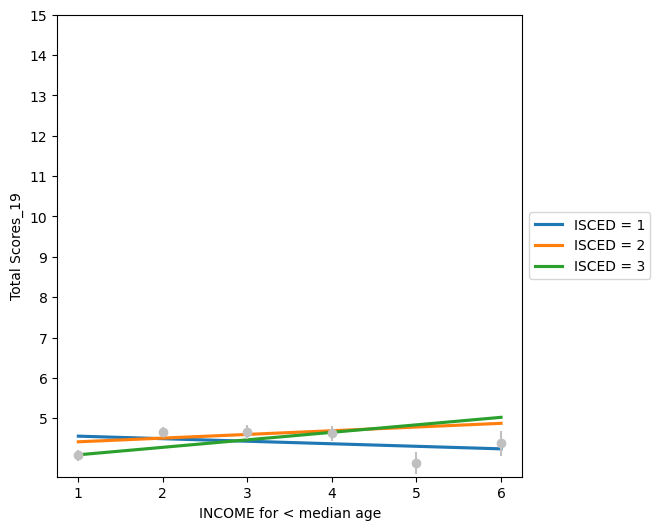

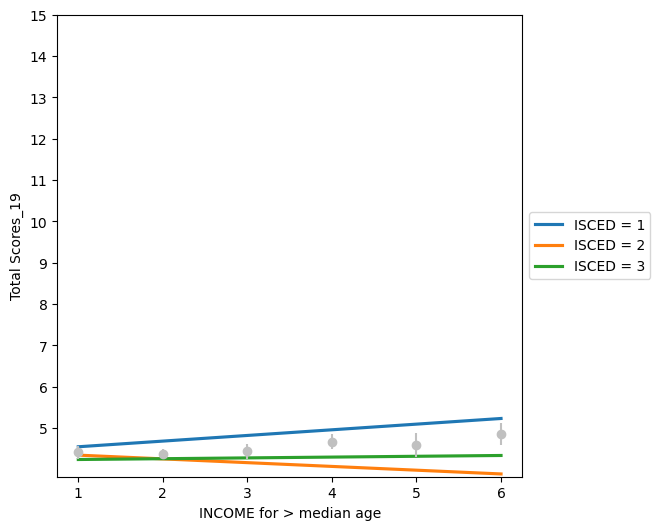

In [168]:
fig, ax1 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df7.loc[(df7['age'] < age_m) & (df7['isced']==1)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age'] < age_m) & (df7['isced']==1)]['TotalScore_14'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 1')
sns.regplot (scatter = False, data = df7.loc[(df7['age'] < age_m) & (df7['isced']==2)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age'] < age_m) & (df7['isced']==2)]['TotalScore_14'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 2')
sns.regplot (scatter = False, data = df7.loc[(df7['age'] < age_m) & (df7['isced']==3)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age'] < age_m) & (df7['isced']==3)]['TotalScore_14'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 3')

ax1.errorbar(x = [1,2,3,4,5,6], y = df7.loc[ (df7['age'] < age_m)  ].groupby(['income'])['TotalScore_14'].mean(), yerr = df7.loc[ (df7['age'] < age_m) ].groupby(['income'])['TotalScore_14'].sem(), fmt='o', color = lighten_color('gray',0.5))
ax1.set(ylabel='Total Scores_19', xlabel='INCOME for < median age',  yticks = np.arange(5, 16 , 1))
ax1.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

fig, ax2 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df7.loc[(df7['age'] > age_m) & (df7['isced']==1)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age'] > age_m) & (df7['isced']==1)]['TotalScore_14'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 1')
sns.regplot (scatter = False, data = df7.loc[(df7['age'] > age_m) & (df7['isced']==2)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age'] > age_m) & (df7['isced']==2)]['TotalScore_14'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 2')
sns.regplot (scatter = False, data = df7.loc[(df7['age'] > age_m) & (df7['isced']==3)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age'] > age_m) & (df7['isced']==3)]['TotalScore_14'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 3')

ax2.errorbar(x = [1,2,3,4,5,6], y = df7.loc[ (df7['age'] > age_m)  ].groupby(['income'])['TotalScore_14'].mean(), yerr = df7.loc[ (df7['age'] > age_m) ].groupby(['income'])['TotalScore_14'].sem(), fmt='o', color = lighten_color('gray',0.5))
ax2.set(ylabel='Total Scores_19', xlabel='INCOME for > median age',  yticks = np.arange(5, 16 , 1))
ax2.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

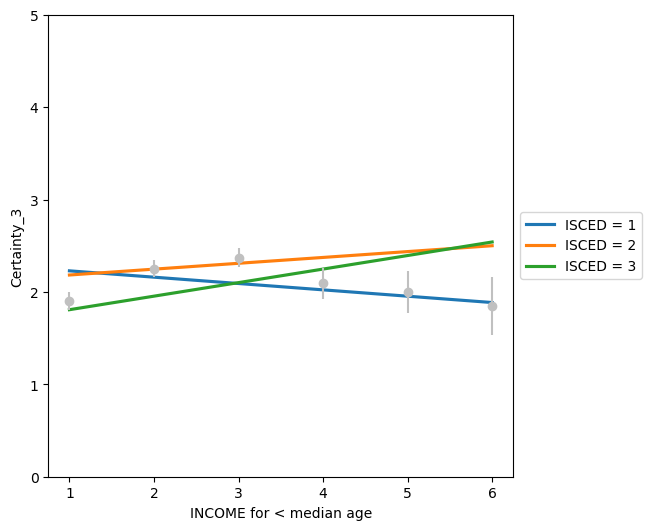

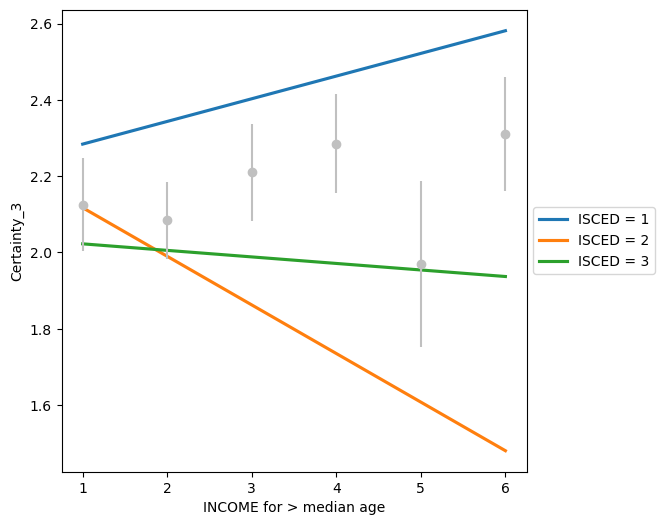

In [169]:
fig, ax1 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df7.loc[(df7['age'] < age_m) & (df7['isced']==1)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age'] < age_m) & (df7['isced']==1)]['Certainty_3'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 1')
sns.regplot (scatter = False, data = df7.loc[(df7['age'] < age_m) & (df7['isced']==2)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age'] < age_m) & (df7['isced']==2)]['Certainty_3'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 2')
sns.regplot (scatter = False, data = df7.loc[(df7['age'] < age_m) & (df7['isced']==3)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age'] < age_m) & (df7['isced']==3)]['Certainty_3'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 3')

ax1.errorbar(x = [1,2,3,4,5,6], y = df7.loc[ (df7['age'] < age_m)  ].groupby(['income'])['Certainty_3'].mean(), yerr = df7.loc[ (df7['age'] < age_m) ].groupby(['income'])['Certainty_3'].sem(), fmt='o', color = lighten_color('gray',0.5))
ax1.set(ylabel='Certainty_3', xlabel='INCOME for < median age',  yticks = np.arange(0, 6 , 1))
ax1.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

fig, ax2 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df7.loc[(df7['age'] > age_m) & (df7['isced']==1)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age'] > age_m) & (df7['isced']==1)]['Certainty_3'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 1')
sns.regplot (scatter = False, data = df7.loc[(df7['age'] > age_m) & (df7['isced']==2)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age'] > age_m) & (df7['isced']==2)]['Certainty_3'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 2')
sns.regplot (scatter = False, data = df7.loc[(df7['age'] > age_m) & (df7['isced']==3)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age'] > age_m) & (df7['isced']==3)]['Certainty_3'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 3')

ax2.errorbar(x = [1,2,3,4,5,6], y = df7.loc[ (df7['age'] > age_m)  ].groupby(['income'])['Certainty_3'].mean(), yerr = df7.loc[ (df7['age'] > age_m) ].groupby(['income'])['Certainty_3'].sem(), fmt='o', color = lighten_color('gray',0.5))
ax2.set(ylabel='Certainty_3', xlabel='INCOME for > median age')
ax2.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

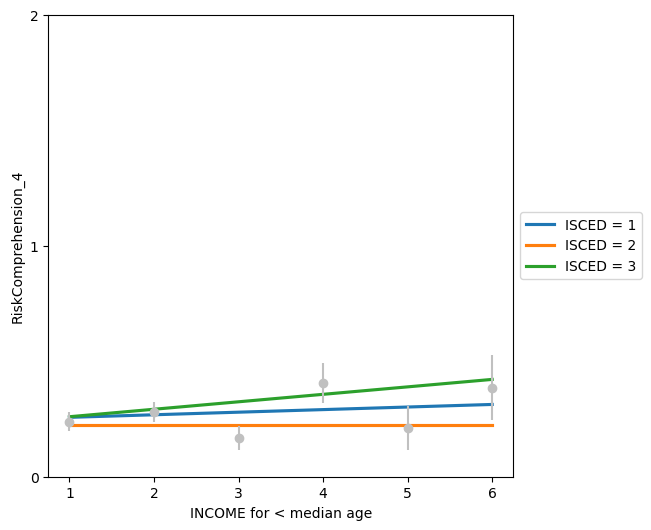

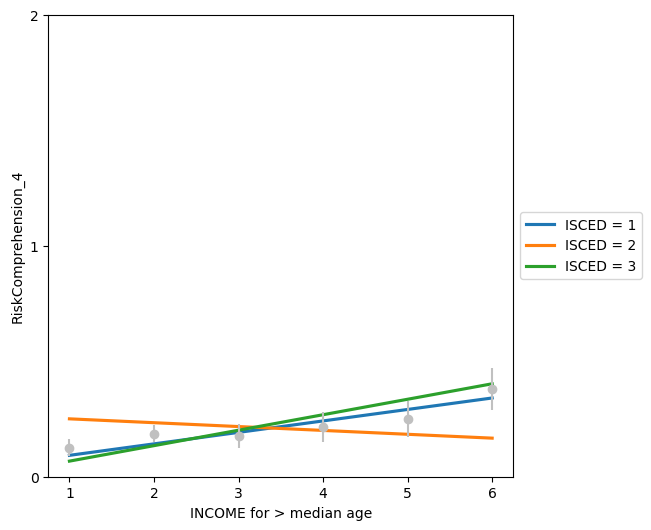

In [170]:
fig, ax1 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df7.loc[(df7['age'] < age_m) & (df7['isced']==1)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age'] < age_m) & (df7['isced']==1)]['RiskComprehension_4'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 1')
sns.regplot (scatter = False, data = df7.loc[(df7['age'] < age_m) & (df7['isced']==2)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age'] < age_m) & (df7['isced']==2)]['RiskComprehension_4'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 2')
sns.regplot (scatter = False, data = df7.loc[(df7['age'] < age_m) & (df7['isced']==3)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age'] < age_m) & (df7['isced']==3)]['RiskComprehension_4'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 3')

ax1.errorbar(x = [1,2,3,4,5,6], y = df7.loc[ (df7['age'] < age_m)  ].groupby(['income'])['RiskComprehension_4'].mean(), yerr = df7.loc[ (df7['age'] < age_m) ].groupby(['income'])['RiskComprehension_4'].sem(), fmt='o', color = lighten_color('gray',0.5))
ax1.set(ylabel='RiskComprehension_4', xlabel='INCOME for < median age',  yticks = np.arange(0, 3 , 1))
ax1.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

fig, ax2 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df7.loc[(df7['age'] > age_m) & (df7['isced']==1)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age'] > age_m) & (df7['isced']==1)]['RiskComprehension_4'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 1')
sns.regplot (scatter = False, data = df7.loc[(df7['age'] > age_m) & (df7['isced']==2)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age'] > age_m) & (df7['isced']==2)]['RiskComprehension_4'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 2')
sns.regplot (scatter = False, data = df7.loc[(df7['age'] > age_m) & (df7['isced']==3)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age'] > age_m) & (df7['isced']==3)]['RiskComprehension_4'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 3')

ax2.errorbar(x = [1,2,3,4,5,6], y = df7.loc[ (df7['age'] > age_m)  ].groupby(['income'])['RiskComprehension_4'].mean(), yerr = df7.loc[ (df7['age'] > age_m) ].groupby(['income'])['RiskComprehension_4'].sem(), fmt='o', color = lighten_color('gray',0.5))
ax2.set(ylabel='RiskComprehension_4', xlabel='INCOME for > median age',  yticks = np.arange(0, 3 , 1))
ax2.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

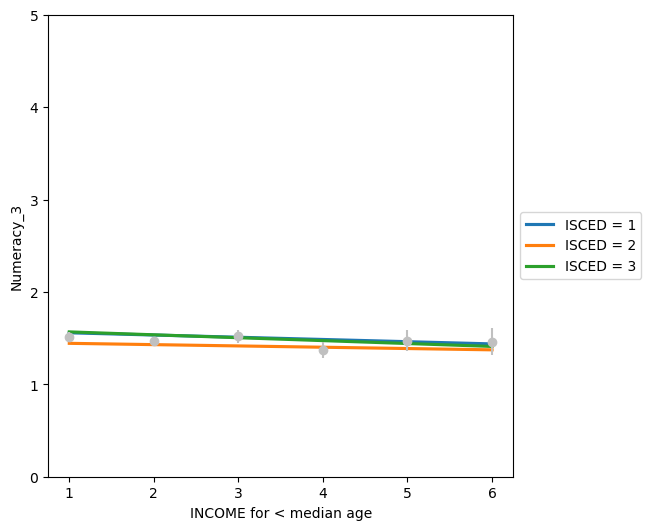

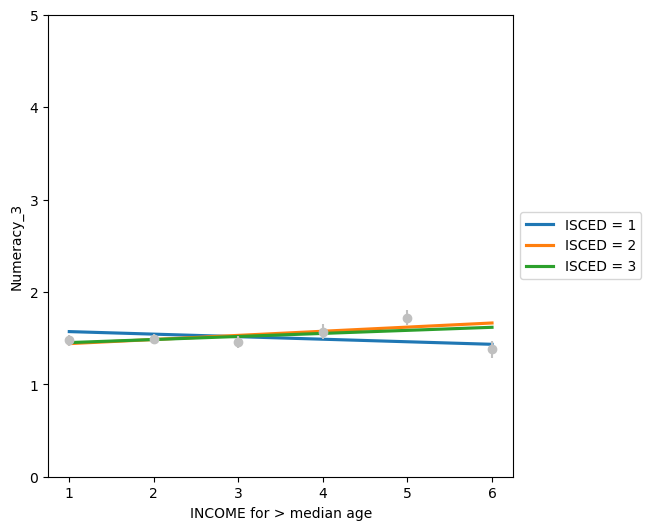

In [171]:
fig, ax1 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df7.loc[(df7['age'] < age_m) & (df7['isced']==1)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age'] < age_m) & (df7['isced']==1)]['Numeracy_3'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 1')
sns.regplot (scatter = False, data = df7.loc[(df7['age'] < age_m) & (df7['isced']==2)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age'] < age_m) & (df7['isced']==2)]['Numeracy_3'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 2')
sns.regplot (scatter = False, data = df7.loc[(df7['age'] < age_m) & (df7['isced']==3)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age'] < age_m) & (df7['isced']==3)]['Numeracy_3'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 3')

ax1.errorbar(x = [1,2,3,4,5,6], y = df7.loc[ (df7['age'] < age_m)  ].groupby(['income'])['Numeracy_3'].mean(), yerr = df7.loc[ (df7['age'] < age_m) ].groupby(['income'])['Numeracy_3'].sem(), fmt='o', color = lighten_color('gray',0.5))
ax1.set(ylabel='Numeracy_3', xlabel='INCOME for < median age',  yticks = np.arange(0, 6 , 1))
ax1.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

fig, ax2 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df7.loc[(df7['age'] > age_m) & (df7['isced']==1)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age'] > age_m) & (df7['isced']==1)]['Numeracy_3'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 1')
sns.regplot (scatter = False, data = df7.loc[(df7['age'] > age_m) & (df7['isced']==2)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age'] > age_m) & (df7['isced']==2)]['Numeracy_3'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 2')
sns.regplot (scatter = False, data = df7.loc[(df7['age'] > age_m) & (df7['isced']==3)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age'] > age_m) & (df7['isced']==3)]['Numeracy_3'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 3')

ax2.errorbar(x = [1,2,3,4,5,6], y = df7.loc[ (df7['age'] > age_m)  ].groupby(['income'])['Numeracy_3'].mean(), yerr = df7.loc[ (df7['age'] > age_m) ].groupby(['income'])['Numeracy_3'].sem(), fmt='o', color = lighten_color('gray',0.5))
ax2.set(ylabel='Numeracy_3', xlabel='INCOME for > median age',  yticks = np.arange(0, 6 , 1))
ax2.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

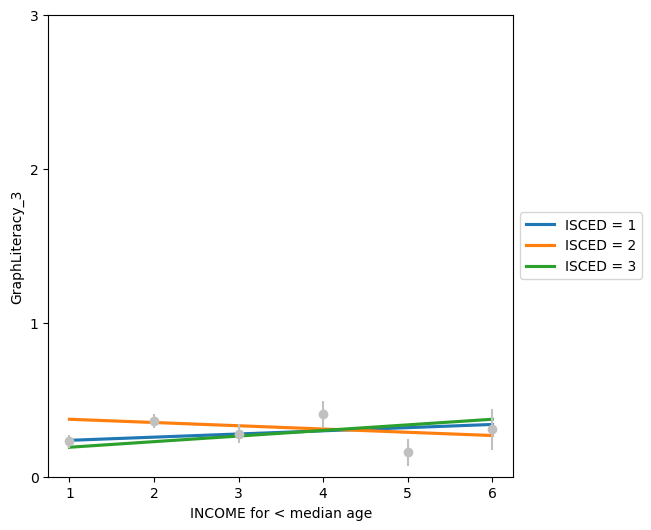

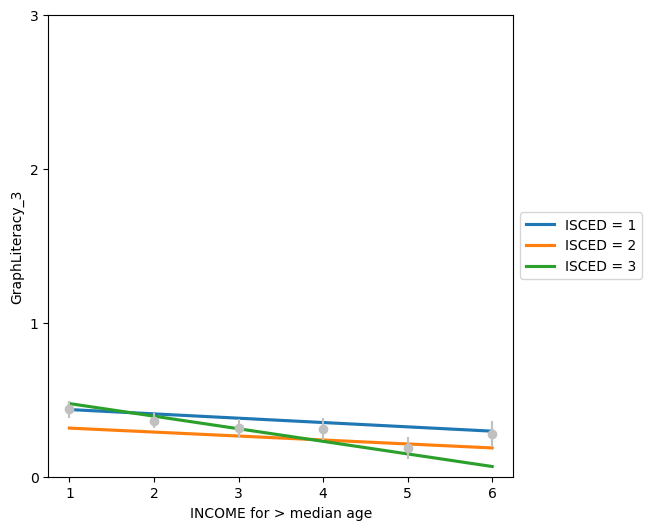

In [172]:
fig, ax1 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df7.loc[(df7['age'] < age_m) & (df7['isced']==1)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age'] < age_m) & (df7['isced']==1)]['GraphLiteracy_3'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 1')
sns.regplot (scatter = False, data = df7.loc[(df7['age'] < age_m) & (df7['isced']==2)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age'] < age_m) & (df7['isced']==2)]['GraphLiteracy_3'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 2')
sns.regplot (scatter = False, data = df7.loc[(df7['age'] < age_m) & (df7['isced']==3)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age'] < age_m) & (df7['isced']==3)]['GraphLiteracy_3'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 3')

ax1.errorbar(x = [1,2,3,4,5,6], y = df7.loc[ (df7['age'] < age_m)  ].groupby(['income'])['GraphLiteracy_3'].mean(), yerr = df7.loc[ (df7['age'] < age_m) ].groupby(['income'])['GraphLiteracy_3'].sem(), fmt='o', color = lighten_color('gray',0.5))
ax1.set(ylabel='GraphLiteracy_3', xlabel='INCOME for < median age',  yticks = np.arange(0, 4 , 1))
ax1.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

fig, ax2 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df7.loc[(df7['age'] > age_m) & (df7['isced']==1)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age'] > age_m) & (df7['isced']==1)]['GraphLiteracy_3'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 1')
sns.regplot (scatter = False, data = df7.loc[(df7['age'] > age_m) & (df7['isced']==2)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age'] > age_m) & (df7['isced']==2)]['GraphLiteracy_3'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 2')
sns.regplot (scatter = False, data = df7.loc[(df7['age'] > age_m) & (df7['isced']==3)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age'] > age_m) & (df7['isced']==3)]['GraphLiteracy_3'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 3')

ax2.errorbar(x = [1,2,3,4,5,6], y = df7.loc[ (df7['age'] > age_m)  ].groupby(['income'])['GraphLiteracy_3'].mean(), yerr = df7.loc[ (df7['age'] > age_m) ].groupby(['income'])['GraphLiteracy_3'].sem(), fmt='o', color = lighten_color('gray',0.5))
ax2.set(ylabel='GraphLiteracy_3', xlabel='INCOME for > median age',  yticks = np.arange(0, 4 , 1))
ax2.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

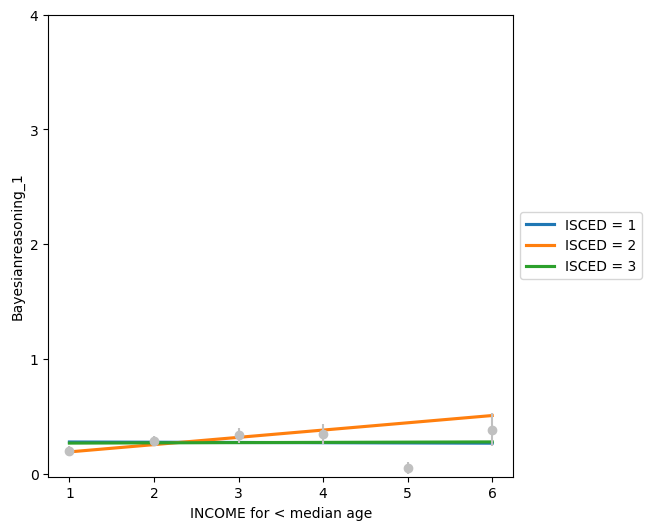

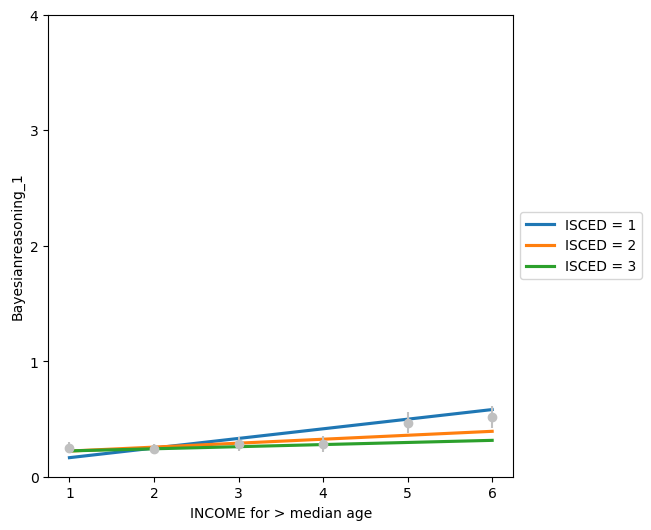

In [173]:
fig, ax1 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df7.loc[(df7['age'] < age_m) & (df7['isced']==1)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age'] < age_m) & (df7['isced']==1)]['Bayesianreasoning_1'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 1')
sns.regplot (scatter = False, data = df7.loc[(df7['age'] < age_m) & (df7['isced']==2)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age'] < age_m) & (df7['isced']==2)]['Bayesianreasoning_1'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 2')
sns.regplot (scatter = False, data = df7.loc[(df7['age'] < age_m) & (df7['isced']==3)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age'] < age_m) & (df7['isced']==3)]['Bayesianreasoning_1'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 3')

ax1.errorbar(x = [1,2,3,4,5,6], y = df7.loc[ (df7['age'] < age_m)  ].groupby(['income'])['Bayesianreasoning_1'].mean(), yerr = df7.loc[ (df7['age'] < age_m) ].groupby(['income'])['Bayesianreasoning_1'].sem(), fmt='o', color = lighten_color('gray',0.5))
ax1.set(ylabel='Bayesianreasoning_1', xlabel='INCOME for < median age',  yticks = np.arange(0, 5 , 1))
ax1.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

fig, ax2 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df7.loc[(df7['age'] > age_m) & (df7['isced']==1)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age'] > age_m) & (df7['isced']==1)]['Bayesianreasoning_1'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 1')
sns.regplot (scatter = False, data = df7.loc[(df7['age'] > age_m) & (df7['isced']==2)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age'] > age_m) & (df7['isced']==2)]['Bayesianreasoning_1'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 2')
sns.regplot (scatter = False, data = df7.loc[(df7['age'] > age_m) & (df7['isced']==3)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age'] > age_m) & (df7['isced']==3)]['Bayesianreasoning_1'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 3')

ax2.errorbar(x = [1,2,3,4,5,6], y = df7.loc[ (df7['age'] > age_m)  ].groupby(['income'])['Bayesianreasoning_1'].mean(), yerr = df7.loc[ (df7['age'] > age_m) ].groupby(['income'])['Bayesianreasoning_1'].sem(), fmt='o', color = lighten_color('gray',0.5))
ax2.set(ylabel='Bayesianreasoning_1', xlabel='INCOME for > median age',  yticks = np.arange(0, 5 , 1))
ax2.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()